<a href="https://colab.research.google.com/github/cleonorris02/COMP-551/blob/main/comp551_assignment3_group_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Acquire the Data

In [ ]:
import requests
import tarfile
from io import BytesIO
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from sklearn.preprocessing import OneHotEncoder
np.random.seed(1234)

from typing import List
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from scipy.optimize import check_grad

**Use Kaggle API to download data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist

sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
replace amer_sign2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Load dataset and normalize**

In [ ]:
# use default train and test partitions
train_df_original = pd.read_csv('sign_mnist_train.csv')
test_df_original = pd.read_csv('sign_mnist_test.csv')

In [ ]:
train_df_original.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
# save label as separate vector before normalizing
train_label = train_df_original['label']
train_label.head()

0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64

In [ ]:
print(f"labels range from {min(train_label)} to {max(train_label)}")

labels range from 0 to 24


In [ ]:
# there are no 9 labels, so makes sense to have 0-24 for 24 classes
list(train_label).count(9)

0

In [ ]:
X_train = train_df_original.drop(['label'],axis=1)
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
# we see training data is 27,455 cases
print(X_train.shape)

(27455, 784)


In [ ]:
# save label as separate vector before normalizing
test_label = test_df_original['label']
X_test = test_df_original.drop(['label'],axis=1)
print(X_test.shape)
X_test.head()

(7172, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
# normalize training and test sets
X_train /= np.std(X_train, axis = 0)
# changed standardization for X_test to use the training data to avoid leakage
X_test /= np.std(X_train, axis = 0)

In [ ]:
# obtain means and std deviations for centering
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
mean_test = X_test.mean(axis=0)
std_test = X_test.std(axis=0)

In [ ]:
# set 0 values to 1
std_train[std_train == 0] = 1
std_test[std_test == 0] = 1

# mean centering
X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_test) / std_test

In [ ]:
# see normalized results
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,-0.928934,-0.763611,-0.620840,-0.506449,-0.463766,-0.426602,-0.413297,-0.366576,-0.335506,-0.304792,...,1.033630,0.908285,0.833096,0.751464,0.690805,0.681913,0.678545,0.664050,0.658101,0.654928
1,0.231648,0.212801,0.121678,0.063569,-0.005683,-0.039065,-0.127716,-0.128919,-0.182374,-0.272822,...,-1.131035,0.022963,-0.393091,-1.132115,-1.066380,0.004150,0.190427,-0.931558,-0.410906,-0.168094
2,1.005369,0.988923,0.941008,0.866777,0.829645,0.763690,0.757584,0.762293,0.705791,0.654310,...,0.955200,0.816700,0.724446,0.625892,0.565292,0.571580,0.552579,0.521868,0.516615,0.546227
3,1.585660,1.564756,1.555506,1.514525,1.476351,1.428039,1.442977,1.415849,1.410197,1.453562,...,1.472837,1.320418,1.236651,1.128180,1.067345,0.997152,0.977714,0.948416,1.066839,0.049308
4,0.449257,0.463163,0.480135,0.478128,0.533239,0.569922,0.557677,0.643465,0.644538,0.654310,...,-0.770258,-0.648660,-0.750081,-0.802488,-0.454503,0.004150,-0.092997,0.016328,0.044994,0.297767


In [ ]:
X_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.033661,-0.034532,-0.082198,-0.143907,-0.216418,-0.271283,-0.311570,-0.380355,-0.432642,-0.473132,...,-0.008474,0.037775,-0.361083,-1.016376,-1.179338,-0.971742,-0.784467,-0.691910,-0.545575,-0.699666
1,-0.493945,-0.536110,-0.551998,-0.601284,-0.666753,-0.742316,-0.753405,-0.798353,-0.877458,-0.905742,...,-1.419290,-0.637772,0.657766,0.417312,0.415747,0.371782,0.388579,0.398839,0.377004,0.369381
2,-1.434460,-1.491497,-1.516325,-1.516040,-1.408482,-1.047102,-0.753405,-0.575421,-0.551260,-0.473132,...,-1.093717,0.314136,1.387687,1.088400,1.090590,1.028277,1.020219,1.019960,1.001976,0.984449
3,1.272388,1.303011,1.327202,1.279046,1.293531,1.335770,1.317696,1.263768,1.316964,1.288210,...,0.239582,1.573110,1.463720,1.408692,1.443349,1.165683,1.080375,1.247199,1.433505,1.467716
4,0.928297,0.968625,0.981034,0.999538,1.081608,1.114107,1.096778,1.096569,1.109383,1.102806,...,-1.744863,-1.620386,-1.319104,-1.641709,-1.992218,-1.735108,-1.641693,-1.691763,-1.646717,-1.490467


**Exploratory data analysis**

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 164.2 MB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 42.9 MB


In [ ]:
class_labels = train_label.unique()
class_counts = train_label.value_counts()

**Create bar plot**

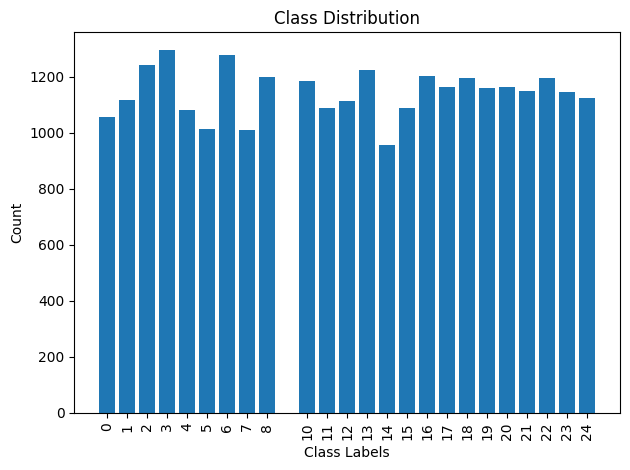

In [ ]:
plt.bar(class_labels, class_counts)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(class_labels, rotation=90)
plt.tight_layout()
plt.show()

**Vectorize data by converting the integer labels to binary form**

In [ ]:
# vectorize data
lb = LabelBinarizer()
# use the labels saved from data above
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

In [ ]:
train_label[1]

6

In [ ]:
X_train=X_train.values.reshape(-1, 784)

In [ ]:
X_test = X_test.values.reshape(-1, 784)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27455, 784) (27455, 24) (7172, 784) (7172, 24)


# Task 2: Implement an MLP to classify image data


The following MLP code is adapted from tutorial.

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None   # list of gradients (one gradient per parameter)
        self.parameters = None   # list of parameters to be updated

    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size

        # initialize weights and biases
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)

        self.cur_input = None
        self.parameters = [self.w, self.b]

        # initialize batch normalization parameters
        self.gamma = np.ones(output_size)
        self.beta = np.zeros(output_size)
        self.epsilon = 1e-5

    # does linear transformation to input
    def forward(self, x):
        self.cur_input = x
        linear_output = (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
        mean = np.mean(linear_output, axis=0)
        variance = np.var(linear_output, axis=0)
        # add batch normalization to mitigate vanishing gradient
        normalized_output = (linear_output - mean) / np.sqrt(variance + self.epsilon)
        normalized_output = self.gamma * normalized_output + self.beta

        return normalized_output

    # computes grad for current layer and following grads for previous layer
    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x, a=0.01):
        self.gradient = np.where(x > 0, 1.0, a)
        return np.maximum(a*x, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
class SigmoidLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = sigmoid(x) * (1 - sigmoid(x))
        return sigmoid(x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None] #softmax rather than relu
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [ ]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

In [ ]:
class StochasticGradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net) #calls the initializer of the base Optimizer class -> stores the neural network it will optimize
        self.lr = lr # step size used during the optimization update

    def step(self):
        # SGD - step function updates parameters for each sample
        # updates parameters using current gradients
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None and layer.gradient is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradients):
        # applying updates to each parameter tensor individually
        for param, grad in zip(params, gradients):
            if grad.shape != param.shape:
                grad = np.mean(grad, axis=0)
            param -= self.lr * grad

In [ ]:
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps):
    losses = []
    labels = np.eye(25)[np.array(data_y)]  # 24 for the number of classes
    for _ in tqdm(range(steps)):
        #print(mlp.layers[0].parameters[0], mlp.layers[2].parameters[0])
        predictions = mlp.forward(data_x)
        loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
        losses.append(loss)
        mlp.backward(labels)
        optimizer.step()
        print(loss)
    print(losses)
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")

    return mlp

**Function to evaluate model accuracy**

In [ ]:
def evaluate_acc(y_true, y_pred):
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = y_true
    #y_true_class = np.argmax(y_true, axis=0)
    accuracy = np.mean(y_pred_class == y_true_class)
    return accuracy

# Task 3: Run the experiments and report

Verifying Gradients

In [ ]:
def isolated_loss_computing(predictions, labels): #for gradient checking
    return -(labels * np.log(predictions)).sum(axis=-1).mean()

In [ ]:
#Checking LinearLayer as it is easiest to check and can just verify gradient calulcation once for example

mlp1 = MLP(
    LinearLayer(784, 24),
    SoftmaxOutputLayer()
)
opt1 = StochasticGradientDescentOptimizer(mlp1, 1e-1)


epsilon = 1e-5
param_index = (0, 0)  # first layer

original_weight = mlp1.layers[0].w[param_index]

# computing loss [perturb the parameter positively]
mlp1.layers[0].w[param_index] = original_weight + epsilon
pos_pred = mlp1.forward(X_train)
pos_loss = isolated_loss_computing(pos_pred, y_train)

# computing loss [perturb the parameter positively]
mlp1.layers[0].w[param_index] = original_weight - epsilon
neg_pred = mlp1.forward(X_train)
neg_loss = isolated_loss_computing(neg_pred, y_train)

# compute the numerical gradient
num_gradient = (pos_loss - neg_loss) / (2 * epsilon)
mlp1.layers[0].w[param_index] = original_weight

# getting analytical gradient through backpropagation
predictions = mlp1.forward(X_train)
mlp1.backward(y_train)  # Assumes this modifies mlp.layers[0].gradient
analyt_gradient = mlp1.layers[0].gradient[0][param_index]

# compare gradients
gradient_differences = num_gradient - analyt_gradient
mse = np.mean(gradient_differences**2)
print(f"Mean Squared Error between gradient: {mse}")

Mean Squared Error between gradient: 6.303778198207976e-05


**3.1 - Three different models**

In [ ]:
hidden_sizes = [32,64,128,256] #from instructions
num_classes = 25
i_size = 784
GRADIENT_STEPS = 100

#Testing 3 gradient steps
GRADIENT_STEPS_1 = 100
GRADIENT_STEPS_2 = 200
GREDIENT_STEPS_3 = 300 #Not used in the end, overfitting was shown to occur after 200 consistently

#Testing 2 learning rates (NOTE: learning_rate_2 was not displayed in the end, was shown to be much worse)
learning_rate_1 = 1e-1
learning_rate_2 = 1e-2

Model 1 - An MLP with no hidden layer

In [ ]:
#Model 1 : An MLP with no hidden layer
#With no hidden layer very similar to logisitc regression. Cannot capture complex patterns only can learn linear decision boundary

mlp1 = MLP(
    LinearLayer(i_size, num_classes),
    SoftmaxOutputLayer()
)
opt1 = StochasticGradientDescentOptimizer(mlp1, 1e-1)

  0%|          | 1/200 [00:03<10:30,  3.17s/it]

3.6992607615371123


  1%|          | 2/200 [00:06<10:15,  3.11s/it]

3.680699491420411


  2%|▏         | 3/200 [00:09<10:00,  3.05s/it]

3.661753696327896


  2%|▏         | 4/200 [00:12<09:51,  3.02s/it]

3.6424725015964614


  2%|▎         | 5/200 [00:15<09:48,  3.02s/it]

3.6229090237917303


  3%|▎         | 6/200 [00:18<09:48,  3.03s/it]

3.603117841791299


  4%|▎         | 7/200 [00:21<09:48,  3.05s/it]

3.5831528843651412


  4%|▍         | 8/200 [00:24<09:42,  3.03s/it]

3.563065985709469


  4%|▍         | 9/200 [00:27<09:38,  3.03s/it]

3.542906148753464


  5%|▌         | 10/200 [00:30<09:36,  3.03s/it]

3.522719372390188


  6%|▌         | 11/200 [00:33<09:36,  3.05s/it]

3.502548797799504


  6%|▌         | 12/200 [00:36<09:30,  3.04s/it]

3.4824349235926513


  6%|▋         | 13/200 [00:39<09:24,  3.02s/it]

3.462415707043617


  7%|▋         | 14/200 [00:42<09:23,  3.03s/it]

3.4425264697225524


  8%|▊         | 15/200 [00:45<09:20,  3.03s/it]

3.4227996222676067


  8%|▊         | 16/200 [00:48<09:15,  3.02s/it]

3.4032642892129594


  8%|▊         | 17/200 [00:51<09:11,  3.01s/it]

3.3839459410785486


  9%|▉         | 18/200 [00:54<09:26,  3.11s/it]

3.364866131303801


 10%|▉         | 19/200 [00:57<09:22,  3.11s/it]

3.346042402345354


 10%|█         | 20/200 [01:00<09:13,  3.08s/it]

3.3274883830405777


 10%|█         | 21/200 [01:03<09:06,  3.05s/it]

3.3092140606816547


 11%|█         | 22/200 [01:06<09:00,  3.03s/it]

3.2912261840664523


 12%|█▏        | 23/200 [01:10<09:01,  3.06s/it]

3.2735287410111487


 12%|█▏        | 24/200 [01:13<08:57,  3.05s/it]

3.2561234543016604


 12%|█▎        | 25/200 [01:16<08:49,  3.03s/it]

3.2390102501980893


 13%|█▎        | 26/200 [01:19<08:44,  3.02s/it]

3.222187668805037


 14%|█▎        | 27/200 [01:22<08:43,  3.03s/it]

3.205653201587235


 14%|█▍        | 28/200 [01:25<08:47,  3.07s/it]

3.1894035548526785


 14%|█▍        | 29/200 [01:28<08:40,  3.04s/it]

3.173434847404816


 15%|█▌        | 30/200 [01:31<08:34,  3.03s/it]

3.157742755432522


 16%|█▌        | 31/200 [01:34<08:30,  3.02s/it]

3.142322618742851


 16%|█▌        | 32/200 [01:37<08:32,  3.05s/it]

3.1271695208663477


 16%|█▋        | 33/200 [01:40<08:25,  3.03s/it]

3.1122783526739926


 17%|█▋        | 34/200 [01:43<08:20,  3.01s/it]

3.097643865994467


 18%|█▊        | 35/200 [01:46<08:18,  3.02s/it]

3.083260720987301


 18%|█▊        | 36/200 [01:49<08:18,  3.04s/it]

3.0691235290183507


 18%|█▊        | 37/200 [01:52<08:14,  3.03s/it]

3.055226891530157


 19%|█▉        | 38/200 [01:55<08:10,  3.02s/it]

3.041565434772477


 20%|█▉        | 39/200 [01:58<08:06,  3.02s/it]

3.028133840070521


 20%|██        | 40/200 [02:01<08:06,  3.04s/it]

3.0149268693791313


 20%|██        | 41/200 [02:04<08:07,  3.06s/it]

3.0019393860585595


 21%|██        | 42/200 [02:07<08:00,  3.04s/it]

2.9891663710169967


 22%|██▏       | 43/200 [02:10<07:54,  3.02s/it]

2.976602934543795


 22%|██▏       | 44/200 [02:13<07:52,  3.03s/it]

2.964244324283032


 22%|██▎       | 45/200 [02:16<07:52,  3.05s/it]

2.9520859298670272


 23%|██▎       | 46/200 [02:19<07:44,  3.02s/it]

2.9401232847512278


 24%|██▎       | 47/200 [02:22<07:39,  3.00s/it]

2.928352065777073


 24%|██▍       | 48/200 [02:25<07:36,  3.01s/it]

2.916768090950251


 24%|██▍       | 49/200 [02:28<07:37,  3.03s/it]

2.9053673158681366


 25%|██▌       | 50/200 [02:31<07:35,  3.04s/it]

2.8941458291706397


 26%|██▌       | 51/200 [02:34<07:30,  3.02s/it]

2.8830998473284755


 26%|██▌       | 52/200 [02:37<07:25,  3.01s/it]

2.872225709025986


 26%|██▋       | 53/200 [02:40<07:24,  3.03s/it]

2.8615198693441113


 27%|██▋       | 54/200 [02:43<07:23,  3.04s/it]

2.8509788939038954


 28%|██▊       | 55/200 [02:46<07:19,  3.03s/it]

2.840599453092378


 28%|██▊       | 56/200 [02:50<07:16,  3.03s/it]

2.830378316460482


 28%|██▊       | 57/200 [02:53<07:13,  3.03s/it]

2.8203123473560754


 29%|██▉       | 58/200 [02:56<07:12,  3.05s/it]

2.8103984978341408


 30%|██▉       | 59/200 [02:59<07:07,  3.03s/it]

2.800633803869138


 30%|███       | 60/200 [03:02<07:04,  3.03s/it]

2.7910153808815834


 30%|███       | 61/200 [03:05<07:00,  3.03s/it]

2.781540419580908


 31%|███       | 62/200 [03:08<07:01,  3.06s/it]

2.7722061821192536


 32%|███▏      | 63/200 [03:11<06:54,  3.02s/it]

2.763009998545574


 32%|███▏      | 64/200 [03:14<06:49,  3.01s/it]

2.753949263545668


 32%|███▎      | 65/200 [03:17<06:45,  3.00s/it]

2.7450214334514422


 33%|███▎      | 66/200 [03:20<06:44,  3.02s/it]

2.736224023501304


 34%|███▎      | 67/200 [03:23<06:43,  3.04s/it]

2.7275546053329602


 34%|███▍      | 68/200 [03:26<06:40,  3.03s/it]

2.719010804689898


 34%|███▍      | 69/200 [03:29<06:35,  3.02s/it]

2.7105902993231914


 35%|███▌      | 70/200 [03:32<06:33,  3.03s/it]

2.7022908170709505


 36%|███▌      | 71/200 [03:35<06:35,  3.06s/it]

2.6941101340986626


 36%|███▌      | 72/200 [03:38<06:29,  3.04s/it]

2.6860460732846456


 36%|███▋      | 73/200 [03:41<06:24,  3.03s/it]

2.67809650273594


 37%|███▋      | 74/200 [03:44<06:21,  3.03s/it]

2.6702593344210945


 38%|███▊      | 75/200 [03:47<06:21,  3.05s/it]

2.6625325229073695


 38%|███▊      | 76/200 [03:50<06:17,  3.04s/it]

2.6549140641910207


 38%|███▊      | 77/200 [03:53<06:12,  3.03s/it]

2.647401994610313


 39%|███▉      | 78/200 [03:56<06:08,  3.02s/it]

2.639994389831944


 40%|███▉      | 79/200 [03:59<06:08,  3.05s/it]

2.632689363902438


 40%|████      | 80/200 [04:02<06:06,  3.05s/it]

2.625485068357002


 40%|████      | 81/200 [04:05<06:02,  3.04s/it]

2.6183796913790403


 41%|████      | 82/200 [04:08<05:55,  3.02s/it]

2.6113714570043687


 42%|████▏     | 83/200 [04:11<05:53,  3.02s/it]

2.604458624364735


 42%|████▏     | 84/200 [04:14<05:52,  3.04s/it]

2.5976394869659574


 42%|████▎     | 85/200 [04:17<05:47,  3.02s/it]

2.590912371996483


 43%|████▎     | 86/200 [04:20<05:43,  3.02s/it]

2.584275639662713


 44%|████▎     | 87/200 [04:23<05:39,  3.01s/it]

2.577727682547878


 44%|████▍     | 88/200 [04:26<05:38,  3.02s/it]

2.571266924991662


 44%|████▍     | 89/200 [04:29<05:33,  3.00s/it]

2.5648918224881383


 45%|████▌     | 90/200 [04:32<05:30,  3.00s/it]

2.5586008610999085


 46%|████▌     | 91/200 [04:35<05:26,  2.99s/it]

2.552392556886632


 46%|████▌     | 92/200 [04:38<05:23,  2.99s/it]

2.5462654553463837


 46%|████▋     | 93/200 [04:41<05:21,  3.01s/it]

2.54021813086852


 47%|████▋     | 94/200 [04:44<05:16,  2.99s/it]

2.5342491861969307


 48%|████▊     | 95/200 [04:47<05:11,  2.97s/it]

2.528357251902724


 48%|████▊     | 96/200 [04:50<05:11,  3.00s/it]

2.522540985865573


 48%|████▊     | 97/200 [04:53<05:11,  3.03s/it]

2.5167990727630496


 49%|████▉     | 98/200 [04:56<05:07,  3.01s/it]

2.511130223567456


 50%|████▉     | 99/200 [04:59<05:02,  2.99s/it]

2.5055331750496754


 50%|█████     | 100/200 [05:02<04:58,  2.99s/it]

2.5000066892897426


 50%|█████     | 101/200 [05:05<04:57,  3.01s/it]

2.4945495531938566


 51%|█████     | 102/200 [05:08<04:53,  3.00s/it]

2.4891605780176365


 52%|█████▏    | 103/200 [05:11<04:49,  2.99s/it]

2.4838385988954834


 52%|█████▏    | 104/200 [05:14<04:46,  2.99s/it]

2.4785824743759406


 52%|█████▎    | 105/200 [05:17<04:46,  3.02s/it]

2.4733910859630024


 53%|█████▎    | 106/200 [05:20<04:43,  3.02s/it]

2.4682633376633327


 54%|█████▎    | 107/200 [05:23<04:39,  3.01s/it]

2.463198155539397


 54%|█████▍    | 108/200 [05:26<04:35,  2.99s/it]

2.4581944872685124


 55%|█████▍    | 109/200 [05:29<04:32,  3.00s/it]

2.4532513017078488


 55%|█████▌    | 110/200 [05:33<04:33,  3.04s/it]

2.448367588465417


 56%|█████▌    | 111/200 [05:36<04:29,  3.02s/it]

2.443542357477099


 56%|█████▌    | 112/200 [05:39<04:24,  3.01s/it]

2.4387746385897557


 56%|█████▋    | 113/200 [05:42<04:22,  3.01s/it]

2.4340634811504733


 57%|█████▋    | 114/200 [05:45<04:21,  3.04s/it]

2.4294079536020017


 57%|█████▊    | 115/200 [05:48<04:16,  3.01s/it]

2.42480714308443


 58%|█████▊    | 116/200 [05:51<04:12,  3.01s/it]

2.420260155043138


 58%|█████▊    | 117/200 [05:54<04:08,  2.99s/it]

2.415766112843088


 59%|█████▉    | 118/200 [05:57<04:06,  3.01s/it]

2.411324157389456


 60%|█████▉    | 119/200 [06:00<04:04,  3.01s/it]

2.406933446754678


 60%|██████    | 120/200 [06:03<04:01,  3.02s/it]

2.4025931558118847


 60%|██████    | 121/200 [06:06<03:57,  3.01s/it]

2.398302475874785


 61%|██████    | 122/200 [06:09<03:54,  3.00s/it]

2.3940606143439744


 62%|██████▏   | 123/200 [06:12<03:52,  3.02s/it]

2.3898667943596856


 62%|██████▏   | 124/200 [06:15<03:47,  3.00s/it]

2.385720254460979


 62%|██████▎   | 125/200 [06:18<03:44,  2.99s/it]

2.381620248251336


 63%|██████▎   | 126/200 [06:21<03:40,  2.98s/it]

2.37756604407067


 64%|██████▎   | 127/200 [06:24<03:39,  3.01s/it]

2.373556924673702


 64%|██████▍   | 128/200 [06:27<03:36,  3.01s/it]

2.369592186914668


 64%|██████▍   | 129/200 [06:30<03:32,  2.99s/it]

2.365671141438339


 65%|██████▌   | 130/200 [06:33<03:29,  2.99s/it]

2.361793112377282


 66%|██████▌   | 131/200 [06:36<03:27,  3.01s/it]

2.3579574370553313


 66%|██████▌   | 132/200 [06:39<03:25,  3.02s/it]

2.354163465697197


 66%|██████▋   | 133/200 [06:42<03:21,  3.00s/it]

2.3504105611441655


 67%|██████▋   | 134/200 [06:45<03:17,  2.99s/it]

2.3466980985758137


 68%|██████▊   | 135/200 [06:48<03:14,  2.99s/it]

2.343025465237666


 68%|██████▊   | 136/200 [06:51<03:12,  3.01s/it]

2.339392060174737


 68%|██████▊   | 137/200 [06:54<03:08,  3.00s/it]

2.3357972939708564


 69%|██████▉   | 138/200 [06:57<03:05,  3.00s/it]

2.332240588493726


 70%|██████▉   | 139/200 [07:00<03:01,  2.98s/it]

2.328721376645593


 70%|███████   | 140/200 [07:03<03:02,  3.04s/it]

2.325239102119488


 70%|███████   | 141/200 [07:06<02:58,  3.03s/it]

2.3217932191609094


 71%|███████   | 142/200 [07:09<02:54,  3.01s/it]

2.3183831923348865


 72%|███████▏  | 143/200 [07:12<02:51,  3.01s/it]

2.3150084962983235


 72%|███████▏  | 144/200 [07:15<02:48,  3.01s/it]

2.3116686155775263


 72%|███████▎  | 145/200 [07:18<02:45,  3.02s/it]

2.3083630443508336


 73%|███████▎  | 146/200 [07:21<02:42,  3.00s/it]

2.305091286236233


 74%|███████▎  | 147/200 [07:24<02:38,  2.99s/it]

2.3018528540839096


 74%|███████▍  | 148/200 [07:27<02:35,  2.99s/it]

2.2986472697735802


 74%|███████▍  | 149/200 [07:30<02:33,  3.01s/it]

2.295474064016566


 75%|███████▌  | 150/200 [07:33<02:30,  3.01s/it]

2.292332776162476


 76%|███████▌  | 151/200 [07:36<02:27,  3.00s/it]

2.289222954010428


 76%|███████▌  | 152/200 [07:39<02:23,  3.00s/it]

2.2861441536246963


 76%|███████▋  | 153/200 [07:42<02:21,  3.01s/it]

2.2830959391547045


 77%|███████▋  | 154/200 [07:45<02:18,  3.01s/it]

2.2800778826592696


 78%|███████▊  | 155/200 [07:48<02:14,  3.00s/it]

2.277089563934992


 78%|███████▊  | 156/200 [07:51<02:11,  2.98s/it]

2.2741305703487207


 78%|███████▊  | 157/200 [07:54<02:09,  3.01s/it]

2.2712004966739885


 79%|███████▉  | 158/200 [07:57<02:06,  3.02s/it]

2.2682989449313298


 80%|███████▉  | 159/200 [08:00<02:03,  3.01s/it]

2.265425524232397


 80%|████████  | 160/200 [08:03<02:00,  3.00s/it]

2.2625798506277857


 80%|████████  | 161/200 [08:06<01:57,  3.00s/it]

2.2597615469584853


 81%|████████  | 162/200 [08:09<01:54,  3.03s/it]

2.256970242710866


 82%|████████▏ | 163/200 [08:12<01:51,  3.00s/it]

2.2542055738751228


 82%|████████▏ | 164/200 [08:15<01:47,  3.00s/it]

2.251467182807093


 82%|████████▎ | 165/200 [08:18<01:44,  2.99s/it]

2.2487547180933665


 83%|████████▎ | 166/200 [08:21<01:42,  3.02s/it]

2.2460678344196183


 84%|████████▎ | 167/200 [08:24<01:39,  3.01s/it]

2.243406192442062


 84%|████████▍ | 168/200 [08:27<01:36,  3.00s/it]

2.2407694586619806


 84%|████████▍ | 169/200 [08:30<01:32,  3.00s/it]

2.238157305303232


 85%|████████▌ | 170/200 [08:33<01:30,  3.02s/it]

2.2355694101926793


 86%|████████▌ | 171/200 [08:36<01:27,  3.01s/it]

2.2330054566434483


 86%|████████▌ | 172/200 [08:39<01:24,  3.00s/it]

2.23046513334097


 86%|████████▋ | 173/200 [08:42<01:20,  2.99s/it]

2.2279481342317147


 87%|████████▋ | 174/200 [08:45<01:17,  3.00s/it]

2.2254541584145744


 88%|████████▊ | 175/200 [08:48<01:15,  3.01s/it]

2.2229829100348013


 88%|████████▊ | 176/200 [08:51<01:12,  3.01s/it]

2.220534098180462


 88%|████████▊ | 177/200 [08:54<01:09,  3.00s/it]

2.2181074367813345


 89%|████████▉ | 178/200 [08:57<01:05,  2.99s/it]

2.215702644510178


 90%|████████▉ | 179/200 [09:00<01:03,  3.02s/it]

2.213319444686338


 90%|█████████ | 180/200 [09:03<01:00,  3.01s/it]

2.2109575651816007


 90%|█████████ | 181/200 [09:06<00:57,  3.00s/it]

2.2086167383282707


 91%|█████████ | 182/200 [09:09<00:53,  2.99s/it]

2.206296700829379


 92%|█████████▏| 183/200 [09:12<00:51,  3.00s/it]

2.203997193671009


 92%|█████████▏| 184/200 [09:15<00:48,  3.01s/it]

2.201717962036643


 92%|█████████▎| 185/200 [09:18<00:45,  3.00s/it]

2.1994587552235227


 93%|█████████▎| 186/200 [09:21<00:41,  2.99s/it]

2.197219326560936


 94%|█████████▎| 187/200 [09:24<00:39,  3.00s/it]

2.194999433330402


 94%|█████████▍| 188/200 [09:27<00:36,  3.03s/it]

2.1927988366876936


 94%|█████████▍| 189/200 [09:30<00:33,  3.02s/it]

2.1906173015866686


 95%|█████████▌| 190/200 [09:33<00:30,  3.01s/it]

2.1884545967048425


 96%|█████████▌| 191/200 [09:36<00:26,  2.99s/it]

2.186310494370672


 96%|█████████▌| 192/200 [09:39<00:24,  3.01s/it]

2.1841847704925064


 96%|█████████▋| 193/200 [09:42<00:20,  2.99s/it]

2.182077204489151


 97%|█████████▋| 194/200 [09:45<00:17,  2.98s/it]

2.1799875792220256


 98%|█████████▊| 195/200 [09:48<00:14,  2.98s/it]

2.1779156809288502


 98%|█████████▊| 196/200 [09:51<00:11,  3.00s/it]

2.175861299158842


 98%|█████████▊| 197/200 [09:54<00:09,  3.01s/it]

2.1738242267093746


 99%|█████████▉| 198/200 [09:57<00:05,  3.00s/it]

2.1718042595640594


100%|█████████▉| 199/200 [10:00<00:03,  3.01s/it]

2.169801196832227


100%|██████████| 200/200 [10:03<00:00,  3.02s/it]

2.1678148406897555
[3.6992607615371123, 3.680699491420411, 3.661753696327896, 3.6424725015964614, 3.6229090237917303, 3.603117841791299, 3.5831528843651412, 3.563065985709469, 3.542906148753464, 3.522719372390188, 3.502548797799504, 3.4824349235926513, 3.462415707043617, 3.4425264697225524, 3.4227996222676067, 3.4032642892129594, 3.3839459410785486, 3.364866131303801, 3.346042402345354, 3.3274883830405777, 3.3092140606816547, 3.2912261840664523, 3.2735287410111487, 3.2561234543016604, 3.2390102501980893, 3.222187668805037, 3.205653201587235, 3.1894035548526785, 3.173434847404816, 3.157742755432522, 3.142322618742851, 3.1271695208663477, 3.1122783526739926, 3.097643865994467, 3.083260720987301, 3.0691235290183507, 3.055226891530157, 3.041565434772477, 3.028133840070521, 3.0149268693791313, 3.0019393860585595, 2.9891663710169967, 2.976602934543795, 2.964244324283032, 2.9520859298670272, 2.9401232847512278, 2.928352065777073, 2.916768090950251, 2.9053673158681366, 2.8941458291706397, 2.88

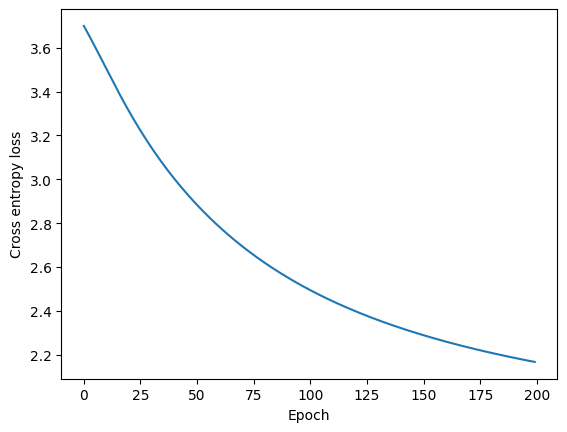

In [ ]:
mlp1_trained = train(mlp1, opt1, X_train, train_label, GRADIENT_STEPS_2)

In [ ]:
nohidden_acc = evaluate_acc(test_label, mlp1_trained.forward(X_test))
nohidden_acc

0.3690741773563859

Model 2 - An MLP with a single hidden layer having ReLU activations

In [ ]:
#Model 2 : An MLP with a single hidden layer having ReLU activations

#Multiple hidden sizes
mlp2s = [
    MLP(
        LinearLayer(i_size, hidden_size),
        ReLULayer(),
        LinearLayer(hidden_size, num_classes),
        SoftmaxOutputLayer()
    ) for hidden_size in hidden_sizes
]

#Multiple gradients
opt2s = [StochasticGradientDescentOptimizer(mlp, 1e-1) for mlp in mlp2s]

  0%|          | 1/200 [00:04<13:29,  4.07s/it]

3.6133240012117573


  1%|          | 2/200 [00:07<13:08,  3.98s/it]

3.5556239333391866


  2%|▏         | 3/200 [00:11<12:55,  3.94s/it]

3.4964290958623847


  2%|▏         | 4/200 [00:15<12:59,  3.98s/it]

3.4383004269336435


  2%|▎         | 5/200 [00:19<12:49,  3.95s/it]

3.3838906877577277


  3%|▎         | 6/200 [00:23<12:44,  3.94s/it]

3.3331285702664153


  4%|▎         | 7/200 [00:27<12:43,  3.95s/it]

3.28485190978659


  4%|▍         | 8/200 [00:31<12:47,  4.00s/it]

3.238557162950972


  4%|▍         | 9/200 [00:35<12:39,  3.98s/it]

3.1938383441517675


  5%|▌         | 10/200 [00:39<12:35,  3.97s/it]

3.15042737742367


  6%|▌         | 11/200 [00:43<12:44,  4.05s/it]

3.10828922554408


  6%|▌         | 12/200 [00:47<12:32,  4.00s/it]

3.0673785997462013


  6%|▋         | 13/200 [00:51<12:23,  3.98s/it]

3.027640931811738


  7%|▋         | 14/200 [00:55<12:23,  4.00s/it]

2.9893452756452734


  8%|▊         | 15/200 [00:59<12:16,  3.98s/it]

2.9528738730879716


  8%|▊         | 16/200 [01:03<12:08,  3.96s/it]

2.9182016124843804


  8%|▊         | 17/200 [01:07<12:08,  3.98s/it]

2.885357945250441


  9%|▉         | 18/200 [01:11<12:02,  3.97s/it]

2.8540760011874213


 10%|▉         | 19/200 [01:15<11:54,  3.95s/it]

2.8243408220058797


 10%|█         | 20/200 [01:19<11:55,  3.97s/it]

2.796026211345182


 10%|█         | 21/200 [01:23<11:55,  4.00s/it]

2.7690948615145716


 11%|█         | 22/200 [01:27<11:47,  3.97s/it]

2.7433291537690914


 12%|█▏        | 23/200 [01:31<11:41,  3.97s/it]

2.7186709978890033


 12%|█▏        | 24/200 [01:35<11:55,  4.07s/it]

2.695055084436703


 12%|█▎        | 25/200 [01:39<11:42,  4.01s/it]

2.6724544080826185


 13%|█▎        | 26/200 [01:43<11:32,  3.98s/it]

2.650750159364923


 14%|█▎        | 27/200 [01:47<11:32,  4.00s/it]

2.629878578391268


 14%|█▍        | 28/200 [01:51<11:23,  3.98s/it]

2.6098905858081665


 14%|█▍        | 29/200 [01:55<11:20,  3.98s/it]

2.5907292013945953


 15%|█▌        | 30/200 [01:59<11:19,  4.00s/it]

2.5722984593745384


 16%|█▌        | 31/200 [02:03<11:11,  3.98s/it]

2.554601668632601


 16%|█▌        | 32/200 [02:07<11:05,  3.96s/it]

2.537617144484451


 16%|█▋        | 33/200 [02:11<11:02,  3.97s/it]

2.52134217399281


 17%|█▋        | 34/200 [02:15<11:01,  3.98s/it]

2.5056768998340253


 18%|█▊        | 35/200 [02:19<10:55,  3.97s/it]

2.490603829031033


 18%|█▊        | 36/200 [02:23<10:51,  3.97s/it]

2.4761408411454564


 18%|█▊        | 37/200 [02:27<10:54,  4.02s/it]

2.4622218259764854


 19%|█▉        | 38/200 [02:31<10:45,  3.99s/it]

2.4488364274509578


 20%|█▉        | 39/200 [02:35<10:40,  3.98s/it]

2.435956674475705


 20%|██        | 40/200 [02:39<10:39,  4.00s/it]

2.4235209030792375


 20%|██        | 41/200 [02:43<10:31,  3.97s/it]

2.411509238489875


 21%|██        | 42/200 [02:47<10:23,  3.95s/it]

2.399876186034462


 22%|██▏       | 43/200 [02:51<10:21,  3.96s/it]

2.3886188094236913


 22%|██▏       | 44/200 [02:55<10:19,  3.97s/it]

2.3777391590301704


 22%|██▎       | 45/200 [02:59<10:12,  3.95s/it]

2.3672008333177836


 23%|██▎       | 46/200 [03:03<10:08,  3.95s/it]

2.356987032820629


 24%|██▎       | 47/200 [03:07<10:12,  4.01s/it]

2.3470614809043457


 24%|██▍       | 48/200 [03:11<10:05,  3.98s/it]

2.3374407908346297


 24%|██▍       | 49/200 [03:15<09:59,  3.97s/it]

2.328088974237157


 25%|██▌       | 50/200 [03:19<10:00,  4.00s/it]

2.319020243193409


 26%|██▌       | 51/200 [03:23<09:55,  4.00s/it]

2.310207099525621


 26%|██▌       | 52/200 [03:27<09:48,  3.98s/it]

2.301651567359842


 26%|██▋       | 53/200 [03:31<09:45,  3.98s/it]

2.29334395262082


 27%|██▋       | 54/200 [03:34<09:38,  3.96s/it]

2.285246450864994


 28%|██▊       | 55/200 [03:38<09:32,  3.95s/it]

2.2773463735200883


 28%|██▊       | 56/200 [03:42<09:27,  3.94s/it]

2.2696586357361275


 28%|██▊       | 57/200 [03:46<09:27,  3.97s/it]

2.2621673033776597


 29%|██▉       | 58/200 [03:50<09:23,  3.97s/it]

2.254869178850347


 30%|██▉       | 59/200 [03:54<09:18,  3.96s/it]

2.2477624262224425


 30%|███       | 60/200 [03:58<09:19,  4.00s/it]

2.240843725752217


 30%|███       | 61/200 [04:02<09:12,  3.98s/it]

2.234101748346563


 31%|███       | 62/200 [04:06<09:05,  3.95s/it]

2.227513738742548


 32%|███▏      | 63/200 [04:10<09:02,  3.96s/it]

2.2210869164599027


 32%|███▏      | 64/200 [04:14<08:55,  3.93s/it]

2.214831518454848


 32%|███▎      | 65/200 [04:18<08:50,  3.93s/it]

2.2087202971248336


 33%|███▎      | 66/200 [04:22<08:50,  3.96s/it]

2.202746176500802


 34%|███▎      | 67/200 [04:26<08:50,  3.99s/it]

2.1969193699895193


 34%|███▍      | 68/200 [04:30<08:44,  3.97s/it]

2.191219679994297


 34%|███▍      | 69/200 [04:34<08:39,  3.96s/it]

2.1856547132147592


 35%|███▌      | 70/200 [04:38<08:39,  3.99s/it]

2.1802359554925594


 36%|███▌      | 71/200 [04:42<08:31,  3.97s/it]

2.174932450158508


 36%|███▌      | 72/200 [04:46<08:26,  3.96s/it]

2.1697526989616494


 36%|███▋      | 73/200 [04:50<08:27,  4.00s/it]

2.164696556410841


 37%|███▋      | 74/200 [04:54<08:19,  3.96s/it]

2.1597470669478365


 38%|███▊      | 75/200 [04:58<08:14,  3.96s/it]

2.1548996421241786


 38%|███▊      | 76/200 [05:02<08:13,  3.98s/it]

2.150146479215168


 38%|███▊      | 77/200 [05:06<08:07,  3.96s/it]

2.1454968160034142


 39%|███▉      | 78/200 [05:10<08:01,  3.95s/it]

2.1409474324400275


 40%|███▉      | 79/200 [05:13<07:57,  3.94s/it]

2.1364896981761823


 40%|████      | 80/200 [05:17<07:57,  3.98s/it]

2.1321139783933654


 40%|████      | 81/200 [05:21<07:50,  3.96s/it]

2.1278312326699607


 41%|████      | 82/200 [05:25<07:47,  3.96s/it]

2.1236262105023225


 42%|████▏     | 83/200 [05:29<07:46,  3.99s/it]

2.119496914089937


 42%|████▏     | 84/200 [05:33<07:40,  3.97s/it]

2.115440444904795


 42%|████▎     | 85/200 [05:37<07:35,  3.96s/it]

2.1114488386703973


 43%|████▎     | 86/200 [05:41<07:33,  3.98s/it]

2.1075351149691817


 44%|████▎     | 87/200 [05:45<07:26,  3.95s/it]

2.1036848170273386


 44%|████▍     | 88/200 [05:49<07:21,  3.94s/it]

2.0999038797261225


 44%|████▍     | 89/200 [05:53<07:18,  3.95s/it]

2.096179530110619


 45%|████▌     | 90/200 [05:57<07:21,  4.01s/it]

2.092518459158986


 46%|████▌     | 91/200 [06:01<07:13,  3.98s/it]

2.088910796235811


 46%|████▌     | 92/200 [06:05<07:09,  3.98s/it]

2.085356667470772


 46%|████▋     | 93/200 [06:09<07:08,  4.00s/it]

2.0818554404138165


 47%|████▋     | 94/200 [06:13<07:00,  3.97s/it]

2.078408180538327


 48%|████▊     | 95/200 [06:17<06:55,  3.96s/it]

2.0750192992205045


 48%|████▊     | 96/200 [06:21<06:54,  3.99s/it]

2.071693748174121


 48%|████▊     | 97/200 [06:25<06:48,  3.97s/it]

2.068421765405268


 49%|████▉     | 98/200 [06:29<06:44,  3.96s/it]

2.065199889287693


 50%|████▉     | 99/200 [06:33<06:39,  3.96s/it]

2.0620243494717676


 50%|█████     | 100/200 [06:37<06:34,  3.95s/it]

2.058897906485945


 50%|█████     | 101/200 [06:41<06:29,  3.93s/it]

2.055822622089052


 51%|█████     | 102/200 [06:45<06:25,  3.94s/it]

2.0527906934127738


 52%|█████▏    | 103/200 [06:49<06:27,  4.00s/it]

2.0498022048726314


 52%|█████▏    | 104/200 [06:53<06:21,  3.97s/it]

2.046852164429615


 52%|█████▎    | 105/200 [06:57<06:17,  3.97s/it]

2.04395783965555


 53%|█████▎    | 106/200 [07:01<06:18,  4.03s/it]

2.0411017075074436


 54%|█████▎    | 107/200 [07:05<06:11,  4.00s/it]

2.0382940332511454


 54%|█████▍    | 108/200 [07:09<06:05,  3.97s/it]

2.035528544671904


 55%|█████▍    | 109/200 [07:13<06:05,  4.02s/it]

2.032799446842599


 55%|█████▌    | 110/200 [07:17<05:58,  3.99s/it]

2.030113003348482


 56%|█████▌    | 111/200 [07:21<05:52,  3.96s/it]

2.0274704481550923


 56%|█████▌    | 112/200 [07:25<05:48,  3.96s/it]

2.024872669068298


 56%|█████▋    | 113/200 [07:29<05:47,  3.99s/it]

2.022308437766666


 57%|█████▋    | 114/200 [07:33<05:40,  3.96s/it]

2.0197830893149074


 57%|█████▊    | 115/200 [07:37<05:37,  3.98s/it]

2.017299127727566


 58%|█████▊    | 116/200 [07:41<05:35,  4.00s/it]

2.014855197878192


 58%|█████▊    | 117/200 [07:45<05:29,  3.97s/it]

2.0124412612274982


 59%|█████▉    | 118/200 [07:48<05:25,  3.96s/it]

2.0100624858974934


 60%|█████▉    | 119/200 [07:53<05:23,  4.00s/it]

2.0077155298817377


 60%|██████    | 120/200 [07:56<05:17,  3.97s/it]

2.0054034538469807


 60%|██████    | 121/200 [08:00<05:12,  3.96s/it]

2.0031274082029067


 61%|██████    | 122/200 [08:04<05:09,  3.96s/it]

2.000886570786794


 62%|██████▏   | 123/200 [08:08<05:03,  3.94s/it]

1.9986852073666568


 62%|██████▏   | 124/200 [08:12<04:59,  3.94s/it]

1.9965175715304726


 62%|██████▎   | 125/200 [08:16<04:55,  3.94s/it]

1.9943746718378061


 63%|██████▎   | 126/200 [08:20<04:54,  3.97s/it]

1.9922616337061057


 64%|██████▎   | 127/200 [08:24<04:49,  3.96s/it]

1.9901768285997716


 64%|██████▍   | 128/200 [08:28<04:45,  3.97s/it]

1.9881205285582395


 64%|██████▍   | 129/200 [08:32<04:44,  4.01s/it]

1.98609803518441


 65%|██████▌   | 130/200 [08:36<04:38,  3.98s/it]

1.9841035852843825


 66%|██████▌   | 131/200 [08:40<04:33,  3.96s/it]

1.9821415154138844


 66%|██████▌   | 132/200 [08:44<04:30,  3.98s/it]

1.9802104155379374


 66%|██████▋   | 133/200 [08:48<04:25,  3.97s/it]

1.9783035773252466


 67%|██████▋   | 134/200 [08:52<04:22,  3.97s/it]

1.9764265256293698


 68%|██████▊   | 135/200 [08:56<04:18,  3.97s/it]

1.9745728743735524


 68%|██████▊   | 136/200 [09:00<04:13,  3.96s/it]

1.9727521451227026


 68%|██████▊   | 137/200 [09:04<04:08,  3.95s/it]

1.970956328299599


 69%|██████▉   | 138/200 [09:08<04:05,  3.96s/it]

1.9691854912913318


 70%|██████▉   | 139/200 [09:12<04:05,  4.03s/it]

1.9674381162522634


 70%|███████   | 140/200 [09:16<04:00,  4.00s/it]

1.9657174129517139


 70%|███████   | 141/200 [09:20<03:55,  3.99s/it]

1.9640268852487341


 71%|███████   | 142/200 [09:24<03:53,  4.03s/it]

1.9623557751932486


 72%|███████▏  | 143/200 [09:28<03:47,  3.98s/it]

1.960706413235114


 72%|███████▏  | 144/200 [09:32<03:42,  3.98s/it]

1.9590857323945035


 72%|███████▎  | 145/200 [09:36<03:39,  3.99s/it]

1.957488149062745


 73%|███████▎  | 146/200 [09:40<03:34,  3.98s/it]

1.9559155667658112


 74%|███████▎  | 147/200 [09:44<03:29,  3.95s/it]

1.9543663279469086


 74%|███████▍  | 148/200 [09:48<03:25,  3.96s/it]

1.9528343976785794


 74%|███████▍  | 149/200 [09:52<03:23,  3.99s/it]

1.9513206597085857


 75%|███████▌  | 150/200 [09:56<03:18,  3.97s/it]

1.9498328748020242


 76%|███████▌  | 151/200 [10:00<03:14,  3.98s/it]

1.9483665944848203


 76%|███████▌  | 152/200 [10:04<03:15,  4.08s/it]

1.9469177534297277


 76%|███████▋  | 153/200 [10:08<03:09,  4.03s/it]

1.9454917518864467


 77%|███████▋  | 154/200 [10:12<03:03,  4.00s/it]

1.9440885877766014


 78%|███████▊  | 155/200 [10:16<03:00,  4.01s/it]

1.942702058934384


 78%|███████▊  | 156/200 [10:20<02:55,  3.99s/it]

1.9413365153720823


 78%|███████▊  | 157/200 [10:24<02:51,  3.98s/it]

1.9399885440477733


 79%|███████▉  | 158/200 [10:28<02:47,  3.98s/it]

1.9386583088580307


 80%|███████▉  | 159/200 [10:32<02:42,  3.97s/it]

1.9373447359487654


 80%|████████  | 160/200 [10:36<02:38,  3.96s/it]

1.9360500436527512


 80%|████████  | 161/200 [10:40<02:34,  3.95s/it]

1.934768182397777


 81%|████████  | 162/200 [10:44<02:30,  3.97s/it]

1.933505696009478


 82%|████████▏ | 163/200 [10:47<02:25,  3.94s/it]

1.932255666886555


 82%|████████▏ | 164/200 [10:51<02:22,  3.96s/it]

1.9310270925577004


 82%|████████▎ | 165/200 [10:56<02:20,  4.02s/it]

1.929819026093298


 83%|████████▎ | 166/200 [10:59<02:15,  3.98s/it]

1.9286199707028462


 84%|████████▎ | 167/200 [11:03<02:11,  3.98s/it]

1.9274431887005063


 84%|████████▍ | 168/200 [11:08<02:10,  4.07s/it]

1.926285502895058


 84%|████████▍ | 169/200 [11:12<02:04,  4.03s/it]

1.9251386341570251


 85%|████████▌ | 170/200 [11:16<02:00,  4.01s/it]

1.9240084971232818


 86%|████████▌ | 171/200 [11:20<01:56,  4.01s/it]

1.922891207023176


 86%|████████▌ | 172/200 [11:24<01:51,  3.99s/it]

1.9217880622862884


 86%|████████▋ | 173/200 [11:27<01:47,  3.97s/it]

1.9207000838967454


 87%|████████▋ | 174/200 [11:31<01:43,  3.97s/it]

1.9196274028692788


 88%|████████▊ | 175/200 [11:36<01:40,  4.00s/it]

1.918564609223525


 88%|████████▊ | 176/200 [11:39<01:35,  3.98s/it]

1.9175185307370004


 88%|████████▊ | 177/200 [11:43<01:31,  3.97s/it]

1.9164802090512492


 89%|████████▉ | 178/200 [11:48<01:28,  4.01s/it]

1.9154528983295833


 90%|████████▉ | 179/200 [11:51<01:23,  3.99s/it]

1.9144332801456803


 90%|█████████ | 180/200 [11:55<01:19,  3.97s/it]

1.9134274527327966


 90%|█████████ | 181/200 [11:59<01:15,  3.98s/it]

1.9124290146368184


 91%|█████████ | 182/200 [12:03<01:11,  3.96s/it]

1.9114423849227293


 92%|█████████▏| 183/200 [12:07<01:07,  3.95s/it]

1.910465923250192


 92%|█████████▏| 184/200 [12:11<01:03,  3.94s/it]

1.909501001693238


 92%|█████████▎| 185/200 [12:15<00:59,  3.96s/it]

1.9085552205132563


 93%|█████████▎| 186/200 [12:19<00:55,  3.95s/it]

1.907622544465947


 94%|█████████▎| 187/200 [12:23<00:51,  3.97s/it]

1.9067006525906995


 94%|█████████▍| 188/200 [12:27<00:48,  4.04s/it]

1.905788524037171


 94%|█████████▍| 189/200 [12:31<00:43,  4.00s/it]

1.9048878070410382


 95%|█████████▌| 190/200 [12:35<00:39,  3.99s/it]

1.9039963442094718


 96%|█████████▌| 191/200 [12:39<00:36,  4.00s/it]

1.9031140100578585


 96%|█████████▌| 192/200 [12:43<00:31,  3.96s/it]

1.9022412754896039


 96%|█████████▋| 193/200 [12:47<00:27,  3.95s/it]

1.9013770703061845


 97%|█████████▋| 194/200 [12:51<00:23,  3.97s/it]

1.9005228555936633


 98%|█████████▊| 195/200 [12:55<00:19,  3.96s/it]

1.8996810654105505


 98%|█████████▊| 196/200 [12:59<00:15,  3.95s/it]

1.8988499756691253


 98%|█████████▊| 197/200 [13:03<00:11,  3.97s/it]

1.898032448569768


 99%|█████████▉| 198/200 [13:07<00:08,  4.04s/it]

1.8972238698392003


100%|█████████▉| 199/200 [13:11<00:03,  4.00s/it]

1.896428329526416


100%|██████████| 200/200 [13:15<00:00,  3.98s/it]

1.895643910346584
[3.6133240012117573, 3.5556239333391866, 3.4964290958623847, 3.4383004269336435, 3.3838906877577277, 3.3331285702664153, 3.28485190978659, 3.238557162950972, 3.1938383441517675, 3.15042737742367, 3.10828922554408, 3.0673785997462013, 3.027640931811738, 2.9893452756452734, 2.9528738730879716, 2.9182016124843804, 2.885357945250441, 2.8540760011874213, 2.8243408220058797, 2.796026211345182, 2.7690948615145716, 2.7433291537690914, 2.7186709978890033, 2.695055084436703, 2.6724544080826185, 2.650750159364923, 2.629878578391268, 2.6098905858081665, 2.5907292013945953, 2.5722984593745384, 2.554601668632601, 2.537617144484451, 2.52134217399281, 2.5056768998340253, 2.490603829031033, 2.4761408411454564, 2.4622218259764854, 2.4488364274509578, 2.435956674475705, 2.4235209030792375, 2.411509238489875, 2.399876186034462, 2.3886188094236913, 2.3777391590301704, 2.3672008333177836, 2.356987032820629, 2.3470614809043457, 2.3374407908346297, 2.328088974237157, 2.319020243193409, 2.310

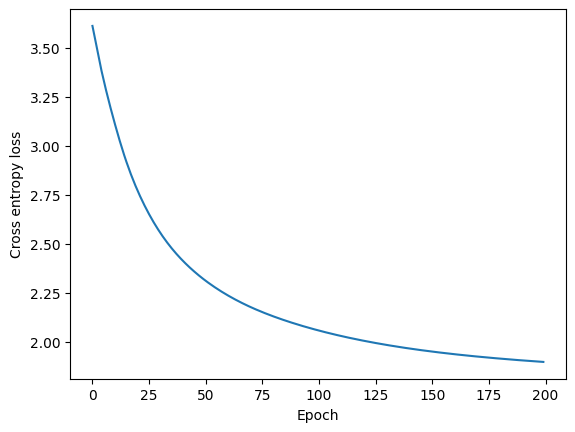

In [ ]:
mlp2_trained_32 = train(mlp2s[0], opt2s[0], X_train, train_label, GRADIENT_STEPS_2)

In [ ]:
hidden32_acc = evaluate_acc(test_label, mlp2_trained_32.forward(X_test))
hidden32_acc

0.48773006134969327

  0%|          | 1/200 [00:07<25:53,  7.81s/it]

3.6399961326080876


  1%|          | 2/200 [00:15<25:07,  7.62s/it]

3.566682892521822


  2%|▏         | 3/200 [00:22<24:42,  7.53s/it]

3.4922916986207997


  2%|▏         | 4/200 [00:30<24:38,  7.54s/it]

3.418959293985544


  2%|▎         | 5/200 [00:37<24:21,  7.50s/it]

3.349462774316872


  3%|▎         | 6/200 [00:45<24:25,  7.55s/it]

3.2841293479517093


  4%|▎         | 7/200 [00:52<24:10,  7.51s/it]

3.2229859120226525


  4%|▍         | 8/200 [01:00<24:01,  7.51s/it]

3.165477565860503


  4%|▍         | 9/200 [01:07<23:49,  7.48s/it]

3.111110541437402


  5%|▌         | 10/200 [01:15<23:33,  7.44s/it]

3.0596317458469096


  6%|▌         | 11/200 [01:22<23:27,  7.44s/it]

3.010784642392139


  6%|▌         | 12/200 [01:30<23:23,  7.47s/it]

2.9645816822335442


  6%|▋         | 13/200 [01:37<23:28,  7.53s/it]

2.920937838201838


  7%|▋         | 14/200 [01:45<23:19,  7.53s/it]

2.8796682802343834


  8%|▊         | 15/200 [01:52<23:08,  7.50s/it]

2.8407140989524335


  8%|▊         | 16/200 [02:00<22:59,  7.50s/it]

2.803830955801455


  8%|▊         | 17/200 [02:07<22:57,  7.53s/it]

2.7688185780392716


  9%|▉         | 18/200 [02:15<22:51,  7.54s/it]

2.735409771485867


 10%|▉         | 19/200 [02:22<22:38,  7.50s/it]

2.7035470277138693


 10%|█         | 20/200 [02:30<22:30,  7.50s/it]

2.673128437066461


 10%|█         | 21/200 [02:37<22:19,  7.48s/it]

2.6441664995936036


 11%|█         | 22/200 [02:45<22:09,  7.47s/it]

2.616609053222823


 12%|█▏        | 23/200 [02:52<21:59,  7.46s/it]

2.5903307649469975


 12%|█▏        | 24/200 [03:00<21:53,  7.46s/it]

2.56524369312087


 12%|█▎        | 25/200 [03:07<21:52,  7.50s/it]

2.5412301516512086


 13%|█▎        | 26/200 [03:15<21:44,  7.50s/it]

2.518201176510975


 14%|█▎        | 27/200 [03:22<21:36,  7.49s/it]

2.4960836777350135


 14%|█▍        | 28/200 [03:30<21:28,  7.49s/it]

2.4748494027397316


 14%|█▍        | 29/200 [03:37<21:17,  7.47s/it]

2.4543576863997494


 15%|█▌        | 30/200 [03:45<21:11,  7.48s/it]

2.4345757777154406


 16%|█▌        | 31/200 [03:52<21:02,  7.47s/it]

2.4154703036442013


 16%|█▌        | 32/200 [04:00<21:12,  7.58s/it]

2.397040705525411


 16%|█▋        | 33/200 [04:07<20:59,  7.54s/it]

2.3792645136662323


 17%|█▋        | 34/200 [04:15<20:43,  7.49s/it]

2.3621000041741262


 18%|█▊        | 35/200 [04:22<20:37,  7.50s/it]

2.3454959057513567


 18%|█▊        | 36/200 [04:30<20:33,  7.52s/it]

2.329425396159433


 18%|█▊        | 37/200 [04:37<20:26,  7.52s/it]

2.3138948219443014


 19%|█▉        | 38/200 [04:45<20:14,  7.50s/it]

2.2989344038390693


 20%|█▉        | 39/200 [04:52<20:01,  7.46s/it]

2.284456973294018


 20%|██        | 40/200 [05:00<19:59,  7.50s/it]

2.2704556193920817


 20%|██        | 41/200 [05:07<19:46,  7.46s/it]

2.2569093157051197


 21%|██        | 42/200 [05:14<19:39,  7.47s/it]

2.2438314192974054


 22%|██▏       | 43/200 [05:22<19:28,  7.45s/it]

2.2311473090036067


 22%|██▏       | 44/200 [05:29<19:26,  7.48s/it]

2.2188741761450745


 22%|██▎       | 45/200 [05:37<19:16,  7.46s/it]

2.207000832007171


 23%|██▎       | 46/200 [05:44<19:04,  7.43s/it]

2.195486709309275


 24%|██▎       | 47/200 [05:52<18:56,  7.43s/it]

2.184305380972981


 24%|██▍       | 48/200 [05:59<18:48,  7.42s/it]

2.1734411188442357


 24%|██▍       | 49/200 [06:07<18:51,  7.49s/it]

2.1628712340675267


 25%|██▌       | 50/200 [06:14<18:38,  7.46s/it]

2.152579640758853


 26%|██▌       | 51/200 [06:22<18:34,  7.48s/it]

2.1425550858854687


 26%|██▌       | 52/200 [06:29<18:24,  7.46s/it]

2.1327949369471075


 26%|██▋       | 53/200 [06:36<18:11,  7.42s/it]

2.123301246217846


 27%|██▋       | 54/200 [06:44<18:04,  7.43s/it]

2.1140388170601123


 28%|██▊       | 55/200 [06:51<17:53,  7.41s/it]

2.105013266723102


 28%|██▊       | 56/200 [06:59<17:54,  7.46s/it]

2.096220012005506


 28%|██▊       | 57/200 [07:06<17:46,  7.46s/it]

2.0876420415871233


 29%|██▉       | 58/200 [07:14<17:37,  7.45s/it]

2.0792831898421493


 30%|██▉       | 59/200 [07:21<17:25,  7.42s/it]

2.071132533804125


 30%|███       | 60/200 [07:28<17:14,  7.39s/it]

2.0631831228605315


 30%|███       | 61/200 [07:36<17:20,  7.49s/it]

2.0554388712936804


 31%|███       | 62/200 [07:43<17:09,  7.46s/it]

2.047900196208227


 32%|███▏      | 63/200 [07:51<17:00,  7.45s/it]

2.0405408656999455


 32%|███▏      | 64/200 [07:58<16:52,  7.44s/it]

2.0333579616031496


 32%|███▎      | 65/200 [08:06<16:41,  7.42s/it]

2.0263578185221656


 33%|███▎      | 66/200 [08:13<16:34,  7.42s/it]

2.019504231478192


 34%|███▎      | 67/200 [08:20<16:26,  7.42s/it]

2.01280464227166


 34%|███▍      | 68/200 [08:28<16:23,  7.45s/it]

2.0062568636506546


 34%|███▍      | 69/200 [08:35<16:15,  7.45s/it]

1.99985876767489


 35%|███▌      | 70/200 [08:43<16:03,  7.41s/it]

1.993609738402535


 36%|███▌      | 71/200 [08:50<15:55,  7.41s/it]

1.9874984950916805


 36%|███▌      | 72/200 [08:57<15:43,  7.37s/it]

1.981530379033171


 36%|███▋      | 73/200 [09:05<15:43,  7.43s/it]

1.9757035280041277


 37%|███▋      | 74/200 [09:12<15:37,  7.44s/it]

1.9700084337034758


 38%|███▊      | 75/200 [09:20<15:46,  7.57s/it]

1.9644548084812201


 38%|███▊      | 76/200 [09:28<15:41,  7.59s/it]

1.9590306722172162


 38%|███▊      | 77/200 [09:36<15:31,  7.57s/it]

1.953728020607818


 39%|███▉      | 78/200 [09:43<15:23,  7.57s/it]

1.9485462396801387


 40%|███▉      | 79/200 [09:51<15:17,  7.58s/it]

1.9434834114160027


 40%|████      | 80/200 [09:58<15:12,  7.60s/it]

1.9385441955801803


 40%|████      | 81/200 [10:06<15:01,  7.58s/it]

1.9337175710324352


 41%|████      | 82/200 [10:13<14:46,  7.51s/it]

1.9289909678324881


 42%|████▏     | 83/200 [10:21<14:37,  7.50s/it]

1.9243622051219955


 42%|████▏     | 84/200 [10:28<14:26,  7.47s/it]

1.9198585428345991


 42%|████▎     | 85/200 [10:36<14:28,  7.55s/it]

1.915452347742924


 43%|████▎     | 86/200 [10:43<14:16,  7.51s/it]

1.911153778061271


 44%|████▎     | 87/200 [10:51<14:08,  7.51s/it]

1.906956410006165


 44%|████▍     | 88/200 [10:58<13:58,  7.48s/it]

1.9028542304415819


 44%|████▍     | 89/200 [11:06<13:47,  7.46s/it]

1.898833117302485


 45%|████▌     | 90/200 [11:13<13:41,  7.47s/it]

1.8948953727803093


 46%|████▌     | 91/200 [11:20<13:30,  7.44s/it]

1.8910315252337797


 46%|████▌     | 92/200 [11:28<13:30,  7.51s/it]

1.8872427305730335


 46%|████▋     | 93/200 [11:36<13:22,  7.50s/it]

1.8835428336793494


 47%|████▋     | 94/200 [11:43<13:09,  7.45s/it]

1.8799233593529792


 48%|████▊     | 95/200 [11:50<13:03,  7.46s/it]

1.8763773250933091


 48%|████▊     | 96/200 [11:58<12:54,  7.45s/it]

1.8728983138131616


 48%|████▊     | 97/200 [12:05<12:49,  7.47s/it]

1.8694942222214985


 49%|████▉     | 98/200 [12:13<12:40,  7.45s/it]

1.8661553753929025


 50%|████▉     | 99/200 [12:20<12:32,  7.45s/it]

1.8628714017702852


 50%|█████     | 100/200 [12:28<12:26,  7.46s/it]

1.8596462849113937


 50%|█████     | 101/200 [12:35<12:16,  7.44s/it]

1.8564807160146126


 51%|█████     | 102/200 [12:43<12:08,  7.44s/it]

1.8533752461664061


 52%|█████▏    | 103/200 [12:50<11:59,  7.42s/it]

1.850330844183097


 52%|█████▏    | 104/200 [12:58<12:00,  7.51s/it]

1.8473434083726943


 52%|█████▎    | 105/200 [13:05<11:52,  7.50s/it]

1.8444102860118652


 53%|█████▎    | 106/200 [13:13<11:42,  7.47s/it]

1.8415362658567096


 54%|█████▎    | 107/200 [13:20<11:33,  7.46s/it]

1.83870874986821


 54%|█████▍    | 108/200 [13:27<11:24,  7.44s/it]

1.8359428149310881


 55%|█████▍    | 109/200 [13:35<11:16,  7.43s/it]

1.833225703013984


 55%|█████▌    | 110/200 [13:42<11:08,  7.43s/it]

1.830556016756517


 56%|█████▌    | 111/200 [13:50<11:03,  7.46s/it]

1.8279317329648794


 56%|█████▌    | 112/200 [13:57<10:55,  7.45s/it]

1.825348578233836


 56%|█████▋    | 113/200 [14:04<10:45,  7.42s/it]

1.8228041479066723


 57%|█████▋    | 114/200 [14:12<10:37,  7.41s/it]

1.8203097770379582


 57%|█████▊    | 115/200 [14:19<10:30,  7.41s/it]

1.81785631359639


 58%|█████▊    | 116/200 [14:27<10:25,  7.45s/it]

1.8154319493223192


 58%|█████▊    | 117/200 [14:34<10:19,  7.47s/it]

1.8130406586259915


 59%|█████▉    | 118/200 [14:42<10:14,  7.49s/it]

1.8106899802096716


 60%|█████▉    | 119/200 [14:49<10:04,  7.46s/it]

1.8083855091559644


 60%|██████    | 120/200 [14:57<09:54,  7.43s/it]

1.806116353920201


 60%|██████    | 121/200 [15:04<09:47,  7.44s/it]

1.8038847747218552


 61%|██████    | 122/200 [15:12<09:39,  7.43s/it]

1.8016884870732415


 62%|██████▏   | 123/200 [15:19<09:34,  7.46s/it]

1.799521656772858


 62%|██████▏   | 124/200 [15:27<09:27,  7.47s/it]

1.797393579657326


 62%|██████▎   | 125/200 [15:34<09:16,  7.42s/it]

1.795299590879646


 63%|██████▎   | 126/200 [15:41<09:09,  7.42s/it]

1.7932389198417387


 64%|██████▎   | 127/200 [15:49<09:01,  7.42s/it]

1.7912118099598324


 64%|██████▍   | 128/200 [15:56<09:00,  7.50s/it]

1.7892130555378316


 64%|██████▍   | 129/200 [16:04<08:51,  7.48s/it]

1.7872465311605084


 65%|██████▌   | 130/200 [16:11<08:47,  7.54s/it]

1.785317609771177


 66%|██████▌   | 131/200 [16:19<08:38,  7.51s/it]

1.7834225801586496


 66%|██████▌   | 132/200 [16:26<08:28,  7.48s/it]

1.7815557622382887


 66%|██████▋   | 133/200 [16:34<08:21,  7.49s/it]

1.7797181549724725


 67%|██████▋   | 134/200 [16:41<08:13,  7.48s/it]

1.7779052684169205


 68%|██████▊   | 135/200 [16:49<08:07,  7.50s/it]

1.7761183812038759


 68%|██████▊   | 136/200 [16:56<08:00,  7.50s/it]

1.7743608938422506


 68%|██████▊   | 137/200 [17:04<07:49,  7.46s/it]

1.7726300241439308


 69%|██████▉   | 138/200 [17:11<07:42,  7.46s/it]

1.7709252856043611


 70%|██████▉   | 139/200 [17:19<07:33,  7.43s/it]

1.7692377240936725


 70%|███████   | 140/200 [17:26<07:26,  7.45s/it]

1.7675729961451243


 70%|███████   | 141/200 [17:33<07:19,  7.46s/it]

1.7659345899668326


 71%|███████   | 142/200 [17:41<07:15,  7.51s/it]

1.7643205528055408


 72%|███████▏  | 143/200 [17:49<07:06,  7.47s/it]

1.762734336595382


 72%|███████▏  | 144/200 [17:56<06:57,  7.45s/it]

1.7611770356293157


 72%|███████▎  | 145/200 [18:03<06:50,  7.45s/it]

1.759639698579268


 73%|███████▎  | 146/200 [18:11<06:43,  7.46s/it]

1.7581263022437872


 74%|███████▎  | 147/200 [18:18<06:37,  7.50s/it]

1.756637197073133


 74%|███████▍  | 148/200 [18:26<06:29,  7.50s/it]

1.7551737485103691


 74%|███████▍  | 149/200 [18:33<06:20,  7.46s/it]

1.7537348711019773


 75%|███████▌  | 150/200 [18:41<06:12,  7.45s/it]

1.752317251149657


 76%|███████▌  | 151/200 [18:48<06:03,  7.42s/it]

1.7509207043885433


 76%|███████▌  | 152/200 [18:56<05:56,  7.43s/it]

1.749542094448258


 76%|███████▋  | 153/200 [19:03<05:49,  7.43s/it]

1.7481787847746564


 77%|███████▋  | 154/200 [19:11<05:44,  7.48s/it]

1.7468289166448887


 78%|███████▊  | 155/200 [19:18<05:35,  7.46s/it]

1.7455001616560966


 78%|███████▊  | 156/200 [19:25<05:27,  7.43s/it]

1.7441896733582118


 78%|███████▊  | 157/200 [19:33<05:19,  7.43s/it]

1.7428963608836199


 79%|███████▉  | 158/200 [19:40<05:12,  7.44s/it]

1.7416187677344903


 80%|███████▉  | 159/200 [19:48<05:07,  7.51s/it]

1.7403551480050232


 80%|████████  | 160/200 [19:55<05:00,  7.51s/it]

1.7391026927317292


 80%|████████  | 161/200 [20:03<04:51,  7.47s/it]

1.7378635439803118


 81%|████████  | 162/200 [20:10<04:44,  7.48s/it]

1.7366401898531705


 82%|████████▏ | 163/200 [20:18<04:36,  7.46s/it]

1.7354283128523638


 82%|████████▏ | 164/200 [20:25<04:29,  7.48s/it]

1.7342293103526984


 82%|████████▎ | 165/200 [20:33<04:21,  7.48s/it]

1.7330398073230993


 83%|████████▎ | 166/200 [20:40<04:16,  7.53s/it]

1.7318728137049593


 84%|████████▎ | 167/200 [20:48<04:07,  7.51s/it]

1.7307221227976974


 84%|████████▍ | 168/200 [20:55<03:59,  7.48s/it]

1.7295864714050968


 84%|████████▍ | 169/200 [21:03<03:52,  7.49s/it]

1.7284695116493658


 85%|████████▌ | 170/200 [21:10<03:44,  7.47s/it]

1.727367607615654


 86%|████████▌ | 171/200 [21:18<03:37,  7.50s/it]

1.7262822112416334


 86%|████████▌ | 172/200 [21:25<03:30,  7.52s/it]

1.725206734184713


 86%|████████▋ | 173/200 [21:33<03:22,  7.49s/it]

1.7241461441188581


 87%|████████▋ | 174/200 [21:40<03:14,  7.49s/it]

1.723097647698081


 88%|████████▊ | 175/200 [21:48<03:07,  7.49s/it]

1.7220558990992447


 88%|████████▊ | 176/200 [21:55<03:00,  7.52s/it]

1.7210236049402876


 88%|████████▊ | 177/200 [22:03<02:52,  7.52s/it]

1.7200091277846339


 89%|████████▉ | 178/200 [22:10<02:45,  7.51s/it]

1.7190018054996294


 90%|████████▉ | 179/200 [22:18<02:37,  7.50s/it]

1.7180019610656427


 90%|█████████ | 180/200 [22:25<02:29,  7.49s/it]

1.7170092931112562


 90%|█████████ | 181/200 [22:33<02:22,  7.48s/it]

1.716030735500254


 91%|█████████ | 182/200 [22:40<02:14,  7.47s/it]

1.7150665934297888


 92%|█████████▏| 183/200 [22:48<02:08,  7.54s/it]

1.7141140182733885


 92%|█████████▏| 184/200 [22:55<02:00,  7.54s/it]

1.7131733707798011


 92%|█████████▎| 185/200 [23:03<01:52,  7.50s/it]

1.7122393956990694


 93%|█████████▎| 186/200 [23:10<01:44,  7.49s/it]

1.7113162655826841


 94%|█████████▎| 187/200 [23:18<01:37,  7.49s/it]

1.7104049179560001


 94%|█████████▍| 188/200 [23:26<01:31,  7.62s/it]

1.7095033039881558


 94%|█████████▍| 189/200 [23:33<01:23,  7.57s/it]

1.7086153149458785


 95%|█████████▌| 190/200 [23:41<01:15,  7.55s/it]

1.7077399018448567


 96%|█████████▌| 191/200 [23:48<01:07,  7.53s/it]

1.7068753653320712


 96%|█████████▌| 192/200 [23:56<00:59,  7.50s/it]

1.7060182241339141


 96%|█████████▋| 193/200 [24:03<00:52,  7.49s/it]

1.7051678471887393


 97%|█████████▋| 194/200 [24:10<00:44,  7.46s/it]

1.704328206988044


 98%|█████████▊| 195/200 [24:18<00:37,  7.48s/it]

1.7034966293739717


 98%|█████████▊| 196/200 [24:26<00:30,  7.51s/it]

1.702674759733231


 98%|█████████▊| 197/200 [24:33<00:22,  7.48s/it]

1.7018607705539475


 99%|█████████▉| 198/200 [24:40<00:14,  7.46s/it]

1.7010546498353842


100%|█████████▉| 199/200 [24:48<00:07,  7.45s/it]

1.7002572985327356


100%|██████████| 200/200 [24:55<00:00,  7.48s/it]

1.6994681783145726
[3.6399961326080876, 3.566682892521822, 3.4922916986207997, 3.418959293985544, 3.349462774316872, 3.2841293479517093, 3.2229859120226525, 3.165477565860503, 3.111110541437402, 3.0596317458469096, 3.010784642392139, 2.9645816822335442, 2.920937838201838, 2.8796682802343834, 2.8407140989524335, 2.803830955801455, 2.7688185780392716, 2.735409771485867, 2.7035470277138693, 2.673128437066461, 2.6441664995936036, 2.616609053222823, 2.5903307649469975, 2.56524369312087, 2.5412301516512086, 2.518201176510975, 2.4960836777350135, 2.4748494027397316, 2.4543576863997494, 2.4345757777154406, 2.4154703036442013, 2.397040705525411, 2.3792645136662323, 2.3621000041741262, 2.3454959057513567, 2.329425396159433, 2.3138948219443014, 2.2989344038390693, 2.284456973294018, 2.2704556193920817, 2.2569093157051197, 2.2438314192974054, 2.2311473090036067, 2.2188741761450745, 2.207000832007171, 2.195486709309275, 2.184305380972981, 2.1734411188442357, 2.1628712340675267, 2.152579640758853, 2

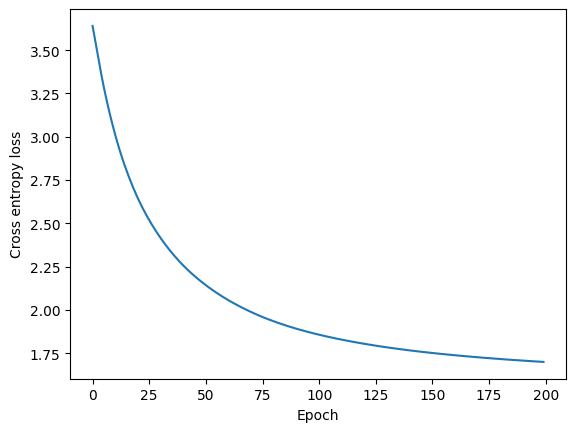

In [ ]:
mlp2_trained_64 = train(mlp2s[1], opt2s[1], X_train, train_label, GRADIENT_STEPS_2)

In [ ]:
hidden64_acc = evaluate_acc(test_label, mlp2_trained_64.forward(X_test))
hidden64_acc

0.5288622420524262

128, 256 Hidden layers proved to be too challenging for our implementation and Google Collab

In [ ]:
#mlp2_trained_128 = train(mlp2s[2], opt2s[2], X_train, train_label, GRADIENT_STEPS) #crashed on first attempt

In [ ]:
#mlp2_trained_256 = train(mlp2s[3], opt2s[3], X_train, train_label, GRADIENT_STEPS)

Model 3 - An MLP with 2 hidden layers having ReLU activations

In [ ]:
mlp3s = [
    MLP(
        LinearLayer(i_size, hidden_size),
        ReLULayer(),
        LinearLayer(hidden_size, hidden_size),  # second hidden layer
        ReLULayer(),
        LinearLayer(hidden_size, num_classes),
        SoftmaxOutputLayer()
    ) for hidden_size in hidden_sizes
]


opt3s = [StochasticGradientDescentOptimizer(mlp, 1e-1) for mlp in mlp3s]

  0%|          | 1/200 [00:04<14:05,  4.25s/it]

3.726931849849035


  1%|          | 2/200 [00:08<13:48,  4.18s/it]

3.54155553299


  2%|▏         | 3/200 [00:12<13:43,  4.18s/it]

3.381866768287519


  2%|▏         | 4/200 [00:16<13:44,  4.21s/it]

3.254298006324636


  2%|▎         | 5/200 [00:21<13:48,  4.25s/it]

3.137763862297356


  3%|▎         | 6/200 [00:25<13:41,  4.23s/it]

3.035151488019497


  4%|▎         | 7/200 [00:29<13:42,  4.26s/it]

2.9447324822596594


  4%|▍         | 8/200 [00:33<13:36,  4.25s/it]

2.865297126194699


  4%|▍         | 9/200 [00:38<13:29,  4.24s/it]

2.7964836573448606


  5%|▌         | 10/200 [00:42<13:27,  4.25s/it]

2.7348758679532112


  6%|▌         | 11/200 [00:46<13:24,  4.26s/it]

2.681169715725969


  6%|▌         | 12/200 [00:50<13:17,  4.24s/it]

2.63187701579078


  6%|▋         | 13/200 [00:55<13:14,  4.25s/it]

2.5876589085913353


  7%|▋         | 14/200 [00:59<13:14,  4.27s/it]

2.5473589376834993


  8%|▊         | 15/200 [01:03<13:06,  4.25s/it]

2.5112982276466838


  8%|▊         | 16/200 [01:07<13:01,  4.25s/it]

2.4781393274926256


  8%|▊         | 17/200 [01:12<12:59,  4.26s/it]

2.447951436293842


  9%|▉         | 18/200 [01:16<12:49,  4.23s/it]

2.4200999263724223


 10%|▉         | 19/200 [01:20<12:47,  4.24s/it]

2.3944518497828855


 10%|█         | 20/200 [01:24<12:46,  4.26s/it]

2.3706020235269625


 10%|█         | 21/200 [01:29<12:38,  4.24s/it]

2.348718735531539


 11%|█         | 22/200 [01:33<12:31,  4.22s/it]

2.3281623175974904


 12%|█▏        | 23/200 [01:37<12:37,  4.28s/it]

2.309119016886441


 12%|█▏        | 24/200 [01:41<12:29,  4.26s/it]

2.2915051700093856


 12%|█▎        | 25/200 [01:46<12:23,  4.25s/it]

2.2752068966093786


 13%|█▎        | 26/200 [01:50<12:26,  4.29s/it]

2.259981324999102


 14%|█▎        | 27/200 [01:54<12:18,  4.27s/it]

2.245974226012937


 14%|█▍        | 28/200 [01:58<12:10,  4.25s/it]

2.232847891245692


 14%|█▍        | 29/200 [02:03<12:12,  4.28s/it]

2.2207691028016274


 15%|█▌        | 30/200 [02:07<12:04,  4.26s/it]

2.2091738400502066


 16%|█▌        | 31/200 [02:11<11:57,  4.25s/it]

2.1985268278995416


 16%|█▌        | 32/200 [02:15<11:53,  4.24s/it]

2.1882864079914945


 16%|█▋        | 33/200 [02:20<11:47,  4.24s/it]

2.179064723616138


 17%|█▋        | 34/200 [02:24<11:41,  4.23s/it]

2.170229148143504


 18%|█▊        | 35/200 [02:28<11:42,  4.25s/it]

2.1622069400311785


 18%|█▊        | 36/200 [02:32<11:35,  4.24s/it]

2.154517223545017


 18%|█▊        | 37/200 [02:37<11:34,  4.26s/it]

2.147505354035448


 19%|█▉        | 38/200 [02:41<11:30,  4.26s/it]

2.1407405486011726


 20%|█▉        | 39/200 [02:45<11:26,  4.26s/it]

2.1345841783944763


 20%|██        | 40/200 [02:49<11:18,  4.24s/it]

2.1288697585147833


 20%|██        | 41/200 [02:54<11:19,  4.27s/it]

2.123602101537246


 21%|██        | 42/200 [02:58<11:15,  4.27s/it]

2.1188924807011627


 22%|██▏       | 43/200 [03:02<11:09,  4.26s/it]

2.114706650917552


 22%|██▏       | 44/200 [03:07<11:06,  4.27s/it]

2.1106816833647266


 22%|██▎       | 45/200 [03:11<11:00,  4.26s/it]

2.1071558276571594


 23%|██▎       | 46/200 [03:15<10:52,  4.24s/it]

2.1039812158827287


 24%|██▎       | 47/200 [03:19<10:53,  4.27s/it]

2.1009693016205913


 24%|██▍       | 48/200 [03:24<10:51,  4.29s/it]

2.098444225515345


 24%|██▍       | 49/200 [03:28<10:43,  4.26s/it]

2.0959403395472185


 25%|██▌       | 50/200 [03:32<10:40,  4.27s/it]

2.0938268760556635


 26%|██▌       | 51/200 [03:37<10:38,  4.29s/it]

2.09189542544846


 26%|██▌       | 52/200 [03:41<10:31,  4.27s/it]

2.0901780883777272


 26%|██▋       | 53/200 [03:45<10:29,  4.28s/it]

2.0887955229426014


 27%|██▋       | 54/200 [03:49<10:27,  4.30s/it]

2.0874474536739047


 28%|██▊       | 55/200 [03:54<10:21,  4.29s/it]

2.0864124017272365


 28%|██▊       | 56/200 [03:58<10:17,  4.29s/it]

2.0854839967715444


 28%|██▊       | 57/200 [04:02<10:16,  4.31s/it]

2.084828066436011


 29%|██▉       | 58/200 [04:07<10:09,  4.29s/it]

2.084323440259797


 30%|██▉       | 59/200 [04:11<10:05,  4.30s/it]

2.0840004430024908


 30%|███       | 60/200 [04:15<10:02,  4.30s/it]

2.0838196463144745


 30%|███       | 61/200 [04:19<09:54,  4.28s/it]

2.083872908371931


 31%|███       | 62/200 [04:24<09:53,  4.30s/it]

2.0840310161749755


 32%|███▏      | 63/200 [04:28<09:53,  4.33s/it]

2.0842809075319386


 32%|███▏      | 64/200 [04:32<09:42,  4.28s/it]

2.084626173634393


 32%|███▎      | 65/200 [04:37<09:38,  4.29s/it]

2.085012796288923


 33%|███▎      | 66/200 [04:41<09:51,  4.41s/it]

2.0855809007304753


 34%|███▎      | 67/200 [04:46<09:40,  4.37s/it]

2.0861812970446127


 34%|███▍      | 68/200 [04:50<09:31,  4.33s/it]

2.0868613191395236


 34%|███▍      | 69/200 [04:54<09:29,  4.35s/it]

2.087728292227378


 35%|███▌      | 70/200 [04:58<09:22,  4.33s/it]

2.088654839859226


 36%|███▌      | 71/200 [05:03<09:18,  4.33s/it]

2.08968925017065


 36%|███▌      | 72/200 [05:07<09:13,  4.32s/it]

2.09085434255836


 36%|███▋      | 73/200 [05:11<09:05,  4.30s/it]

2.092081800297377


 37%|███▋      | 74/200 [05:16<08:59,  4.29s/it]

2.0933368463169892


 38%|███▊      | 75/200 [05:20<09:03,  4.35s/it]

2.094636115842351


 38%|███▊      | 76/200 [05:24<08:55,  4.32s/it]

2.096022177293873


 38%|███▊      | 77/200 [05:29<08:49,  4.31s/it]

2.097431236041097


 39%|███▉      | 78/200 [05:33<08:47,  4.32s/it]

2.0988459328016384


 40%|███▉      | 79/200 [05:37<08:41,  4.31s/it]

2.100366775183269


 40%|████      | 80/200 [05:42<08:33,  4.28s/it]

2.101950300217763


 40%|████      | 81/200 [05:46<08:37,  4.35s/it]

2.1035801713555964


 41%|████      | 82/200 [05:50<08:27,  4.30s/it]

2.1052549924440447


 42%|████▏     | 83/200 [05:55<08:23,  4.30s/it]

2.1069633269592534


 42%|████▏     | 84/200 [05:59<08:19,  4.30s/it]

2.108757434900189


 42%|████▎     | 85/200 [06:03<08:12,  4.29s/it]

2.110567395062391


 43%|████▎     | 86/200 [06:07<08:05,  4.26s/it]

2.1123762323928434


 44%|████▎     | 87/200 [06:12<08:02,  4.27s/it]

2.114185149052309


 44%|████▍     | 88/200 [06:16<07:56,  4.25s/it]

2.1160517705975246


 44%|████▍     | 89/200 [06:20<07:54,  4.27s/it]

2.117942719150022


 45%|████▌     | 90/200 [06:24<07:54,  4.31s/it]

2.1198890416230896


 46%|████▌     | 91/200 [06:29<07:48,  4.30s/it]

2.1218721700116197


 46%|████▌     | 92/200 [06:33<07:42,  4.29s/it]

2.1238795670369064


 46%|████▋     | 93/200 [06:37<07:39,  4.30s/it]

2.12593953719358


 47%|████▋     | 94/200 [06:42<07:33,  4.27s/it]

2.128080419002692


 48%|████▊     | 95/200 [06:46<07:26,  4.26s/it]

2.130239919224032


 48%|████▊     | 96/200 [06:50<07:23,  4.27s/it]

2.13238645152814


 48%|████▊     | 97/200 [06:54<07:18,  4.26s/it]

2.1345369298724726


 49%|████▉     | 98/200 [06:59<07:14,  4.26s/it]

2.1366443339752594


 50%|████▉     | 99/200 [07:03<07:13,  4.29s/it]

2.1388466189287767


 50%|█████     | 100/200 [07:07<07:09,  4.29s/it]

2.1411037829962583


 50%|█████     | 101/200 [07:11<07:03,  4.28s/it]

2.143417822952289


 51%|█████     | 102/200 [07:16<06:59,  4.28s/it]

2.1457329732087103


 52%|█████▏    | 103/200 [07:20<06:58,  4.32s/it]

2.148081003470272


 52%|█████▏    | 104/200 [07:24<06:51,  4.29s/it]

2.150411662309857


 52%|█████▎    | 105/200 [07:29<06:49,  4.31s/it]

2.1527801316393456


 53%|█████▎    | 106/200 [07:33<06:45,  4.31s/it]

2.1551815321823677


 54%|█████▎    | 107/200 [07:37<06:38,  4.29s/it]

2.1576340434943666


 54%|█████▍    | 108/200 [07:42<06:33,  4.28s/it]

2.160090750672991


 55%|█████▍    | 109/200 [07:46<06:34,  4.34s/it]

2.162509144874547


 55%|█████▌    | 110/200 [07:50<06:26,  4.29s/it]

2.164991293922771


 56%|█████▌    | 111/200 [07:54<06:21,  4.29s/it]

2.167473377985557


 56%|█████▌    | 112/200 [07:59<06:19,  4.31s/it]

2.169904931329659


 56%|█████▋    | 113/200 [08:03<06:15,  4.31s/it]

2.1723650719225627


 57%|█████▋    | 114/200 [08:07<06:10,  4.31s/it]

2.1748365394960194


 57%|█████▊    | 115/200 [08:12<06:06,  4.31s/it]

2.1773025000696236


 58%|█████▊    | 116/200 [08:16<06:00,  4.29s/it]

2.1797689665505233


 58%|█████▊    | 117/200 [08:20<05:57,  4.30s/it]

2.1822573545490855


 59%|█████▉    | 118/200 [08:25<05:56,  4.35s/it]

2.1847811235298726


 60%|█████▉    | 119/200 [08:29<05:51,  4.34s/it]

2.1872989367871223


 60%|██████    | 120/200 [08:33<05:46,  4.33s/it]

2.189843944029


 60%|██████    | 121/200 [08:38<05:48,  4.41s/it]

2.1923922715855326


 61%|██████    | 122/200 [08:42<05:38,  4.34s/it]

2.194978027079626


 62%|██████▏   | 123/200 [08:47<05:33,  4.33s/it]

2.197539387857429


 62%|██████▏   | 124/200 [08:51<05:36,  4.43s/it]

2.2001314812052524


 62%|██████▎   | 125/200 [08:55<05:28,  4.38s/it]

2.2027225380395756


 63%|██████▎   | 126/200 [09:00<05:22,  4.36s/it]

2.2053193988272364


 64%|██████▎   | 127/200 [09:04<05:20,  4.40s/it]

2.207920970925505


 64%|██████▍   | 128/200 [09:08<05:13,  4.35s/it]

2.2105000296877213


 64%|██████▍   | 129/200 [09:13<05:08,  4.34s/it]

2.213073210954056


 65%|██████▌   | 130/200 [09:17<05:05,  4.37s/it]

2.2156028035514574


 66%|██████▌   | 131/200 [09:22<04:59,  4.35s/it]

2.2181022161395982


 66%|██████▌   | 132/200 [09:26<04:56,  4.36s/it]

2.220592130027702


 66%|██████▋   | 133/200 [09:30<04:53,  4.38s/it]

2.2230637582456505


 67%|██████▋   | 134/200 [09:35<04:45,  4.33s/it]

2.2255156940829375


 68%|██████▊   | 135/200 [09:39<04:40,  4.32s/it]

2.22798680614521


 68%|██████▊   | 136/200 [09:43<04:41,  4.39s/it]

2.2304282002795777


 68%|██████▊   | 137/200 [09:48<04:34,  4.36s/it]

2.2328481029298093


 69%|██████▉   | 138/200 [09:52<04:27,  4.32s/it]

2.235271421577159


 70%|██████▉   | 139/200 [09:56<04:24,  4.34s/it]

2.2376796537691233


 70%|███████   | 140/200 [10:01<04:18,  4.31s/it]

2.240076544214741


 70%|███████   | 141/200 [10:05<04:13,  4.30s/it]

2.24244557718328


 71%|███████   | 142/200 [10:09<04:10,  4.32s/it]

2.244833338790957


 72%|███████▏  | 143/200 [10:13<04:04,  4.29s/it]

2.2471984259758


 72%|███████▏  | 144/200 [10:18<03:59,  4.28s/it]

2.2495696897347197


 72%|███████▎  | 145/200 [10:22<03:56,  4.30s/it]

2.251944024434233


 73%|███████▎  | 146/200 [10:26<03:50,  4.28s/it]

2.2543053467486738


 74%|███████▎  | 147/200 [10:31<03:46,  4.27s/it]

2.2566675989331717


 74%|███████▍  | 148/200 [10:35<03:42,  4.29s/it]

2.259047610739799


 74%|███████▍  | 149/200 [10:39<03:38,  4.29s/it]

2.261395912170164


 75%|███████▌  | 150/200 [10:43<03:33,  4.28s/it]

2.2637299769538037


 76%|███████▌  | 151/200 [10:48<03:30,  4.29s/it]

2.266065749885219


 76%|███████▌  | 152/200 [10:52<03:25,  4.27s/it]

2.2683850947592568


 76%|███████▋  | 153/200 [10:56<03:20,  4.27s/it]

2.270701708596114


 77%|███████▋  | 154/200 [11:01<03:17,  4.30s/it]

2.2730026693590655


 78%|███████▊  | 155/200 [11:05<03:13,  4.30s/it]

2.2752970365256138


 78%|███████▊  | 156/200 [11:09<03:07,  4.27s/it]

2.277602231581777


 78%|███████▊  | 157/200 [11:13<03:04,  4.29s/it]

2.279889524131801


 79%|███████▉  | 158/200 [11:18<02:59,  4.27s/it]

2.2821756284090755


 80%|███████▉  | 159/200 [11:22<02:55,  4.27s/it]

2.2844727281782773


 80%|████████  | 160/200 [11:26<02:51,  4.28s/it]

2.2867757443758223


 80%|████████  | 161/200 [11:30<02:46,  4.28s/it]

2.289043383832065


 81%|████████  | 162/200 [11:35<02:41,  4.25s/it]

2.2913090501478854


 82%|████████▏ | 163/200 [11:39<02:38,  4.28s/it]

2.2935599307524672


 82%|████████▏ | 164/200 [11:43<02:33,  4.27s/it]

2.295801673594055


 82%|████████▎ | 165/200 [11:48<02:29,  4.27s/it]

2.2980434187488337


 83%|████████▎ | 166/200 [11:52<02:25,  4.28s/it]

2.300267305465231


 84%|████████▎ | 167/200 [11:56<02:23,  4.34s/it]

2.302478183339411


 84%|████████▍ | 168/200 [12:01<02:18,  4.32s/it]

2.304693860157864


 84%|████████▍ | 169/200 [12:05<02:14,  4.32s/it]

2.306910480077715


 85%|████████▌ | 170/200 [12:09<02:10,  4.34s/it]

2.309117653061733


 86%|████████▌ | 171/200 [12:14<02:05,  4.31s/it]

2.3113146021867186


 86%|████████▌ | 172/200 [12:18<02:00,  4.31s/it]

2.313481462517423


 86%|████████▋ | 173/200 [12:22<01:57,  4.34s/it]

2.3156463007770776


 87%|████████▋ | 174/200 [12:27<01:52,  4.32s/it]

2.317775533399805


 88%|████████▊ | 175/200 [12:31<01:48,  4.33s/it]

2.319883026852372


 88%|████████▊ | 176/200 [12:35<01:43,  4.33s/it]

2.321991642652851


 88%|████████▊ | 177/200 [12:39<01:39,  4.31s/it]

2.3240752203540116


 89%|████████▉ | 178/200 [12:44<01:34,  4.31s/it]

2.326154187070123


 90%|████████▉ | 179/200 [12:48<01:30,  4.33s/it]

2.3282256762235054


 90%|█████████ | 180/200 [12:52<01:25,  4.29s/it]

2.3302864322822843


 90%|█████████ | 181/200 [12:57<01:21,  4.30s/it]

2.3323445212462848


 91%|█████████ | 182/200 [13:01<01:17,  4.33s/it]

2.3343777162814012


 92%|█████████▏| 183/200 [13:05<01:13,  4.32s/it]

2.3364102908252584


 92%|█████████▏| 184/200 [13:10<01:08,  4.31s/it]

2.3384296057842606


 92%|█████████▎| 185/200 [13:14<01:04,  4.32s/it]

2.340447879224157


 93%|█████████▎| 186/200 [13:18<01:00,  4.30s/it]

2.3424431023363312


 94%|█████████▎| 187/200 [13:23<00:56,  4.31s/it]

2.3444429406980265


 94%|█████████▍| 188/200 [13:27<00:51,  4.33s/it]

2.3464329896405975


 94%|█████████▍| 189/200 [13:31<00:47,  4.31s/it]

2.348415922195048


 95%|█████████▌| 190/200 [13:36<00:43,  4.30s/it]

2.350393237496696


 96%|█████████▌| 191/200 [13:40<00:39,  4.35s/it]

2.352361801126498


 96%|█████████▌| 192/200 [13:44<00:34,  4.32s/it]

2.3543008313201423


 96%|█████████▋| 193/200 [13:48<00:30,  4.31s/it]

2.3562351320541643


 97%|█████████▋| 194/200 [13:53<00:26,  4.35s/it]

2.358161501318189


 98%|█████████▊| 195/200 [13:57<00:21,  4.33s/it]

2.3600695541474797


 98%|█████████▊| 196/200 [14:02<00:17,  4.33s/it]

2.3619649084561933


 98%|█████████▊| 197/200 [14:06<00:13,  4.36s/it]

2.3638582632421197


 99%|█████████▉| 198/200 [14:10<00:08,  4.33s/it]

2.365748303226931


100%|█████████▉| 199/200 [14:15<00:04,  4.31s/it]

2.3676405453390856


100%|██████████| 200/200 [14:19<00:00,  4.30s/it]

2.369540177309128
[3.726931849849035, 3.54155553299, 3.381866768287519, 3.254298006324636, 3.137763862297356, 3.035151488019497, 2.9447324822596594, 2.865297126194699, 2.7964836573448606, 2.7348758679532112, 2.681169715725969, 2.63187701579078, 2.5876589085913353, 2.5473589376834993, 2.5112982276466838, 2.4781393274926256, 2.447951436293842, 2.4200999263724223, 2.3944518497828855, 2.3706020235269625, 2.348718735531539, 2.3281623175974904, 2.309119016886441, 2.2915051700093856, 2.2752068966093786, 2.259981324999102, 2.245974226012937, 2.232847891245692, 2.2207691028016274, 2.2091738400502066, 2.1985268278995416, 2.1882864079914945, 2.179064723616138, 2.170229148143504, 2.1622069400311785, 2.154517223545017, 2.147505354035448, 2.1407405486011726, 2.1345841783944763, 2.1288697585147833, 2.123602101537246, 2.1188924807011627, 2.114706650917552, 2.1106816833647266, 2.1071558276571594, 2.1039812158827287, 2.1009693016205913, 2.098444225515345, 2.0959403395472185, 2.0938268760556635, 2.091895

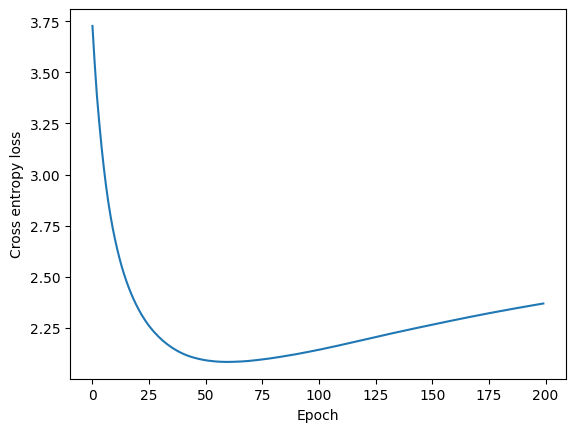

In [ ]:
mlp3_trained_32 = train(mlp3s[0], opt3s[0], X_train, train_label, GRADIENT_STEPS_2)

In [ ]:
hidden32_model3_acc = evaluate_acc(test_label, mlp3_trained_32.forward(X_test))
hidden32_model3_acc

0.2738427216954824

  2%|▏         | 1/55 [00:04<04:13,  4.69s/it]

3.8115698515473038


  4%|▎         | 2/55 [00:08<03:52,  4.39s/it]

3.597646351596634


  5%|▌         | 3/55 [00:13<03:44,  4.32s/it]

3.4030634030353806


  7%|▋         | 4/55 [00:17<03:42,  4.37s/it]

3.262173285138345


  9%|▉         | 5/55 [00:21<03:35,  4.31s/it]

3.147620025747441


 11%|█         | 6/55 [00:25<03:30,  4.29s/it]

3.046077361025654


 13%|█▎        | 7/55 [00:30<03:25,  4.28s/it]

2.9608290299333806


 15%|█▍        | 8/55 [00:34<03:21,  4.28s/it]

2.884421877152


 16%|█▋        | 9/55 [00:38<03:15,  4.25s/it]

2.818799158945651


 18%|█▊        | 10/55 [00:43<03:13,  4.30s/it]

2.760972650318189


 20%|██        | 11/55 [00:47<03:08,  4.28s/it]

2.710833065701867


 22%|██▏       | 12/55 [00:51<03:02,  4.24s/it]

2.6668363990189254


 24%|██▎       | 13/55 [00:56<03:01,  4.31s/it]

2.6276859812076006


 25%|██▌       | 14/55 [01:00<02:54,  4.26s/it]

2.5922861027579547


 27%|██▋       | 15/55 [01:04<02:49,  4.25s/it]

2.5594460503062026


 29%|██▉       | 16/55 [01:08<02:45,  4.25s/it]

2.5298509028260554


 31%|███       | 17/55 [01:12<02:40,  4.22s/it]

2.5026828532304455


 33%|███▎      | 18/55 [01:16<02:35,  4.19s/it]

2.477756888992727


 35%|███▍      | 19/55 [01:21<02:31,  4.21s/it]

2.454830489915513


 36%|███▋      | 20/55 [01:25<02:26,  4.19s/it]

2.4334051087643807


 38%|███▊      | 21/55 [01:29<02:22,  4.19s/it]

2.413014226747216


 40%|████      | 22/55 [01:33<02:18,  4.21s/it]

2.393316026111853


 42%|████▏     | 23/55 [01:37<02:14,  4.21s/it]

2.37492395860726


 44%|████▎     | 24/55 [01:42<02:10,  4.21s/it]

2.3580396995182693


 45%|████▌     | 25/55 [01:46<02:06,  4.23s/it]

2.341701910915983


 47%|████▋     | 26/55 [01:50<02:03,  4.26s/it]

2.3272639521208784


 49%|████▉     | 27/55 [01:54<01:57,  4.21s/it]

2.3128508073817637


 51%|█████     | 28/55 [01:59<01:53,  4.20s/it]

2.3002196869011975


 53%|█████▎    | 29/55 [02:03<01:49,  4.21s/it]

2.2870553211351625


 55%|█████▍    | 30/55 [02:07<01:44,  4.20s/it]

2.2764219127954575


 56%|█████▋    | 31/55 [02:11<01:40,  4.21s/it]

2.264353127039598


 58%|█████▊    | 32/55 [02:15<01:37,  4.23s/it]

2.255067176918411


 60%|██████    | 33/55 [02:20<01:32,  4.21s/it]

2.244049602028642


 62%|██████▏   | 34/55 [02:24<01:28,  4.21s/it]

2.236103451443975


 64%|██████▎   | 35/55 [02:28<01:26,  4.31s/it]

2.2264322623445203


 65%|██████▌   | 36/55 [02:33<01:21,  4.27s/it]

2.219189002243662


 67%|██████▋   | 37/55 [02:37<01:16,  4.26s/it]

2.2109395187912004


 69%|██████▉   | 38/55 [02:41<01:12,  4.27s/it]

2.204216743626036


 71%|███████   | 39/55 [02:45<01:07,  4.23s/it]

2.1971205509897187


 73%|███████▎  | 40/55 [02:49<01:03,  4.20s/it]

2.1911948340820224


 75%|███████▍  | 41/55 [02:54<01:00,  4.29s/it]

2.184949661370247


 76%|███████▋  | 42/55 [02:58<00:55,  4.24s/it]

2.179723396574246


 78%|███████▊  | 43/55 [03:02<00:50,  4.21s/it]

2.174278774577691


 80%|████████  | 44/55 [03:06<00:46,  4.26s/it]

2.1697691541357025


 82%|████████▏ | 45/55 [03:11<00:42,  4.23s/it]

2.1650915061944254


 84%|████████▎ | 46/55 [03:15<00:37,  4.21s/it]

2.161209971102977


 85%|████████▌ | 47/55 [03:19<00:33,  4.21s/it]

2.1570970560568443


 87%|████████▋ | 48/55 [03:23<00:29,  4.20s/it]

2.1535909237248467


 89%|████████▉ | 49/55 [03:27<00:25,  4.18s/it]

2.149986069534421


 91%|█████████ | 50/55 [03:32<00:20,  4.19s/it]

2.1468960725870483


 93%|█████████▎| 51/55 [03:36<00:16,  4.18s/it]

2.1436234436246986


 95%|█████████▍| 52/55 [03:40<00:12,  4.18s/it]

2.140832170716649


 96%|█████████▋| 53/55 [03:44<00:08,  4.19s/it]

2.137949580584276


 98%|█████████▊| 54/55 [03:48<00:04,  4.20s/it]

2.1354842139511834


100%|██████████| 55/55 [03:52<00:00,  4.24s/it]

2.1330421202883696
[3.8115698515473038, 3.597646351596634, 3.4030634030353806, 3.262173285138345, 3.147620025747441, 3.046077361025654, 2.9608290299333806, 2.884421877152, 2.818799158945651, 2.760972650318189, 2.710833065701867, 2.6668363990189254, 2.6276859812076006, 2.5922861027579547, 2.5594460503062026, 2.5298509028260554, 2.5026828532304455, 2.477756888992727, 2.454830489915513, 2.4334051087643807, 2.413014226747216, 2.393316026111853, 2.37492395860726, 2.3580396995182693, 2.341701910915983, 2.3272639521208784, 2.3128508073817637, 2.3002196869011975, 2.2870553211351625, 2.2764219127954575, 2.264353127039598, 2.255067176918411, 2.244049602028642, 2.236103451443975, 2.2264322623445203, 2.219189002243662, 2.2109395187912004, 2.204216743626036, 2.1971205509897187, 2.1911948340820224, 2.184949661370247, 2.179723396574246, 2.174278774577691, 2.1697691541357025, 2.1650915061944254, 2.161209971102977, 2.1570970560568443, 2.1535909237248467, 2.149986069534421, 2.1468960725870483, 2.1436234

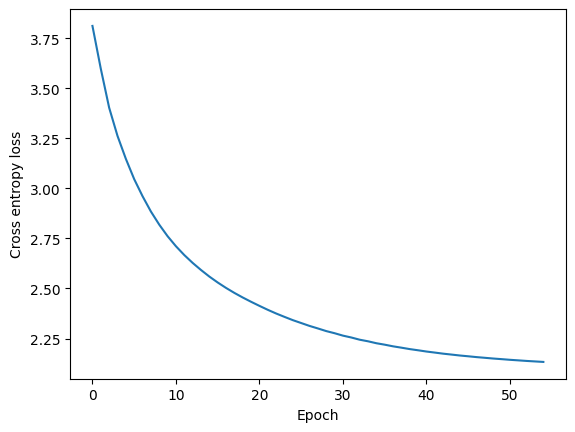

In [ ]:
# try to get better performance by inspection (stop where overfit occurs)
mlp3_trained_32_fitted = train(mlp3s[0], opt3s[0], X_train, train_label, 55)

In [ ]:
# stopping before overfitting yields higher accuracy
hidden32_model3_fitted_acc = evaluate_acc(test_label, mlp3_trained_32_fitted.forward(X_test))
hidden32_model3_fitted_acc

0.3664249860568879

  0%|          | 1/200 [00:08<27:05,  8.17s/it]

3.591155337844826


  1%|          | 2/200 [00:16<26:45,  8.11s/it]

3.272122791110667


  2%|▏         | 3/200 [00:24<26:51,  8.18s/it]

3.0694928627650855


  2%|▏         | 4/200 [00:32<26:46,  8.20s/it]

2.904072464117484


  2%|▎         | 5/200 [00:40<26:31,  8.16s/it]

2.775360719935722


  3%|▎         | 6/200 [00:48<26:22,  8.16s/it]

2.6705107665221433


  4%|▎         | 7/200 [00:57<26:15,  8.16s/it]

2.585991605852608


  4%|▍         | 8/200 [01:05<26:07,  8.16s/it]

2.516769764429521


  4%|▍         | 9/200 [01:13<25:59,  8.17s/it]

2.460201551354087


  5%|▌         | 10/200 [01:21<25:45,  8.13s/it]

2.412922793315591


  6%|▌         | 11/200 [01:30<25:57,  8.24s/it]

2.372667857487355


  6%|▌         | 12/200 [01:38<25:47,  8.23s/it]

2.336924130236705


  6%|▋         | 13/200 [01:46<25:29,  8.18s/it]

2.305160949253171


  7%|▋         | 14/200 [01:54<25:18,  8.16s/it]

2.2759086040848064


  8%|▊         | 15/200 [02:02<25:12,  8.17s/it]

2.2507011269868635


  8%|▊         | 16/200 [02:10<25:03,  8.17s/it]

2.2264940194297766


  8%|▊         | 17/200 [02:18<24:54,  8.16s/it]

2.206568080871981


  9%|▉         | 18/200 [02:27<24:47,  8.18s/it]

2.18581686091999


 10%|▉         | 19/200 [02:35<24:47,  8.22s/it]

2.170693417505615


 10%|█         | 20/200 [02:43<24:37,  8.21s/it]

2.1532507180252725


 10%|█         | 21/200 [02:51<24:26,  8.19s/it]

2.1433042760704217


 11%|█         | 22/200 [03:00<24:23,  8.22s/it]

2.1271184511041628


 12%|█▏        | 23/200 [03:08<24:19,  8.25s/it]

2.1204616045601656


 12%|█▏        | 24/200 [03:16<24:07,  8.22s/it]

2.1057503545457035


 12%|█▎        | 25/200 [03:24<23:59,  8.23s/it]

2.0999877451547166


 13%|█▎        | 26/200 [03:33<23:53,  8.24s/it]

2.0872799548320526


 14%|█▎        | 27/200 [03:41<23:48,  8.26s/it]

2.0825641321520854


 14%|█▍        | 28/200 [03:49<23:40,  8.26s/it]

2.0721442524715314


 14%|█▍        | 29/200 [03:57<23:28,  8.24s/it]

2.068082898109264


 15%|█▌        | 30/200 [04:06<23:31,  8.31s/it]

2.0596592686308717


 16%|█▌        | 31/200 [04:14<23:21,  8.29s/it]

2.0563956569386654


 16%|█▌        | 32/200 [04:22<23:06,  8.25s/it]

2.0494684335121907


 16%|█▋        | 33/200 [04:30<22:58,  8.26s/it]

2.046817063355897


 17%|█▋        | 34/200 [04:39<22:50,  8.26s/it]

2.0410090297940218


 18%|█▊        | 35/200 [04:47<22:41,  8.25s/it]

2.038815594912229


 18%|█▊        | 36/200 [04:55<22:28,  8.22s/it]

2.0342394825835717


 18%|█▊        | 37/200 [05:03<22:22,  8.24s/it]

2.032246692622698


 19%|█▉        | 38/200 [05:12<22:29,  8.33s/it]

2.028754132560356


 20%|█▉        | 39/200 [05:20<22:16,  8.30s/it]

2.0272087186308965


 20%|██        | 40/200 [05:28<22:06,  8.29s/it]

2.0244199792387287


 20%|██        | 41/200 [05:37<22:16,  8.41s/it]

2.0232583003018885


 21%|██        | 42/200 [05:45<22:00,  8.36s/it]

2.021382294599464


 22%|██▏       | 43/200 [05:53<21:41,  8.29s/it]

2.020502976764908


 22%|██▏       | 44/200 [06:02<21:34,  8.30s/it]

2.019335150687265


 22%|██▎       | 45/200 [06:10<21:18,  8.25s/it]

2.0187015990929185


 23%|██▎       | 46/200 [06:18<21:07,  8.23s/it]

2.0178637798881676


 24%|██▎       | 47/200 [06:26<20:52,  8.18s/it]

2.0175391151132227


 24%|██▍       | 48/200 [06:34<20:44,  8.19s/it]

2.0170972627875665


 24%|██▍       | 49/200 [06:43<20:45,  8.25s/it]

2.0170151222377286


 25%|██▌       | 50/200 [06:51<20:36,  8.25s/it]

2.0169317135753726


 26%|██▌       | 51/200 [06:59<20:27,  8.24s/it]

2.017076059370697


 26%|██▌       | 52/200 [07:08<20:30,  8.31s/it]

2.0174005249321874


 26%|██▋       | 53/200 [07:16<20:18,  8.29s/it]

2.0179195365787326


 27%|██▋       | 54/200 [07:24<20:03,  8.24s/it]

2.018456693624616


 28%|██▊       | 55/200 [07:32<19:53,  8.23s/it]

2.0191676790814763


 28%|██▊       | 56/200 [07:41<19:43,  8.22s/it]

2.0199892489661053


 28%|██▊       | 57/200 [07:49<19:35,  8.22s/it]

2.020943442902932


 29%|██▉       | 58/200 [07:57<19:23,  8.19s/it]

2.022036535079996


 30%|██▉       | 59/200 [08:05<19:12,  8.18s/it]

2.0232257626724914


 30%|███       | 60/200 [08:13<19:17,  8.27s/it]

2.024484768281312


 30%|███       | 61/200 [08:22<19:05,  8.24s/it]

2.025848424754428


 31%|███       | 62/200 [08:30<18:51,  8.20s/it]

2.027213852423976


 32%|███▏      | 63/200 [08:38<18:45,  8.22s/it]

2.028703483520493


 32%|███▏      | 64/200 [08:46<18:41,  8.25s/it]

2.030270544072998


 32%|███▎      | 65/200 [08:54<18:29,  8.22s/it]

2.031939127472545


 33%|███▎      | 66/200 [09:03<18:20,  8.21s/it]

2.0336147617953437


 34%|███▎      | 67/200 [09:11<18:09,  8.19s/it]

2.0353386946821916


 34%|███▍      | 68/200 [09:19<18:05,  8.22s/it]

2.037128686717235


 34%|███▍      | 69/200 [09:27<17:52,  8.19s/it]

2.038948733958285


 35%|███▌      | 70/200 [09:35<17:43,  8.18s/it]

2.040778559876949


 36%|███▌      | 71/200 [09:44<17:41,  8.23s/it]

2.0426678228188044


 36%|███▌      | 72/200 [09:52<17:31,  8.21s/it]

2.0446110473630292


 36%|███▋      | 73/200 [10:00<17:19,  8.18s/it]

2.046627328157287


 37%|███▋      | 74/200 [10:08<17:12,  8.19s/it]

2.0486943845056365


 38%|███▊      | 75/200 [10:16<17:03,  8.19s/it]

2.050790706778937


 38%|███▊      | 76/200 [10:25<17:01,  8.23s/it]

2.0529090700257644


 38%|███▊      | 77/200 [10:33<16:49,  8.21s/it]

2.055030596847814


 39%|███▉      | 78/200 [10:41<16:38,  8.18s/it]

2.0572047139364895


 40%|███▉      | 79/200 [10:49<16:33,  8.21s/it]

2.0594225652751947


 40%|████      | 80/200 [10:58<16:25,  8.21s/it]

2.0616758369159416


 40%|████      | 81/200 [11:06<16:14,  8.19s/it]

2.0639923335615618


 41%|████      | 82/200 [11:14<16:09,  8.21s/it]

2.0662983847837353


 42%|████▏     | 83/200 [11:22<16:04,  8.25s/it]

2.0686471737941803


 42%|████▏     | 84/200 [11:30<15:54,  8.23s/it]

2.0709814173242673


 42%|████▎     | 85/200 [11:39<15:45,  8.22s/it]

2.0733276124172924


 43%|████▎     | 86/200 [11:47<15:35,  8.21s/it]

2.075682027255598


 44%|████▎     | 87/200 [11:55<15:32,  8.25s/it]

2.078041191718196


 44%|████▍     | 88/200 [12:03<15:23,  8.24s/it]

2.08040612756087


 44%|████▍     | 89/200 [12:12<15:12,  8.22s/it]

2.0827692849858437


 45%|████▌     | 90/200 [12:20<15:11,  8.28s/it]

2.0851411143075316


 46%|████▌     | 91/200 [12:28<15:02,  8.28s/it]

2.087487387054672


 46%|████▌     | 92/200 [12:36<14:52,  8.26s/it]

2.0898490258197393


 46%|████▋     | 93/200 [12:45<14:41,  8.24s/it]

2.0922173728449787


 47%|████▋     | 94/200 [12:53<14:32,  8.23s/it]

2.0945901800412714


 48%|████▊     | 95/200 [13:01<14:24,  8.23s/it]

2.096986558476637


 48%|████▊     | 96/200 [13:09<14:16,  8.23s/it]

2.0993704440429397


 48%|████▊     | 97/200 [13:17<14:03,  8.19s/it]

2.101760567630704


 49%|████▉     | 98/200 [13:26<13:56,  8.20s/it]

2.1041695437090544


 50%|████▉     | 99/200 [13:34<13:44,  8.16s/it]

2.106560440071275


 50%|█████     | 100/200 [13:42<13:33,  8.13s/it]

2.108946500818886


 50%|█████     | 101/200 [13:50<13:22,  8.11s/it]

2.111346085174117


 51%|█████     | 102/200 [13:58<13:12,  8.09s/it]

2.1137629888893126


 52%|█████▏    | 103/200 [14:06<13:06,  8.11s/it]

2.116148455638009


 52%|█████▏    | 104/200 [14:14<12:58,  8.11s/it]

2.1185287389774627


 52%|█████▎    | 105/200 [14:22<12:46,  8.07s/it]

2.120923101445065


 53%|█████▎    | 106/200 [14:30<12:41,  8.10s/it]

2.1233208402877715


 54%|█████▎    | 107/200 [14:38<12:33,  8.10s/it]

2.125721090679132


 54%|█████▍    | 108/200 [14:46<12:21,  8.06s/it]

2.1281035536708974


 55%|█████▍    | 109/200 [14:54<12:12,  8.05s/it]

2.130483450536489


 55%|█████▌    | 110/200 [15:02<12:05,  8.06s/it]

2.1328289666003637


 56%|█████▌    | 111/200 [15:11<12:00,  8.10s/it]

2.135152361020779


 56%|█████▌    | 112/200 [15:19<11:51,  8.09s/it]

2.1374652120597086


 56%|█████▋    | 113/200 [15:27<11:41,  8.06s/it]

2.139789517380924


 57%|█████▋    | 114/200 [15:35<11:43,  8.19s/it]

2.1420524159800096


 57%|█████▊    | 115/200 [15:43<11:34,  8.17s/it]

2.144293593855129


 58%|█████▊    | 116/200 [15:51<11:21,  8.12s/it]

2.1465207390762804


 58%|█████▊    | 117/200 [15:59<11:13,  8.12s/it]

2.148737246629392


 59%|█████▉    | 118/200 [16:08<11:04,  8.10s/it]

2.1509356782537363


 60%|█████▉    | 119/200 [16:16<11:00,  8.16s/it]

2.1531216189951308


 60%|██████    | 120/200 [16:24<10:51,  8.14s/it]

2.155292911365621


 60%|██████    | 121/200 [16:32<10:39,  8.10s/it]

2.1574456260180788


 61%|██████    | 122/200 [16:40<10:36,  8.16s/it]

2.159591530686061


 62%|██████▏   | 123/200 [16:48<10:27,  8.15s/it]

2.1617155235528736


 62%|██████▏   | 124/200 [16:56<10:16,  8.11s/it]

2.1638393022700066


 62%|██████▎   | 125/200 [17:05<10:09,  8.13s/it]

2.1659409937497642


 63%|██████▎   | 126/200 [17:13<10:01,  8.13s/it]

2.168024128470824


 64%|██████▎   | 127/200 [17:21<09:57,  8.19s/it]

2.1700882131881003


 64%|██████▍   | 128/200 [17:29<09:46,  8.15s/it]

2.1721475622292674


 64%|██████▍   | 129/200 [17:37<09:36,  8.11s/it]

2.1741860537184405


 65%|██████▌   | 130/200 [17:45<09:30,  8.15s/it]

2.176214488709082


 66%|██████▌   | 131/200 [17:53<09:21,  8.14s/it]

2.178220408967082


 66%|██████▌   | 132/200 [18:01<09:09,  8.08s/it]

2.1802023854243164


 66%|██████▋   | 133/200 [18:09<09:00,  8.07s/it]

2.1821732645992196


 67%|██████▋   | 134/200 [18:17<08:52,  8.06s/it]

2.18412882225572


 68%|██████▊   | 135/200 [18:26<08:44,  8.07s/it]

2.1860581107168287


 68%|██████▊   | 136/200 [18:34<08:35,  8.06s/it]

2.1879776789638012


 68%|██████▊   | 137/200 [18:42<08:26,  8.05s/it]

2.189876617219823


 69%|██████▉   | 138/200 [18:50<08:20,  8.07s/it]

2.1917543389282637


 70%|██████▉   | 139/200 [18:58<08:13,  8.09s/it]

2.193618153932555


 70%|███████   | 140/200 [19:06<08:08,  8.14s/it]

2.1954382762241984


 70%|███████   | 141/200 [19:14<08:00,  8.15s/it]

2.1972559579899094


 71%|███████   | 142/200 [19:22<07:52,  8.14s/it]

2.1990697447144862


 72%|███████▏  | 143/200 [19:31<07:45,  8.16s/it]

2.2008749802705885


 72%|███████▏  | 144/200 [19:39<07:35,  8.13s/it]

2.20263339318709


 72%|███████▎  | 145/200 [19:47<07:25,  8.09s/it]

2.2043972487980787


 73%|███████▎  | 146/200 [19:55<07:17,  8.11s/it]

2.206158201147231


 74%|███████▎  | 147/200 [20:03<07:09,  8.10s/it]

2.2079121794906653


 74%|███████▍  | 148/200 [20:11<07:00,  8.09s/it]

2.2096515433440436


 74%|███████▍  | 149/200 [20:19<06:53,  8.11s/it]

2.2113776647660774


 75%|███████▌  | 150/200 [20:27<06:45,  8.11s/it]

2.213090496884601


 76%|███████▌  | 151/200 [20:35<06:38,  8.14s/it]

2.2147835075108726


 76%|███████▌  | 152/200 [20:44<06:30,  8.13s/it]

2.216464830097495


 76%|███████▋  | 153/200 [20:52<06:22,  8.13s/it]

2.2181465491513075


 77%|███████▋  | 154/200 [21:00<06:14,  8.15s/it]

2.2198147664143937


 78%|███████▊  | 155/200 [21:08<06:06,  8.14s/it]

2.2214675371241386


 78%|███████▊  | 156/200 [21:16<05:56,  8.10s/it]

2.2230996761796162


 78%|███████▊  | 157/200 [21:24<05:47,  8.09s/it]

2.224716792809343


 79%|███████▉  | 158/200 [21:32<05:40,  8.10s/it]

2.2263276462518955


 80%|███████▉  | 159/200 [21:40<05:32,  8.10s/it]

2.2279184151674785


 80%|████████  | 160/200 [21:48<05:24,  8.11s/it]

2.229498745666415


 80%|████████  | 161/200 [21:56<05:15,  8.09s/it]

2.2310731525525407


 81%|████████  | 162/200 [22:05<05:08,  8.12s/it]

2.2326206401417705


 82%|████████▏ | 163/200 [22:13<04:59,  8.09s/it]

2.23416539510247


 82%|████████▏ | 164/200 [22:21<04:51,  8.09s/it]

2.235717320418879


 82%|████████▎ | 165/200 [22:29<04:42,  8.08s/it]

2.237257986324429


 83%|████████▎ | 166/200 [22:37<04:34,  8.07s/it]

2.2387813795547595


 84%|████████▎ | 167/200 [22:45<04:26,  8.07s/it]

2.2402984595372253


 84%|████████▍ | 168/200 [22:53<04:17,  8.05s/it]

2.241802511500333


 84%|████████▍ | 169/200 [23:01<04:09,  8.06s/it]

2.243285711201006


 85%|████████▌ | 170/200 [23:09<04:03,  8.11s/it]

2.244758587200187


 86%|████████▌ | 171/200 [23:17<03:56,  8.14s/it]

2.2462176409381907


 86%|████████▌ | 172/200 [23:26<03:47,  8.14s/it]

2.247675983184118


 86%|████████▋ | 173/200 [23:34<03:39,  8.12s/it]

2.249125060665955


 87%|████████▋ | 174/200 [23:42<03:31,  8.13s/it]

2.250565139537787


 88%|████████▊ | 175/200 [23:50<03:24,  8.18s/it]

2.252006931000614


 88%|████████▊ | 176/200 [23:58<03:15,  8.14s/it]

2.2534480917140502


 88%|████████▊ | 177/200 [24:06<03:06,  8.12s/it]

2.254869821102132


 89%|████████▉ | 178/200 [24:14<02:59,  8.14s/it]

2.2562755927520457


 90%|████████▉ | 179/200 [24:23<02:50,  8.14s/it]

2.257670398783029


 90%|█████████ | 180/200 [24:31<02:41,  8.10s/it]

2.259055809733214


 90%|█████████ | 181/200 [24:39<02:33,  8.08s/it]

2.2604350228037147


 91%|█████████ | 182/200 [24:47<02:25,  8.09s/it]

2.2617947684704385


 92%|█████████▏| 183/200 [24:55<02:17,  8.08s/it]

2.263138904507227


 92%|█████████▏| 184/200 [25:03<02:09,  8.06s/it]

2.2644673585290946


 92%|█████████▎| 185/200 [25:11<02:00,  8.06s/it]

2.265789778614462


 93%|█████████▎| 186/200 [25:19<01:53,  8.08s/it]

2.2671123936857427


 94%|█████████▎| 187/200 [25:27<01:44,  8.07s/it]

2.268419426273915


 94%|█████████▍| 188/200 [25:35<01:36,  8.07s/it]

2.269716044129522


 94%|█████████▍| 189/200 [25:43<01:28,  8.05s/it]

2.271006805668387


 95%|█████████▌| 190/200 [25:51<01:20,  8.09s/it]

2.2722874393248356


 96%|█████████▌| 191/200 [25:59<01:12,  8.10s/it]

2.2735533169054625


 96%|█████████▌| 192/200 [26:07<01:04,  8.07s/it]

2.2748053371092225


 96%|█████████▋| 193/200 [26:15<00:56,  8.03s/it]

2.2760453519973916


 97%|█████████▋| 194/200 [26:23<00:48,  8.07s/it]

2.2772789617687343


 98%|█████████▊| 195/200 [26:32<00:40,  8.06s/it]

2.2785073470773245


 98%|█████████▊| 196/200 [26:40<00:32,  8.04s/it]

2.279733591498069


 98%|█████████▊| 197/200 [26:48<00:24,  8.07s/it]

2.280945534970335


 99%|█████████▉| 198/200 [26:56<00:16,  8.09s/it]

2.282153940749259


100%|█████████▉| 199/200 [27:04<00:08,  8.12s/it]

2.283352870189133


100%|██████████| 200/200 [27:12<00:00,  8.16s/it]

2.284543122199608
[3.591155337844826, 3.272122791110667, 3.0694928627650855, 2.904072464117484, 2.775360719935722, 2.6705107665221433, 2.585991605852608, 2.516769764429521, 2.460201551354087, 2.412922793315591, 2.372667857487355, 2.336924130236705, 2.305160949253171, 2.2759086040848064, 2.2507011269868635, 2.2264940194297766, 2.206568080871981, 2.18581686091999, 2.170693417505615, 2.1532507180252725, 2.1433042760704217, 2.1271184511041628, 2.1204616045601656, 2.1057503545457035, 2.0999877451547166, 2.0872799548320526, 2.0825641321520854, 2.0721442524715314, 2.068082898109264, 2.0596592686308717, 2.0563956569386654, 2.0494684335121907, 2.046817063355897, 2.0410090297940218, 2.038815594912229, 2.0342394825835717, 2.032246692622698, 2.028754132560356, 2.0272087186308965, 2.0244199792387287, 2.0232583003018885, 2.021382294599464, 2.020502976764908, 2.019335150687265, 2.0187015990929185, 2.0178637798881676, 2.0175391151132227, 2.0170972627875665, 2.0170151222377286, 2.0169317135753726, 2.01

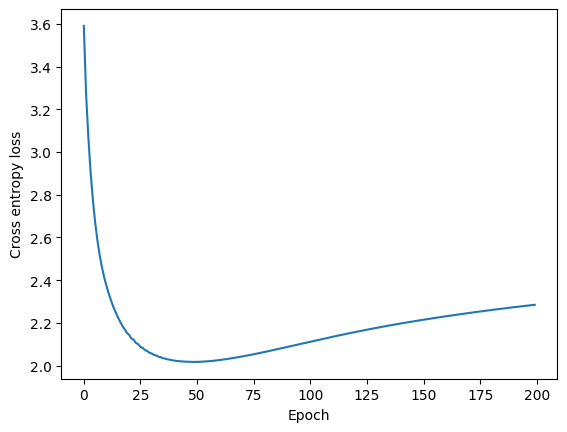

In [ ]:
mlp3_trained_64 = train(mlp3s[1], opt3s[1], X_train, train_label, GRADIENT_STEPS_2)

In [ ]:
hidden64_model3_acc = evaluate_acc(test_label, mlp3_trained_64.forward(X_test))
hidden64_model3_acc

0.36503067484662577

In [ ]:
# try to get better performance by inspection (stop where overfit occurs)
mlp3_trained_64_fitted = train(mlp3s[0], opt3s[0], X_train, train_label, 50)

  2%|▏         | 1/50 [00:05<04:41,  5.75s/it]

3.6705067911270435


In [ ]:
# stopping before overfitting yields higher accuracy
hidden64_model3_fitted_acc = evaluate_acc(test_label, mlp3_trained_64_fitted.forward(X_test))
hidden64_model3_fitted_acc

0.3474623535973229

In [ ]:
#mlp3_trained_128 = train(mlp3s[2], opt3s[2], X_train, train_label, GRADIENT_STEPS)
#crashed

In [ ]:
#mlp3_trained_256 = train(mlp3s[3], opt3s[3], X_train, train_label, GRADIENT_STEPS)


**3.2  - Create two copies of model (3) with sigmoid and Leaky-ReLU activations**

In [ ]:
#Model 4 : An MLP with 2 hidden layers, 32 units each having Sigmoid activations
mlpSigmoid = [
    MLP(
        LinearLayer(i_size, hidden_size),
        SigmoidLayer(),
        LinearLayer(hidden_size, hidden_size),  # second hidden layer
        SigmoidLayer(),
        LinearLayer(hidden_size, num_classes),
        SoftmaxOutputLayer()
    ) for hidden_size in hidden_sizes
]


opt4s = [StochasticGradientDescentOptimizer(mlp, 1e-1) for mlp in mlpSigmoid]

  1%|          | 1/100 [00:08<13:20,  8.08s/it]

3.698731924514727


  2%|▏         | 2/100 [00:16<13:09,  8.06s/it]

3.648597296778059


  3%|▎         | 3/100 [00:24<13:00,  8.04s/it]

3.598263670871263


  4%|▍         | 4/100 [00:32<12:56,  8.09s/it]

3.5487787982216457


  5%|▌         | 5/100 [00:40<12:47,  8.08s/it]

3.500806820614233


  6%|▌         | 6/100 [00:48<12:35,  8.04s/it]

3.454653697417724


  7%|▋         | 7/100 [00:56<12:31,  8.08s/it]

3.4103752832435283


  8%|▊         | 8/100 [01:04<12:21,  8.06s/it]

3.367891125289975


  9%|▉         | 9/100 [01:12<12:10,  8.03s/it]

3.3270678684731494


 10%|█         | 10/100 [01:20<12:03,  8.04s/it]

3.2877670953644387


 11%|█         | 11/100 [01:28<11:56,  8.05s/it]

3.249866652653978


 12%|█▏        | 12/100 [01:36<11:51,  8.08s/it]

3.213266491926745


 13%|█▎        | 13/100 [01:44<11:41,  8.06s/it]

3.1778871422696326


 14%|█▍        | 14/100 [01:52<11:29,  8.02s/it]

3.143665567430756


 15%|█▌        | 15/100 [02:00<11:25,  8.06s/it]

3.110550761907395


 16%|█▌        | 16/100 [02:08<11:16,  8.05s/it]

3.078500041838791


 17%|█▋        | 17/100 [02:16<11:05,  8.02s/it]

3.0474762719813304


 18%|█▊        | 18/100 [02:24<10:57,  8.02s/it]

3.0174459521917134


 19%|█▉        | 19/100 [02:32<10:48,  8.01s/it]

2.9883779774925174


 20%|██        | 20/100 [02:40<10:43,  8.04s/it]

2.960242876060384


 21%|██        | 21/100 [02:48<10:34,  8.04s/it]

2.9330123605644585


 22%|██▏       | 22/100 [02:56<10:24,  8.01s/it]

2.906659070349001


 23%|██▎       | 23/100 [03:04<10:16,  8.01s/it]

2.881156421159561


 24%|██▍       | 24/100 [03:12<10:08,  8.01s/it]

2.856478510192541


 25%|██▌       | 25/100 [03:20<10:01,  8.02s/it]

2.832600046387886


 26%|██▌       | 26/100 [03:28<09:51,  7.99s/it]

2.809496290383178


 27%|██▋       | 27/100 [03:36<09:43,  8.00s/it]

2.787142997413198


 28%|██▊       | 28/100 [03:44<09:37,  8.02s/it]

2.7655163615706018


 29%|██▉       | 29/100 [03:53<09:29,  8.03s/it]

2.7445929626561982


 30%|███       | 30/100 [04:01<09:20,  8.01s/it]

2.7243497182396643


 31%|███       | 31/100 [04:08<09:12,  8.01s/it]

2.7047638440290593


 32%|███▏      | 32/100 [04:16<09:04,  8.00s/it]

2.685812825488146


 33%|███▎      | 33/100 [04:25<08:59,  8.06s/it]

2.667474403014388


 34%|███▍      | 34/100 [04:33<08:51,  8.05s/it]

2.6497265720331056


 35%|███▌      | 35/100 [04:41<08:43,  8.06s/it]

2.632547598207925


 36%|███▌      | 36/100 [04:49<08:37,  8.09s/it]

2.615916046753715


 37%|███▋      | 37/100 [04:57<08:31,  8.12s/it]

2.599810823708594


 38%|███▊      | 38/100 [05:05<08:19,  8.06s/it]

2.58421122610754


 39%|███▉      | 39/100 [05:13<08:10,  8.05s/it]

2.5690969974057607


 40%|████      | 40/100 [05:21<08:01,  8.03s/it]

2.5544483842850516


 41%|████      | 41/100 [05:29<07:53,  8.03s/it]

2.540246191145484


 42%|████▏     | 42/100 [05:37<07:46,  8.04s/it]

2.526471829088428


 43%|████▎     | 43/100 [05:45<07:38,  8.04s/it]

2.5131073569413105


 44%|████▍     | 44/100 [05:53<07:31,  8.07s/it]

2.500135512742392


 45%|████▌     | 45/100 [06:01<07:23,  8.06s/it]

2.4875397349772235


 46%|████▌     | 46/100 [06:09<07:12,  8.02s/it]

2.475304173638657


 47%|████▋     | 47/100 [06:17<07:04,  8.01s/it]

2.4634136918029688


 48%|████▊     | 48/100 [06:25<06:56,  8.02s/it]

2.4518538588462677


 49%|████▉     | 49/100 [06:33<06:51,  8.06s/it]

2.4406109366691067


 50%|█████     | 50/100 [06:42<06:42,  8.05s/it]

2.4296718603788365


 51%|█████     | 51/100 [06:49<06:33,  8.03s/it]

2.419024214835334


 52%|█████▏    | 52/100 [06:58<06:26,  8.05s/it]

2.4086562083371645


 53%|█████▎    | 53/100 [07:06<06:17,  8.04s/it]

2.398556644548987


 54%|█████▍    | 54/100 [07:14<06:08,  8.02s/it]

2.3887148935761817


 55%|█████▌    | 55/100 [07:22<06:01,  8.03s/it]

2.379120862901511


 56%|█████▌    | 56/100 [07:30<05:53,  8.03s/it]

2.3697649687237154


 57%|█████▋    | 57/100 [07:38<05:46,  8.06s/it]

2.3606381080871337


 58%|█████▊    | 58/100 [07:46<05:38,  8.06s/it]

2.351731632066599


 59%|█████▉    | 59/100 [07:54<05:28,  8.02s/it]

2.343037320172534


 60%|██████    | 60/100 [08:02<05:25,  8.14s/it]

2.3345473560649235


 61%|██████    | 61/100 [08:10<05:15,  8.10s/it]

2.3262543046079114


 62%|██████▏   | 62/100 [08:18<05:06,  8.05s/it]

2.3181510902564755


 63%|██████▎   | 63/100 [08:26<04:58,  8.07s/it]

2.310230976738384


 64%|██████▍   | 64/100 [08:34<04:50,  8.07s/it]

2.3024875479772


 65%|██████▌   | 65/100 [08:43<04:43,  8.11s/it]

2.29491469019091


 66%|██████▌   | 66/100 [08:51<04:34,  8.09s/it]

2.287506575096241


 67%|██████▋   | 67/100 [08:58<04:25,  8.05s/it]

2.2802576441467144


 68%|██████▊   | 68/100 [09:07<04:19,  8.12s/it]

2.2731625937343076


 69%|██████▉   | 69/100 [09:15<04:11,  8.12s/it]

2.2662163612872397


 70%|███████   | 70/100 [09:23<04:02,  8.07s/it]

2.2594141122004583


 71%|███████   | 71/100 [09:31<03:53,  8.05s/it]

2.2527512275400237


 72%|███████▏  | 72/100 [09:39<03:45,  8.06s/it]

2.2462232924672465


 73%|███████▎  | 73/100 [09:47<03:38,  8.10s/it]

2.2398260853331595


 74%|███████▍  | 74/100 [09:55<03:30,  8.11s/it]

2.2335555673983496


 75%|███████▌  | 75/100 [10:03<03:22,  8.09s/it]

2.2274078731374733


 76%|███████▌  | 76/100 [10:12<03:16,  8.17s/it]

2.221379301091491


 77%|███████▋  | 77/100 [10:20<03:07,  8.14s/it]

2.2154663052341417


 78%|███████▊  | 78/100 [10:28<02:57,  8.08s/it]

2.209665486822342


 79%|███████▉  | 79/100 [10:36<02:49,  8.07s/it]

2.203973586702692


 80%|████████  | 80/100 [10:44<02:41,  8.08s/it]

2.1983874780488364


 81%|████████  | 81/100 [10:52<02:33,  8.08s/it]

2.192904159506255


 82%|████████▏ | 82/100 [11:00<02:26,  8.12s/it]

2.1875207487229313


 83%|████████▎ | 83/100 [11:08<02:17,  8.09s/it]

2.182234476245755


 84%|████████▍ | 84/100 [11:17<02:12,  8.26s/it]

2.177042679763799


 85%|████████▌ | 85/100 [11:25<02:02,  8.20s/it]

2.1719427986807136


 86%|████████▌ | 86/100 [11:33<01:54,  8.15s/it]

2.1669323689993214


 87%|████████▋ | 87/100 [11:41<01:45,  8.14s/it]

2.1620090185024177


 88%|████████▊ | 88/100 [11:49<01:37,  8.12s/it]

2.157170462214331


 89%|████████▉ | 89/100 [11:57<01:29,  8.16s/it]

2.1524144981285387


 90%|█████████ | 90/100 [12:05<01:21,  8.11s/it]

2.147739003187077


 91%|█████████ | 91/100 [12:13<01:12,  8.07s/it]

2.143141929498069


 92%|█████████▏| 92/100 [12:21<01:04,  8.09s/it]

2.1386213007781714


 93%|█████████▎| 93/100 [12:29<00:56,  8.07s/it]

2.134175209007122


 94%|█████████▍| 94/100 [12:37<00:48,  8.04s/it]

2.129801811282073


 95%|█████████▌| 95/100 [12:45<00:40,  8.03s/it]

2.1254993268599263


 96%|█████████▌| 96/100 [12:54<00:32,  8.04s/it]

2.1212660343760903


 97%|█████████▋| 97/100 [13:02<00:24,  8.06s/it]

2.117100269228823


 98%|█████████▊| 98/100 [13:10<00:16,  8.05s/it]

2.1130004211185196


 99%|█████████▉| 99/100 [13:18<00:08,  8.03s/it]

2.108964931731973


100%|██████████| 100/100 [13:26<00:00,  8.07s/it]

2.1049922925619304
[3.698731924514727, 3.648597296778059, 3.598263670871263, 3.5487787982216457, 3.500806820614233, 3.454653697417724, 3.4103752832435283, 3.367891125289975, 3.3270678684731494, 3.2877670953644387, 3.249866652653978, 3.213266491926745, 3.1778871422696326, 3.143665567430756, 3.110550761907395, 3.078500041838791, 3.0474762719813304, 3.0174459521917134, 2.9883779774925174, 2.960242876060384, 2.9330123605644585, 2.906659070349001, 2.881156421159561, 2.856478510192541, 2.832600046387886, 2.809496290383178, 2.787142997413198, 2.7655163615706018, 2.7445929626561982, 2.7243497182396643, 2.7047638440290593, 2.685812825488146, 2.667474403014388, 2.6497265720331056, 2.632547598207925, 2.615916046753715, 2.599810823708594, 2.58421122610754, 2.5690969974057607, 2.5544483842850516, 2.540246191145484, 2.526471829088428, 2.5131073569413105, 2.500135512742392, 2.4875397349772235, 2.475304173638657, 2.4634136918029688, 2.4518538588462677, 2.4406109366691067, 2.4296718603788365, 2.4190242

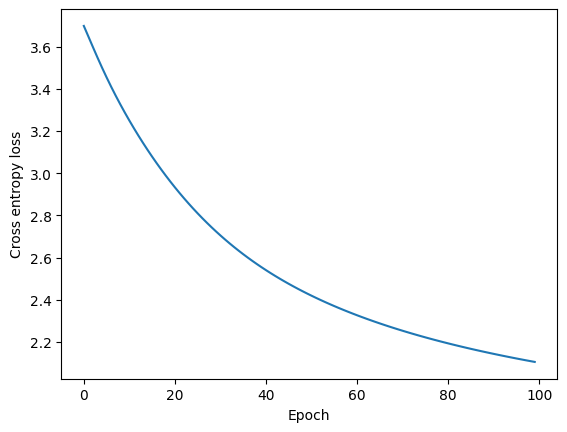

In [ ]:
mlpSigmoid_trained_64 = train(mlpSigmoid[1], opt4s[1], X_train, train_label, GRADIENT_STEPS)

In [ ]:
sigmoid_acc = evaluate_acc(test_label, mlpSigmoid_trained_64.forward(X_test))
sigmoid_acc

0.37353597322922477

In [ ]:
#Model 5 : An MLP with 2 hidden layers, 32 units each having Leaky Relu activations
mlpLeaky = [
    MLP(
        LinearLayer(i_size, hidden_size),
        LeakyReLULayer(),
        LinearLayer(hidden_size, hidden_size),  # second hidden layer
        LeakyReLULayer(),
        LinearLayer(hidden_size, num_classes),
        SoftmaxOutputLayer()
    ) for hidden_size in hidden_sizes
]

opt5s = [StochasticGradientDescentOptimizer(mlp, 1e-1) for mlp in mlpLeaky]

  1%|          | 1/100 [00:08<13:21,  8.10s/it]

3.7187514026184685


  2%|▏         | 2/100 [00:16<13:43,  8.40s/it]

3.3697828903655025


  3%|▎         | 3/100 [00:24<13:21,  8.26s/it]

3.1444973296203496


  4%|▍         | 4/100 [00:33<13:24,  8.38s/it]

2.960574041812157


  5%|▌         | 5/100 [00:41<13:08,  8.30s/it]

2.8134315926354234


  6%|▌         | 6/100 [00:49<12:55,  8.25s/it]

2.6925562344262595


  7%|▋         | 7/100 [00:57<12:43,  8.21s/it]

2.5898805592848193


  8%|▊         | 8/100 [01:05<12:34,  8.20s/it]

2.502154277195302


  9%|▉         | 9/100 [01:14<12:22,  8.15s/it]

2.4267967392947822


 10%|█         | 10/100 [01:21<12:07,  8.09s/it]

2.362833396785449


 11%|█         | 11/100 [01:29<11:57,  8.06s/it]

2.307973761370746


 12%|█▏        | 12/100 [01:38<11:49,  8.07s/it]

2.2607789531511013


 13%|█▎        | 13/100 [01:46<11:41,  8.06s/it]

2.2205547974915616


 14%|█▍        | 14/100 [01:54<11:32,  8.06s/it]

2.1835816781954653


 15%|█▌        | 15/100 [02:02<11:25,  8.06s/it]

2.1533692622912053


 16%|█▌        | 16/100 [02:10<11:20,  8.10s/it]

2.124129163120716


 17%|█▋        | 17/100 [02:18<11:07,  8.04s/it]

2.1000556250550213


 18%|█▊        | 18/100 [02:26<10:56,  8.00s/it]

2.076819922220505


 19%|█▉        | 19/100 [02:34<10:47,  8.00s/it]

2.0569616881182693


 20%|██        | 20/100 [02:42<10:41,  8.02s/it]

2.037967011732749


 21%|██        | 21/100 [02:50<10:37,  8.07s/it]

2.020627453084483


 22%|██▏       | 22/100 [02:58<10:28,  8.06s/it]

2.0043865707481223


 23%|██▎       | 23/100 [03:06<10:19,  8.04s/it]

1.9894582838336137


 24%|██▍       | 24/100 [03:14<10:14,  8.09s/it]

1.975778765536897


 25%|██▌       | 25/100 [03:22<10:05,  8.08s/it]

1.9634211765241476


 26%|██▌       | 26/100 [03:30<09:55,  8.04s/it]

1.951536724954924


 27%|██▋       | 27/100 [03:38<09:47,  8.05s/it]

1.9407028189005435


 28%|██▊       | 28/100 [03:46<09:38,  8.03s/it]

1.9305957088221575


 29%|██▉       | 29/100 [03:54<09:30,  8.04s/it]

1.9211076064246189


 30%|███       | 30/100 [04:02<09:21,  8.03s/it]

1.912252711085372


 31%|███       | 31/100 [04:10<09:14,  8.03s/it]

1.9042506706424207


 32%|███▏      | 32/100 [04:18<09:07,  8.05s/it]

1.8967537648365562


 33%|███▎      | 33/100 [04:26<08:57,  8.03s/it]

1.8900579009884688


 34%|███▍      | 34/100 [04:34<08:47,  8.00s/it]

1.8834581382118996


 35%|███▌      | 35/100 [04:42<08:42,  8.03s/it]

1.8775994598341958


 36%|███▌      | 36/100 [04:51<08:35,  8.06s/it]

1.8720589140099033


 37%|███▋      | 37/100 [04:59<08:28,  8.07s/it]

1.8669354153880044


 38%|███▊      | 38/100 [05:07<08:19,  8.06s/it]

1.862148843278872


 39%|███▉      | 39/100 [05:15<08:11,  8.06s/it]

1.8578091537046428


 40%|████      | 40/100 [05:23<08:05,  8.09s/it]

1.8537773666825679


 41%|████      | 41/100 [05:31<07:57,  8.10s/it]

1.8499557390659311


 42%|████▏     | 42/100 [05:39<07:48,  8.07s/it]

1.8464005287031742


 43%|████▎     | 43/100 [05:47<07:40,  8.08s/it]

1.843130416303546


 44%|████▍     | 44/100 [05:55<07:31,  8.07s/it]

1.8401315726783736


 45%|████▌     | 45/100 [06:03<07:23,  8.06s/it]

1.837491932406153


 46%|████▌     | 46/100 [06:11<07:16,  8.08s/it]

1.8349489738321707


 47%|████▋     | 47/100 [06:19<07:07,  8.06s/it]

1.8327308142818768


 48%|████▊     | 48/100 [06:28<06:59,  8.07s/it]

1.8307615330850902


 49%|████▉     | 49/100 [06:36<06:51,  8.07s/it]

1.828888900197616


 50%|█████     | 50/100 [06:44<06:43,  8.06s/it]

1.827312677820832


 51%|█████     | 51/100 [06:52<06:35,  8.07s/it]

1.825792558559002


 52%|█████▏    | 52/100 [07:00<06:28,  8.09s/it]

1.8245649547922775


 53%|█████▎    | 53/100 [07:08<06:20,  8.09s/it]

1.8233096619140814


 54%|█████▍    | 54/100 [07:16<06:12,  8.10s/it]

1.8224647863628498


 55%|█████▌    | 55/100 [07:24<06:03,  8.08s/it]

1.821492028680802


 56%|█████▌    | 56/100 [07:32<05:55,  8.08s/it]

1.820935555433161


 57%|█████▋    | 57/100 [07:40<05:47,  8.09s/it]

1.8202902272414703


 58%|█████▊    | 58/100 [07:48<05:38,  8.06s/it]

1.8199900877243238


 59%|█████▉    | 59/100 [07:56<05:31,  8.08s/it]

1.819588677084384


 60%|██████    | 60/100 [08:05<05:24,  8.12s/it]

1.8193986796166985


 61%|██████    | 61/100 [08:13<05:17,  8.14s/it]

1.819236777295711


 62%|██████▏   | 62/100 [08:21<05:08,  8.11s/it]

1.819240558772273


 63%|██████▎   | 63/100 [08:29<04:58,  8.08s/it]

1.8192701681832486


 64%|██████▍   | 64/100 [08:37<04:51,  8.09s/it]

1.8194547241828805


 65%|██████▌   | 65/100 [08:45<04:43,  8.11s/it]

1.8196686052787843


 66%|██████▌   | 66/100 [08:53<04:34,  8.07s/it]

1.8200219432939775


 67%|██████▋   | 67/100 [09:01<04:26,  8.06s/it]

1.820408243042209


 68%|██████▊   | 68/100 [09:09<04:18,  8.06s/it]

1.8209156061236456


 69%|██████▉   | 69/100 [09:17<04:11,  8.10s/it]

1.8214640391805264


 70%|███████   | 70/100 [09:25<04:02,  8.07s/it]

1.8221212258173036


 71%|███████   | 71/100 [09:33<03:53,  8.06s/it]

1.8228107853543853


 72%|███████▏  | 72/100 [09:42<03:46,  8.09s/it]

1.8236206956095207


 73%|███████▎  | 73/100 [09:50<03:37,  8.07s/it]

1.8244700296587355


 74%|███████▍  | 74/100 [09:58<03:28,  8.03s/it]

1.82541282242361


 75%|███████▌  | 75/100 [10:06<03:20,  8.02s/it]

1.8263815393848348


 76%|███████▌  | 76/100 [10:14<03:13,  8.06s/it]

1.8274190552469547


 77%|███████▋  | 77/100 [10:22<03:05,  8.08s/it]

1.8284812249095568


 78%|███████▊  | 78/100 [10:30<02:57,  8.09s/it]

1.829636203381159


 79%|███████▉  | 79/100 [10:38<02:49,  8.05s/it]

1.8308089040141196


 80%|████████  | 80/100 [10:46<02:41,  8.06s/it]

1.8320431123044967


 81%|████████  | 81/100 [10:54<02:32,  8.05s/it]

1.8332891008600147


 82%|████████▏ | 82/100 [11:02<02:24,  8.05s/it]

1.8346161493606998


 83%|████████▎ | 83/100 [11:10<02:17,  8.08s/it]

1.8359624265558168


 84%|████████▍ | 84/100 [11:18<02:09,  8.10s/it]

1.837318905746907


 85%|████████▌ | 85/100 [11:27<02:01,  8.12s/it]

1.838714829733528


 86%|████████▌ | 86/100 [11:35<01:53,  8.11s/it]

1.840135389125659


 87%|████████▋ | 87/100 [11:43<01:44,  8.06s/it]

1.8415804144693133


 88%|████████▊ | 88/100 [11:51<01:36,  8.06s/it]

1.8430699390671021


 89%|████████▉ | 89/100 [11:59<01:28,  8.05s/it]

1.8445505927745134


 90%|█████████ | 90/100 [12:07<01:20,  8.04s/it]

1.846062983373103


 91%|█████████ | 91/100 [12:15<01:12,  8.03s/it]

1.8475953824035714


 92%|█████████▏| 92/100 [12:23<01:04,  8.03s/it]

1.849150756254998


 93%|█████████▎| 93/100 [12:31<00:56,  8.04s/it]

1.8507137196589292


 94%|█████████▍| 94/100 [12:39<00:48,  8.02s/it]

1.852271101100748


 95%|█████████▌| 95/100 [12:47<00:40,  8.00s/it]

1.8538491021127064


 96%|█████████▌| 96/100 [12:55<00:32,  8.05s/it]

1.8554257040917743


 97%|█████████▋| 97/100 [13:03<00:24,  8.05s/it]

1.8570192202393396


 98%|█████████▊| 98/100 [13:11<00:16,  8.06s/it]

1.8586393500059222


 99%|█████████▉| 99/100 [13:19<00:08,  8.05s/it]

1.8602476251835058


100%|██████████| 100/100 [13:27<00:00,  8.07s/it]

1.8618717670687426
[3.7187514026184685, 3.3697828903655025, 3.1444973296203496, 2.960574041812157, 2.8134315926354234, 2.6925562344262595, 2.5898805592848193, 2.502154277195302, 2.4267967392947822, 2.362833396785449, 2.307973761370746, 2.2607789531511013, 2.2205547974915616, 2.1835816781954653, 2.1533692622912053, 2.124129163120716, 2.1000556250550213, 2.076819922220505, 2.0569616881182693, 2.037967011732749, 2.020627453084483, 2.0043865707481223, 1.9894582838336137, 1.975778765536897, 1.9634211765241476, 1.951536724954924, 1.9407028189005435, 1.9305957088221575, 1.9211076064246189, 1.912252711085372, 1.9042506706424207, 1.8967537648365562, 1.8900579009884688, 1.8834581382118996, 1.8775994598341958, 1.8720589140099033, 1.8669354153880044, 1.862148843278872, 1.8578091537046428, 1.8537773666825679, 1.8499557390659311, 1.8464005287031742, 1.843130416303546, 1.8401315726783736, 1.837491932406153, 1.8349489738321707, 1.8327308142818768, 1.8307615330850902, 1.828888900197616, 1.8273126778208

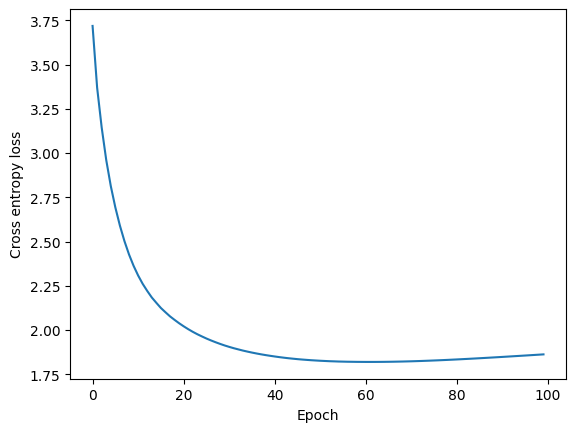

In [ ]:
mlpLeaky_trained_64 = train(mlpLeaky[1], opt5s[1], X_train, train_label, GRADIENT_STEPS)

In [ ]:
evaluate_acc(test_label, mlpLeaky_trained_64.forward(X_test))

0.48661461238148357

**3.3 - Add L2 regularization to model**

In [ ]:
#Have to adjust train/loss function

# network weights for layers ℓ ∈ {1, 2, o} taken into account
def l2_regularization(weights, lam): #lam = lambda
  reg_total = 0.0
  for w in weights:
    reg_total += lam * np.sum(w**2)
  return reg_total

def train_L2(mlp, optimizer, data_x, data_y, steps, lam): #same parameters as before just added lambda
    losses = []
    labels = np.eye(25)[np.array(data_y)]
    for _ in tqdm(range(steps)):
        predictions = mlp.forward(data_x)
        loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
        #CHANGE : Adding L2 regularization: ###################################################
        weights = [layer.parameters[0] for layer in mlp.layers if layer.parameters is not None]
        loss += (l2_regularization(weights, lam)) / (data_x.shape[0])
        #######################################################################################
        losses.append(loss)
        mlp.backward(labels)
        optimizer.step(lam) #CHANGE : need to pass lambda for L2
        print(loss)
    print(losses)
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.show()

    return mlp

In [ ]:
#Need to adjust gradient

class StochasticGradientDescentOptimizer_L2(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net) #calls the initializer of the base Optimizer class -> stores the neural network it will optimize
        self.lr = lr # step size used during the optimization update

    def step(self, lam): #CHANGE : added lambda as parameter
        # SGD - step function updates parameters for each sample
        # updates parameters using current gradients
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None and layer.gradient is not None:
                self.update(layer.parameters, layer.gradient, lam) #CHANGE L added lambda as parameter

    def update(self, params, gradients, lam): #CHANGE : added lambda as parameter
        # applying updates to each parameter tensor individually
        for param, grad in zip(params, gradients):
            if grad.shape != param.shape:
                grad = np.mean(grad, axis=0)
            #CHANGE:
            if len(param.shape) > 1:
                param -= self.lr * (grad + lam * param)  # only weights are regularized
            else:
                param -= self.lr * grad  # biases are not regularized

In [ ]:
#Model 3 : An MLP with 2 hidden layers having ReLU activations

lambda_r = 0.01  # Can experiment with different values if we want

#mlp3s defined previously still stands

#opt3s needs to be redone since gradient changed
opt3s = [StochasticGradientDescentOptimizer_L2(mlp, 1e-1) for mlp in mlp3s]

#Added lambda to train objects now below

  1%|          | 1/100 [00:04<07:23,  4.48s/it]

3.7630912646896943


  2%|▏         | 2/100 [00:08<07:17,  4.46s/it]

3.494025386914822


  3%|▎         | 3/100 [00:13<07:15,  4.49s/it]

3.34284934563768


  4%|▍         | 4/100 [00:18<07:18,  4.56s/it]

3.191163300650924


  5%|▌         | 5/100 [00:22<07:09,  4.52s/it]

3.0854549680756316


  6%|▌         | 6/100 [00:27<07:05,  4.52s/it]

2.9804758128314246


  7%|▋         | 7/100 [00:31<06:59,  4.51s/it]

2.8917176511202687


  8%|▊         | 8/100 [00:36<06:53,  4.49s/it]

2.8081748640971966


  9%|▉         | 9/100 [00:40<06:48,  4.49s/it]

2.7311328979967318


 10%|█         | 10/100 [00:44<06:43,  4.48s/it]

2.6632889470300203


 11%|█         | 11/100 [00:49<06:38,  4.48s/it]

2.6042124983644444


 12%|█▏        | 12/100 [00:54<06:45,  4.61s/it]

2.5562809449124546


 13%|█▎        | 13/100 [00:58<06:37,  4.57s/it]

2.51351335326211


 14%|█▍        | 14/100 [01:03<06:28,  4.52s/it]

2.477870170689202


 15%|█▌        | 15/100 [01:08<06:32,  4.62s/it]

2.4456997424554254


 16%|█▌        | 16/100 [01:12<06:23,  4.57s/it]

2.4179724827965967


 17%|█▋        | 17/100 [01:17<06:16,  4.54s/it]

2.392716302647276


 18%|█▊        | 18/100 [01:21<06:13,  4.56s/it]

2.3702643711490228


 19%|█▉        | 19/100 [01:26<06:06,  4.53s/it]

2.3495964805570164


 20%|██        | 20/100 [01:30<06:01,  4.52s/it]

2.3306799171414965


 21%|██        | 21/100 [01:35<06:02,  4.58s/it]

2.31366517730183


 22%|██▏       | 22/100 [01:39<05:54,  4.55s/it]

2.298035077190539


 23%|██▎       | 23/100 [01:44<05:47,  4.52s/it]

2.283714984483216


 24%|██▍       | 24/100 [01:48<05:45,  4.55s/it]

2.270517510370523


 25%|██▌       | 25/100 [01:53<05:39,  4.52s/it]

2.258152501873158


 26%|██▌       | 26/100 [01:57<05:33,  4.51s/it]

2.2468139511813625


 27%|██▋       | 27/100 [02:02<05:33,  4.57s/it]

2.236221652356558


 28%|██▊       | 28/100 [02:06<05:27,  4.54s/it]

2.22620955870601


 29%|██▉       | 29/100 [02:11<05:21,  4.52s/it]

2.2170429472329336


 30%|███       | 30/100 [02:16<05:22,  4.61s/it]

2.2084700256857004


 31%|███       | 31/100 [02:20<05:14,  4.56s/it]

2.200333412248774


 32%|███▏      | 32/100 [02:25<05:08,  4.54s/it]

2.192727977635644


 33%|███▎      | 33/100 [02:30<05:11,  4.64s/it]

2.1857002339256177


 34%|███▍      | 34/100 [02:34<05:02,  4.58s/it]

2.1789969365716506


 35%|███▌      | 35/100 [02:38<04:55,  4.55s/it]

2.172617819137236


 36%|███▌      | 36/100 [02:43<04:54,  4.60s/it]

2.1666142788145235


 37%|███▋      | 37/100 [02:48<04:47,  4.57s/it]

2.1609944335770592


 38%|███▊      | 38/100 [02:52<04:41,  4.54s/it]

2.1556630944579633


 39%|███▉      | 39/100 [02:57<04:39,  4.57s/it]

2.1506439693962536


 40%|████      | 40/100 [03:01<04:32,  4.54s/it]

2.145763844065282


 41%|████      | 41/100 [03:06<04:27,  4.53s/it]

2.141229005284079


 42%|████▏     | 42/100 [03:10<04:24,  4.55s/it]

2.136951947704668


 43%|████▎     | 43/100 [03:15<04:17,  4.51s/it]

2.1328588534927


 44%|████▍     | 44/100 [03:19<04:12,  4.51s/it]

2.1289416004046213


 45%|████▌     | 45/100 [03:24<04:09,  4.54s/it]

2.1252538644927585


 46%|████▌     | 46/100 [03:28<04:04,  4.52s/it]

2.1217879279179748


 47%|████▋     | 47/100 [03:33<03:59,  4.51s/it]

2.11849728869724


 48%|████▊     | 48/100 [03:38<03:58,  4.59s/it]

2.115459983579622


 49%|████▉     | 49/100 [03:42<03:51,  4.55s/it]

2.1126295918224094


 50%|█████     | 50/100 [03:47<03:46,  4.53s/it]

2.109956464185643


 51%|█████     | 51/100 [03:51<03:43,  4.56s/it]

2.1075243092442233


 52%|█████▏    | 52/100 [03:56<03:37,  4.53s/it]

2.105263936909885


 53%|█████▎    | 53/100 [04:00<03:31,  4.51s/it]

2.103162818046361


 54%|█████▍    | 54/100 [04:05<03:28,  4.54s/it]

2.1012099536419355


 55%|█████▌    | 55/100 [04:09<03:23,  4.52s/it]

2.0994219738603483


 56%|█████▌    | 56/100 [04:14<03:18,  4.50s/it]

2.0977604375153054


 57%|█████▋    | 57/100 [04:18<03:17,  4.59s/it]

2.096256097722429


 58%|█████▊    | 58/100 [04:23<03:10,  4.54s/it]

2.0949181910041372


 59%|█████▉    | 59/100 [04:27<03:05,  4.53s/it]

2.0935977229126648


 60%|██████    | 60/100 [04:32<03:03,  4.58s/it]

2.092407220852377


 61%|██████    | 61/100 [04:37<02:57,  4.55s/it]

2.0913921107395517


 62%|██████▏   | 62/100 [04:41<02:52,  4.55s/it]

2.090529096714978


 63%|██████▎   | 63/100 [04:46<02:49,  4.58s/it]

2.0897856728849833


 64%|██████▍   | 64/100 [04:50<02:43,  4.55s/it]

2.089149857110427


 65%|██████▌   | 65/100 [04:55<02:38,  4.53s/it]

2.0885983535335897


 66%|██████▌   | 66/100 [04:59<02:34,  4.56s/it]

2.088177049999131


 67%|██████▋   | 67/100 [05:04<02:29,  4.54s/it]

2.087816998596195


 68%|██████▊   | 68/100 [05:08<02:24,  4.52s/it]

2.087607410336447


 69%|██████▉   | 69/100 [05:13<02:21,  4.56s/it]

2.0874693569867424


 70%|███████   | 70/100 [05:17<02:15,  4.53s/it]

2.087483657500836


 71%|███████   | 71/100 [05:22<02:10,  4.52s/it]

2.0875596761418653


 72%|███████▏  | 72/100 [05:27<02:07,  4.55s/it]

2.0877668811164964


 73%|███████▎  | 73/100 [05:31<02:02,  4.52s/it]

2.0880657290265385


 74%|███████▍  | 74/100 [05:36<01:57,  4.53s/it]

2.0884529029030325


 75%|███████▌  | 75/100 [05:40<01:53,  4.55s/it]

2.0889068140945177


 76%|███████▌  | 76/100 [05:45<01:48,  4.52s/it]

2.089390276014001


 77%|███████▋  | 77/100 [05:49<01:43,  4.51s/it]

2.0899710266792684


 78%|███████▊  | 78/100 [05:54<01:40,  4.57s/it]

2.090638694715033


 79%|███████▉  | 79/100 [05:58<01:35,  4.56s/it]

2.0913656855280314


 80%|████████  | 80/100 [06:03<01:30,  4.54s/it]

2.092151246738209


 81%|████████  | 81/100 [06:08<01:27,  4.58s/it]

2.0929769245240366


 82%|████████▏ | 82/100 [06:12<01:21,  4.55s/it]

2.0938785276651295


 83%|████████▎ | 83/100 [06:17<01:17,  4.54s/it]

2.0948334732666343


 84%|████████▍ | 84/100 [06:21<01:14,  4.65s/it]

2.095800050315639


 85%|████████▌ | 85/100 [06:26<01:08,  4.60s/it]

2.0967951373968083


 86%|████████▌ | 86/100 [06:30<01:04,  4.58s/it]

2.0977799721777437


 87%|████████▋ | 87/100 [06:35<01:00,  4.65s/it]

2.0988350400057865


 88%|████████▊ | 88/100 [06:40<00:55,  4.58s/it]

2.0999505277623842


 89%|████████▉ | 89/100 [06:44<00:50,  4.58s/it]

2.101070137810633


 90%|█████████ | 90/100 [06:49<00:45,  4.58s/it]

2.102245422466525


 91%|█████████ | 91/100 [06:53<00:40,  4.54s/it]

2.1034517098112424


 92%|█████████▏| 92/100 [06:58<00:36,  4.53s/it]

2.1046819810928312


 93%|█████████▎| 93/100 [07:02<00:31,  4.55s/it]

2.1059417352882925


 94%|█████████▍| 94/100 [07:07<00:27,  4.53s/it]

2.1072282864653356


 95%|█████████▌| 95/100 [07:11<00:22,  4.53s/it]

2.1085246974621388


 96%|█████████▌| 96/100 [07:16<00:18,  4.55s/it]

2.1098427207090444


 97%|█████████▋| 97/100 [07:20<00:13,  4.52s/it]

2.111206514920804


 98%|█████████▊| 98/100 [07:25<00:09,  4.51s/it]

2.1125867984195654


 99%|█████████▉| 99/100 [07:29<00:04,  4.53s/it]

2.1139703486043273


100%|██████████| 100/100 [07:34<00:00,  4.54s/it]

2.115338517403608
[3.7630912646896943, 3.494025386914822, 3.34284934563768, 3.191163300650924, 3.0854549680756316, 2.9804758128314246, 2.8917176511202687, 2.8081748640971966, 2.7311328979967318, 2.6632889470300203, 2.6042124983644444, 2.5562809449124546, 2.51351335326211, 2.477870170689202, 2.4456997424554254, 2.4179724827965967, 2.392716302647276, 2.3702643711490228, 2.3495964805570164, 2.3306799171414965, 2.31366517730183, 2.298035077190539, 2.283714984483216, 2.270517510370523, 2.258152501873158, 2.2468139511813625, 2.236221652356558, 2.22620955870601, 2.2170429472329336, 2.2084700256857004, 2.200333412248774, 2.192727977635644, 2.1857002339256177, 2.1789969365716506, 2.172617819137236, 2.1666142788145235, 2.1609944335770592, 2.1556630944579633, 2.1506439693962536, 2.145763844065282, 2.141229005284079, 2.136951947704668, 2.1328588534927, 2.1289416004046213, 2.1252538644927585, 2.1217879279179748, 2.11849728869724, 2.115459983579622, 2.1126295918224094, 2.109956464185643, 2.107524309

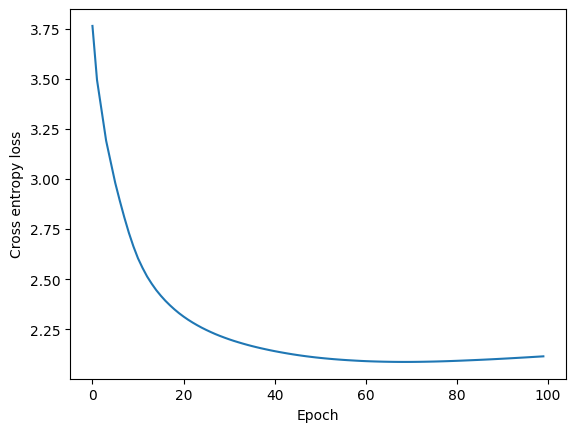

In [ ]:
#Note 200 was tested before and it was overfitting, just showing 100
mlp3_trained_32_L2 = train_L2(mlp3s[0], opt3s[0], X_train, train_label, GRADIENT_STEPS, lambda_r)

In [ ]:
hidden32_mlp3_L2_acc = evaluate_acc(test_label, mlp3_trained_32_L2.forward(X_test))
hidden32_mlp3_L2_acc

0.39988845510317905

  1%|          | 1/100 [00:08<14:26,  8.76s/it]

3.709340593579712


  2%|▏         | 2/100 [00:17<14:27,  8.85s/it]

3.3919556185697863


  3%|▎         | 3/100 [00:26<14:13,  8.80s/it]

3.170441805164455


  4%|▍         | 4/100 [00:35<14:12,  8.88s/it]

2.9872468353718786


  5%|▌         | 5/100 [00:44<14:00,  8.84s/it]

2.8363299994718494


  6%|▌         | 6/100 [00:52<13:48,  8.81s/it]

2.717982189583607


  7%|▋         | 7/100 [01:02<13:51,  8.94s/it]

2.6180180220373215


  8%|▊         | 8/100 [01:10<13:36,  8.88s/it]

2.539276327647596


  9%|▉         | 9/100 [01:19<13:25,  8.85s/it]

2.4640581272634483


 10%|█         | 10/100 [01:28<13:28,  8.99s/it]

2.409738017573579


 11%|█         | 11/100 [01:37<13:12,  8.90s/it]

2.3499377484679047


 12%|█▏        | 12/100 [01:46<13:00,  8.86s/it]

2.312522257375116


 13%|█▎        | 13/100 [01:55<13:00,  8.97s/it]

2.2602727040499704


 14%|█▍        | 14/100 [02:04<12:45,  8.91s/it]

2.23929041683367


 15%|█▌        | 15/100 [02:13<12:32,  8.85s/it]

2.191271009387927


 16%|█▌        | 16/100 [02:22<12:27,  8.90s/it]

2.1798676750708896


 17%|█▋        | 17/100 [02:30<12:13,  8.84s/it]

2.1373173477148946


 18%|█▊        | 18/100 [02:39<12:03,  8.82s/it]

2.1286422585772216


 19%|█▉        | 19/100 [02:48<11:54,  8.82s/it]

2.0921220479142297


 20%|██        | 20/100 [02:57<11:43,  8.80s/it]

2.08508538657603


 21%|██        | 21/100 [03:05<11:32,  8.76s/it]

2.053800496724261


 22%|██▏       | 22/100 [03:14<11:26,  8.80s/it]

2.048788207519234


 23%|██▎       | 23/100 [03:23<11:17,  8.81s/it]

2.022467131212643


 24%|██▍       | 24/100 [03:32<11:06,  8.77s/it]

2.018051192731338


 25%|██▌       | 25/100 [03:41<11:00,  8.81s/it]

1.9968684192455388


 26%|██▌       | 26/100 [03:49<10:50,  8.79s/it]

1.9928511555379294


 27%|██▋       | 27/100 [03:58<10:39,  8.76s/it]

1.975512302597514


 28%|██▊       | 28/100 [04:07<10:34,  8.81s/it]

1.9721357146404812


 29%|██▉       | 29/100 [04:16<10:24,  8.79s/it]

1.9582576560638474


 30%|███       | 30/100 [04:24<10:12,  8.75s/it]

1.9556432355621285


 31%|███       | 31/100 [04:33<10:07,  8.81s/it]

1.9441793495032962


 32%|███▏      | 32/100 [04:42<09:57,  8.79s/it]

1.9422665957422223


 33%|███▎      | 33/100 [04:51<09:46,  8.76s/it]

1.9332070684039342


 34%|███▍      | 34/100 [05:00<09:38,  8.76s/it]

1.9312098703245104


 35%|███▌      | 35/100 [05:08<09:28,  8.75s/it]

1.9244811840009621


 36%|███▌      | 36/100 [05:17<09:19,  8.75s/it]

1.9228035114038553


 37%|███▋      | 37/100 [05:26<09:10,  8.73s/it]

1.9178041588608488


 38%|███▊      | 38/100 [05:35<09:02,  8.75s/it]

1.9165669031384125


 39%|███▉      | 39/100 [05:43<08:51,  8.72s/it]

1.9128847051229245


 40%|████      | 40/100 [05:52<08:43,  8.73s/it]

1.9120599680108117


 41%|████      | 41/100 [06:01<08:34,  8.72s/it]

1.9094741140138374


 42%|████▏     | 42/100 [06:09<08:27,  8.74s/it]

1.9091378648252608


 43%|████▎     | 43/100 [06:18<08:19,  8.77s/it]

1.9075806956383128


 44%|████▍     | 44/100 [06:27<08:10,  8.76s/it]

1.907322700148393


 45%|████▌     | 45/100 [06:36<08:03,  8.79s/it]

1.9065087351538599


 46%|████▌     | 46/100 [06:45<07:53,  8.77s/it]

1.90640457881558


 47%|████▋     | 47/100 [06:53<07:45,  8.77s/it]

1.906298587891307


 48%|████▊     | 48/100 [07:02<07:37,  8.80s/it]

1.9066982972363327


 49%|████▉     | 49/100 [07:11<07:28,  8.79s/it]

1.9071542914993667


 50%|█████     | 50/100 [07:20<07:19,  8.79s/it]

1.908011293426993


 51%|█████     | 51/100 [07:29<07:10,  8.79s/it]

1.9088530524478462


 52%|█████▏    | 52/100 [07:37<07:01,  8.79s/it]

1.9098547382906226


 53%|█████▎    | 53/100 [07:46<06:52,  8.77s/it]

1.9109970361897048


 54%|█████▍    | 54/100 [07:55<06:46,  8.84s/it]

1.9123259602643885


 55%|█████▌    | 55/100 [08:04<06:36,  8.81s/it]

1.913771569095144


 56%|█████▌    | 56/100 [08:13<06:26,  8.78s/it]

1.9153401117917208


 57%|█████▋    | 57/100 [08:21<06:18,  8.80s/it]

1.9170677157960527


 58%|█████▊    | 58/100 [08:30<06:09,  8.79s/it]

1.9188501020847306


 59%|█████▉    | 59/100 [08:39<05:59,  8.78s/it]

1.9209166937395843


 60%|██████    | 60/100 [08:48<05:54,  8.86s/it]

1.92308341610415


 61%|██████    | 61/100 [08:57<05:44,  8.82s/it]

1.9253694156232022


 62%|██████▏   | 62/100 [09:05<05:33,  8.79s/it]

1.9276961787081632


 63%|██████▎   | 63/100 [09:14<05:26,  8.83s/it]

1.9301535513910966


 64%|██████▍   | 64/100 [09:23<05:17,  8.81s/it]

1.9327272703421499


 65%|██████▌   | 65/100 [09:32<05:06,  8.76s/it]

1.9354206860318857


 66%|██████▌   | 66/100 [09:41<04:59,  8.80s/it]

1.9381872384607088


 67%|██████▋   | 67/100 [09:49<04:49,  8.77s/it]

1.9410904166124434


 68%|██████▊   | 68/100 [09:58<04:40,  8.75s/it]

1.9440642676001345


 69%|██████▉   | 69/100 [10:07<04:32,  8.79s/it]

1.9471023116659414


 70%|███████   | 70/100 [10:16<04:23,  8.77s/it]

1.9502041284382807


 71%|███████   | 71/100 [10:24<04:13,  8.74s/it]

1.9533676441144645


 72%|███████▏  | 72/100 [10:33<04:06,  8.81s/it]

1.9565480252181608


 73%|███████▎  | 73/100 [10:42<03:56,  8.78s/it]

1.9597307443743643


 74%|███████▍  | 74/100 [10:51<03:47,  8.75s/it]

1.9630231690818492


 75%|███████▌  | 75/100 [10:59<03:38,  8.76s/it]

1.9663447552583775


 76%|███████▌  | 76/100 [11:08<03:30,  8.75s/it]

1.9697163066545584


 77%|███████▋  | 77/100 [11:17<03:20,  8.73s/it]

1.9731544180218707


 78%|███████▊  | 78/100 [11:26<03:12,  8.74s/it]

1.976574115126967


 79%|███████▉  | 79/100 [11:34<03:03,  8.76s/it]

1.9799816868364535


 80%|████████  | 80/100 [11:43<02:54,  8.73s/it]

1.9834640021863017


 81%|████████  | 81/100 [11:52<02:45,  8.73s/it]

1.9869676649289427


 82%|████████▏ | 82/100 [12:01<02:37,  8.74s/it]

1.9905759236582397


 83%|████████▎ | 83/100 [12:09<02:28,  8.73s/it]

1.99424708603048


 84%|████████▍ | 84/100 [12:18<02:19,  8.74s/it]

1.9979548979549158


 85%|████████▌ | 85/100 [12:27<02:11,  8.74s/it]

2.0016982345933503


 86%|████████▌ | 86/100 [12:36<02:02,  8.73s/it]

2.005492051340756


 87%|████████▋ | 87/100 [12:44<01:53,  8.73s/it]

2.0092787115857798


 88%|████████▊ | 88/100 [12:53<01:44,  8.73s/it]

2.013112107771858


 89%|████████▉ | 89/100 [13:02<01:36,  8.74s/it]

2.016978535567923


 90%|█████████ | 90/100 [13:11<01:27,  8.76s/it]

2.0208868874868022


 91%|█████████ | 91/100 [13:19<01:18,  8.77s/it]

2.0248314527977413


 92%|█████████▏| 92/100 [13:28<01:10,  8.77s/it]

2.0287781629993176


 93%|█████████▎| 93/100 [13:37<01:01,  8.75s/it]

2.032739279152351


 94%|█████████▍| 94/100 [13:46<00:52,  8.74s/it]

2.03670990397866


 95%|█████████▌| 95/100 [13:54<00:43,  8.78s/it]

2.0407125990471933


 96%|█████████▌| 96/100 [14:03<00:35,  8.76s/it]

2.044711883764611


 97%|█████████▋| 97/100 [14:12<00:26,  8.75s/it]

2.0487166113171904


 98%|█████████▊| 98/100 [14:21<00:17,  8.81s/it]

2.052714293188078


 99%|█████████▉| 99/100 [14:29<00:08,  8.76s/it]

2.056734509414094


100%|██████████| 100/100 [14:38<00:00,  8.79s/it]

2.0607692355543543
[3.709340593579712, 3.3919556185697863, 3.170441805164455, 2.9872468353718786, 2.8363299994718494, 2.717982189583607, 2.6180180220373215, 2.539276327647596, 2.4640581272634483, 2.409738017573579, 2.3499377484679047, 2.312522257375116, 2.2602727040499704, 2.23929041683367, 2.191271009387927, 2.1798676750708896, 2.1373173477148946, 2.1286422585772216, 2.0921220479142297, 2.08508538657603, 2.053800496724261, 2.048788207519234, 2.022467131212643, 2.018051192731338, 1.9968684192455388, 1.9928511555379294, 1.975512302597514, 1.9721357146404812, 1.9582576560638474, 1.9556432355621285, 1.9441793495032962, 1.9422665957422223, 1.9332070684039342, 1.9312098703245104, 1.9244811840009621, 1.9228035114038553, 1.9178041588608488, 1.9165669031384125, 1.9128847051229245, 1.9120599680108117, 1.9094741140138374, 1.9091378648252608, 1.9075806956383128, 1.907322700148393, 1.9065087351538599, 1.90640457881558, 1.906298587891307, 1.9066982972363327, 1.9071542914993667, 1.908011293426993, 1

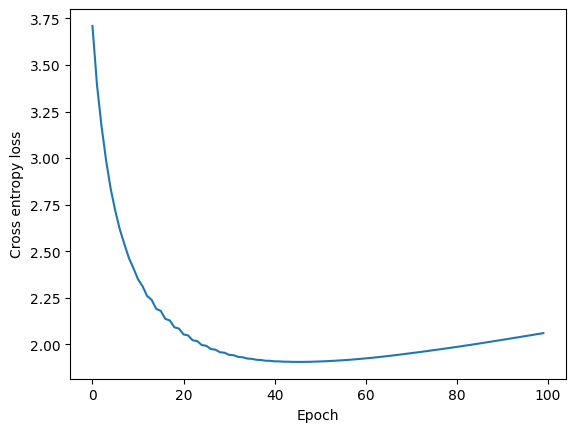

In [ ]:
mlp3_trained_64_L2 = train_L2(mlp3s[1], opt3s[1], X_train, train_label, GRADIENT_STEPS, lambda_r)

In [ ]:
hidden64_mlp3_L2_acc = evaluate_acc(test_label, mlp3_trained_64_L2.forward(X_test))
hidden64_mlp3_L2_acc

0.4421360847741216

In [ ]:
#Not run due to crash
mlp3_trained_128_L2 = train_L2(mlp3s[2], opt3s[2], X_train, train_label, GRADIENT_STEPS, lambda_r)
mlp3_trained_248_L2 = train_L2(mlp3s[2], opt3s[2], X_train, train_label, GRADIENT_STEPS, lambda_r)

  0%|          | 1/200 [00:04<13:40,  4.12s/it]

3.6802537170296223


  1%|          | 2/200 [00:09<15:44,  4.77s/it]

3.4970962685126232


  2%|▏         | 3/200 [00:13<14:45,  4.49s/it]

3.3565755544650013


  2%|▏         | 4/200 [00:18<14:58,  4.58s/it]

3.236058531910339


  2%|▎         | 5/200 [00:22<14:40,  4.51s/it]

3.133678089781718


  3%|▎         | 6/200 [00:26<14:16,  4.41s/it]

3.0436816273997818


  4%|▎         | 7/200 [00:30<13:55,  4.33s/it]

2.9641618333718847


  4%|▍         | 8/200 [00:35<14:02,  4.39s/it]

2.8934955498616244


  4%|▍         | 9/200 [00:39<13:45,  4.32s/it]

2.830960264036266


  5%|▌         | 10/200 [00:43<13:35,  4.29s/it]

2.775055094412694


  6%|▌         | 11/200 [00:48<13:33,  4.31s/it]

2.724630968518544


  6%|▌         | 12/200 [00:52<13:20,  4.26s/it]

2.6787839638237636


  6%|▋         | 13/200 [00:56<13:07,  4.21s/it]

2.6371166100157195


  7%|▋         | 14/200 [01:00<13:09,  4.25s/it]

2.5996434197724803


  8%|▊         | 15/200 [01:04<12:58,  4.21s/it]

2.5655066831347497


  8%|▊         | 16/200 [01:09<12:53,  4.20s/it]

2.533973785643676


  8%|▊         | 17/200 [01:13<12:58,  4.25s/it]

2.505277870623187


  9%|▉         | 18/200 [01:17<12:47,  4.21s/it]

2.4787103972554787


 10%|▉         | 19/200 [01:21<12:37,  4.19s/it]

2.4542098732439204


 10%|█         | 20/200 [01:25<12:33,  4.19s/it]

2.430984976888996


 10%|█         | 21/200 [01:30<12:27,  4.17s/it]

2.409194261513708


 11%|█         | 22/200 [01:34<12:20,  4.16s/it]

2.3888513617936535


 12%|█▏        | 23/200 [01:38<12:18,  4.17s/it]

2.3697168079616207


 12%|█▏        | 24/200 [01:42<12:14,  4.17s/it]

2.351710788533735


 12%|█▎        | 25/200 [01:46<12:09,  4.17s/it]

2.3347733900221215


 13%|█▎        | 26/200 [01:50<12:05,  4.17s/it]

2.319072033520551


 14%|█▎        | 27/200 [01:55<12:00,  4.16s/it]

2.30426256419973


 14%|█▍        | 28/200 [01:59<12:00,  4.19s/it]

2.2903164776514604


 14%|█▍        | 29/200 [02:03<11:57,  4.19s/it]

2.2771834573950605


 15%|█▌        | 30/200 [02:07<11:54,  4.20s/it]

2.264786187843943


 16%|█▌        | 31/200 [02:11<11:46,  4.18s/it]

2.252961079165114


 16%|█▌        | 32/200 [02:16<11:41,  4.18s/it]

2.2417759425502277


 16%|█▋        | 33/200 [02:20<11:45,  4.22s/it]

2.2309629727837708


 17%|█▋        | 34/200 [02:24<11:37,  4.20s/it]

2.2207594589175415


 18%|█▊        | 35/200 [02:28<11:33,  4.20s/it]

2.210831949708018


 18%|█▊        | 36/200 [02:33<11:33,  4.23s/it]

2.2015383023926516


 18%|█▊        | 37/200 [02:37<11:23,  4.19s/it]

2.192504195569479


 19%|█▉        | 38/200 [02:41<11:21,  4.21s/it]

2.183933114699822


 20%|█▉        | 39/200 [02:45<11:17,  4.21s/it]

2.175561743852847


 20%|██        | 40/200 [02:49<11:10,  4.19s/it]

2.1676328800434437


 20%|██        | 41/200 [02:53<11:03,  4.18s/it]

2.1598919328381547


 21%|██        | 42/200 [02:58<11:03,  4.20s/it]

2.152694724726252


 22%|██▏       | 43/200 [03:02<10:55,  4.17s/it]

2.145595341996253


 22%|██▏       | 44/200 [03:06<10:49,  4.17s/it]

2.138995476923069


 22%|██▎       | 45/200 [03:10<11:04,  4.28s/it]

2.1324717108888995


 23%|██▎       | 46/200 [03:15<11:00,  4.29s/it]

2.126518603604782


 24%|██▎       | 47/200 [03:19<10:47,  4.23s/it]

2.120547714241715


 24%|██▍       | 48/200 [03:23<10:46,  4.25s/it]

2.11526726017454


 24%|██▍       | 49/200 [03:27<10:40,  4.24s/it]

2.1097036628598413


 25%|██▌       | 50/200 [03:32<10:35,  4.23s/it]

2.1048121597050167


 26%|██▌       | 51/200 [03:36<10:40,  4.30s/it]

2.0997361593185127


 26%|██▌       | 52/200 [03:40<10:28,  4.25s/it]

2.0951526246171297


 26%|██▋       | 53/200 [03:44<10:20,  4.22s/it]

2.0905503245122605


 27%|██▋       | 54/200 [03:49<10:16,  4.22s/it]

2.0863345599892136


 28%|██▊       | 55/200 [03:53<10:12,  4.22s/it]

2.0821477450655728


 28%|██▊       | 56/200 [03:57<10:07,  4.22s/it]

2.0782622093537673


 28%|██▊       | 57/200 [04:01<10:02,  4.21s/it]

2.074489031081687


 29%|██▉       | 58/200 [04:06<10:05,  4.27s/it]

2.0709418585099275


 30%|██▉       | 59/200 [04:10<10:00,  4.26s/it]

2.067634013307662


 30%|███       | 60/200 [04:14<09:57,  4.26s/it]

2.0643971815613638


 30%|███       | 61/200 [04:18<09:49,  4.24s/it]

2.06132128216134


 31%|███       | 62/200 [04:22<09:43,  4.23s/it]

2.058298082606502


 32%|███▏      | 63/200 [04:27<09:41,  4.24s/it]

2.055538921561525


 32%|███▏      | 64/200 [04:31<09:36,  4.24s/it]

2.052841185691948


 32%|███▎      | 65/200 [04:35<09:28,  4.21s/it]

2.0504417629453484


 33%|███▎      | 66/200 [04:39<09:24,  4.21s/it]

2.048025239520826


 34%|███▎      | 67/200 [04:43<09:16,  4.19s/it]

2.045901815916365


 34%|███▍      | 68/200 [04:48<09:10,  4.17s/it]

2.043858502037409


 34%|███▍      | 69/200 [04:52<09:07,  4.18s/it]

2.041918195051657


 35%|███▌      | 70/200 [04:56<09:02,  4.18s/it]

2.040085581004921


 36%|███▌      | 71/200 [05:00<08:55,  4.15s/it]

2.0382996534161


 36%|███▌      | 72/200 [05:04<08:53,  4.17s/it]

2.0367351277639174


 36%|███▋      | 73/200 [05:08<08:50,  4.18s/it]

2.035202494553817


 37%|███▋      | 74/200 [05:13<08:47,  4.19s/it]

2.033794292075122


 38%|███▊      | 75/200 [05:17<08:43,  4.19s/it]

2.032517297115976


 38%|███▊      | 76/200 [05:21<08:44,  4.23s/it]

2.0313336111771556


 38%|███▊      | 77/200 [05:25<08:37,  4.21s/it]

2.0302618484458064


 39%|███▉      | 78/200 [05:30<08:36,  4.23s/it]

2.0292647724030584


 40%|███▉      | 79/200 [05:34<08:40,  4.30s/it]

2.0283810915948615


 40%|████      | 80/200 [05:38<08:32,  4.27s/it]

2.0275939594097947


 40%|████      | 81/200 [05:43<08:28,  4.27s/it]

2.026906121327073


 41%|████      | 82/200 [05:47<08:26,  4.30s/it]

2.0262803031948704


 42%|████▏     | 83/200 [05:51<08:20,  4.28s/it]

2.025746681502066


 42%|████▏     | 84/200 [05:55<08:17,  4.29s/it]

2.025278812059203


 42%|████▎     | 85/200 [06:00<08:15,  4.31s/it]

2.024963095216972


 43%|████▎     | 86/200 [06:04<08:08,  4.28s/it]

2.0247362740995953


 44%|████▎     | 87/200 [06:08<08:03,  4.28s/it]

2.0245976358652293


 44%|████▍     | 88/200 [06:13<08:02,  4.31s/it]

2.024553358375505


 44%|████▍     | 89/200 [06:17<07:54,  4.27s/it]

2.024580370214085


 45%|████▌     | 90/200 [06:21<07:47,  4.25s/it]

2.024648581388502


 46%|████▌     | 91/200 [06:25<07:45,  4.27s/it]

2.024833694092664


 46%|████▌     | 92/200 [06:30<07:39,  4.25s/it]

2.0251170027651653


 46%|████▋     | 93/200 [06:34<07:32,  4.23s/it]

2.0254637386160135


 47%|████▋     | 94/200 [06:38<07:39,  4.33s/it]

2.02581712042124


 48%|████▊     | 95/200 [06:43<07:29,  4.28s/it]

2.0262120528286185


 48%|████▊     | 96/200 [06:47<07:25,  4.28s/it]

2.0266576267848704


 48%|████▊     | 97/200 [06:51<07:25,  4.32s/it]

2.0272047372537996


 49%|████▉     | 98/200 [06:55<07:18,  4.29s/it]

2.0277666417698295


 50%|████▉     | 99/200 [07:00<07:11,  4.27s/it]

2.028362160619605


 50%|█████     | 100/200 [07:04<07:13,  4.33s/it]

2.0290218279256274


 50%|█████     | 101/200 [07:08<07:07,  4.31s/it]

2.029715054702952


 51%|█████     | 102/200 [07:13<07:02,  4.31s/it]

2.030434558097962


 52%|█████▏    | 103/200 [07:17<06:58,  4.31s/it]

2.0312549624144287


 52%|█████▏    | 104/200 [07:21<06:51,  4.29s/it]

2.03214865427062


 52%|█████▎    | 105/200 [07:25<06:46,  4.27s/it]

2.0330944383454708


 53%|█████▎    | 106/200 [07:30<06:43,  4.29s/it]

2.034086220456167


 54%|█████▎    | 107/200 [07:34<06:37,  4.28s/it]

2.0351118885750195


 54%|█████▍    | 108/200 [07:38<06:32,  4.27s/it]

2.0361673816332395


 55%|█████▍    | 109/200 [07:43<06:31,  4.30s/it]

2.037320088313229


 55%|█████▌    | 110/200 [07:47<06:26,  4.30s/it]

2.038537624569256


 56%|█████▌    | 111/200 [07:51<06:18,  4.25s/it]

2.0398265625024767


 56%|█████▌    | 112/200 [07:55<06:15,  4.27s/it]

2.0411265352449113


 56%|█████▋    | 113/200 [08:00<06:08,  4.24s/it]

2.042457596718493


 57%|█████▋    | 114/200 [08:04<06:04,  4.24s/it]

2.0437943121365336


 57%|█████▊    | 115/200 [08:08<06:01,  4.25s/it]

2.0452029302830472


 58%|█████▊    | 116/200 [08:12<05:56,  4.24s/it]

2.046640883989858


 58%|█████▊    | 117/200 [08:17<05:51,  4.23s/it]

2.0481635971892898


 59%|█████▉    | 118/200 [08:21<05:49,  4.26s/it]

2.049655219804477


 60%|█████▉    | 119/200 [08:25<05:43,  4.24s/it]

2.05118411364473


 60%|██████    | 120/200 [08:29<05:38,  4.23s/it]

2.052788082271663


 60%|██████    | 121/200 [08:34<05:35,  4.25s/it]

2.05444429729968


 61%|██████    | 122/200 [08:38<05:31,  4.25s/it]

2.056083244643443


 62%|██████▏   | 123/200 [08:42<05:25,  4.23s/it]

2.057752142838475


 62%|██████▏   | 124/200 [08:46<05:23,  4.25s/it]

2.059432445479256


 62%|██████▎   | 125/200 [08:51<05:21,  4.28s/it]

2.061132602273095


 63%|██████▎   | 126/200 [08:55<05:15,  4.26s/it]

2.0628848619711526


 64%|██████▎   | 127/200 [08:59<05:11,  4.27s/it]

2.064647991050224


 64%|██████▍   | 128/200 [09:04<05:09,  4.30s/it]

2.066444155709701


 64%|██████▍   | 129/200 [09:08<05:03,  4.27s/it]

2.068291258271806


 65%|██████▌   | 130/200 [09:12<04:59,  4.28s/it]

2.0701406592544727


 66%|██████▌   | 131/200 [09:16<04:56,  4.30s/it]

2.07205168748779


 66%|██████▌   | 132/200 [09:21<04:49,  4.26s/it]

2.073987640607323


 66%|██████▋   | 133/200 [09:25<04:45,  4.26s/it]

2.0759607775186075


 67%|██████▋   | 134/200 [09:29<04:42,  4.27s/it]

2.0779613005461433


 68%|██████▊   | 135/200 [09:33<04:36,  4.25s/it]

2.0800201415775716


 68%|██████▊   | 136/200 [09:38<04:32,  4.26s/it]

2.0821111140344475


 68%|██████▊   | 137/200 [09:42<04:28,  4.26s/it]

2.084216516521951


 69%|██████▉   | 138/200 [09:46<04:22,  4.24s/it]

2.0863368475414767


 70%|██████▉   | 139/200 [09:50<04:18,  4.24s/it]

2.0884862321423325


 70%|███████   | 140/200 [09:55<04:17,  4.30s/it]

2.090662849832394


 70%|███████   | 141/200 [09:59<04:12,  4.28s/it]

2.092858581614927


 71%|███████   | 142/200 [10:03<04:08,  4.29s/it]

2.095093741293877


 72%|███████▏  | 143/200 [10:08<04:09,  4.37s/it]

2.0973405777976994


 72%|███████▏  | 144/200 [10:12<04:03,  4.35s/it]

2.0996004628268685


 72%|███████▎  | 145/200 [10:16<03:57,  4.33s/it]

2.1018657133359033


 73%|███████▎  | 146/200 [10:21<03:54,  4.35s/it]

2.1041704153158753


 74%|███████▎  | 147/200 [10:25<03:47,  4.29s/it]

2.1065088745914213


 74%|███████▍  | 148/200 [10:29<03:42,  4.29s/it]

2.1088841556364293


 74%|███████▍  | 149/200 [10:34<03:39,  4.31s/it]

2.1112894612014244


 75%|███████▌  | 150/200 [10:38<03:33,  4.27s/it]

2.113720164550878


 76%|███████▌  | 151/200 [10:42<03:28,  4.26s/it]

2.1161661375368856


 76%|███████▌  | 152/200 [10:46<03:25,  4.28s/it]

2.1186373093336743


 76%|███████▋  | 153/200 [10:50<03:19,  4.24s/it]

2.1211137792864445


 77%|███████▋  | 154/200 [10:55<03:14,  4.23s/it]

2.1235922239438767


 78%|███████▊  | 155/200 [10:59<03:12,  4.28s/it]

2.1260867877597116


 78%|███████▊  | 156/200 [11:03<03:07,  4.26s/it]

2.1285904891508953


 78%|███████▊  | 157/200 [11:08<03:02,  4.24s/it]

2.1311059197212936


 79%|███████▉  | 158/200 [11:12<02:59,  4.27s/it]

2.1336280531081173


 80%|███████▉  | 159/200 [11:16<02:53,  4.23s/it]

2.136142514405986


 80%|████████  | 160/200 [11:20<02:48,  4.22s/it]

2.138704128215955


 80%|████████  | 161/200 [11:24<02:44,  4.22s/it]

2.1412498076889586


 81%|████████  | 162/200 [11:29<02:40,  4.21s/it]

2.143812764565755


 82%|████████▏ | 163/200 [11:33<02:35,  4.20s/it]

2.1463894600894133


 82%|████████▏ | 164/200 [11:37<02:31,  4.21s/it]

2.1489804647921105


 82%|████████▎ | 165/200 [11:41<02:26,  4.20s/it]

2.151577699051775


 83%|████████▎ | 166/200 [11:45<02:22,  4.20s/it]

2.1541728799969873


 84%|████████▎ | 167/200 [11:50<02:18,  4.20s/it]

2.156778301113731


 84%|████████▍ | 168/200 [11:54<02:14,  4.20s/it]

2.1593857650736528


 84%|████████▍ | 169/200 [11:58<02:09,  4.19s/it]

2.162000370092263


 85%|████████▌ | 170/200 [12:02<02:06,  4.21s/it]

2.164630768621991


 86%|████████▌ | 171/200 [12:06<02:01,  4.20s/it]

2.1672797540173123


 86%|████████▌ | 172/200 [12:11<01:57,  4.19s/it]

2.1699415759268623


 86%|████████▋ | 173/200 [12:15<01:53,  4.20s/it]

2.1726067631626993


 87%|████████▋ | 174/200 [12:19<01:49,  4.22s/it]

2.1752606204111857


 88%|████████▊ | 175/200 [12:23<01:44,  4.19s/it]

2.177938613539923


 88%|████████▊ | 176/200 [12:27<01:40,  4.20s/it]

2.1806228000635905


 88%|████████▊ | 177/200 [12:32<01:36,  4.22s/it]

2.183308434635184


 89%|████████▉ | 178/200 [12:36<01:32,  4.21s/it]

2.1860135779946264


 90%|████████▉ | 179/200 [12:40<01:28,  4.21s/it]

2.1887254226266575


 90%|█████████ | 180/200 [12:44<01:24,  4.24s/it]

2.19144958294613


 90%|█████████ | 181/200 [12:49<01:20,  4.22s/it]

2.1941910146852366


 91%|█████████ | 182/200 [12:53<01:16,  4.24s/it]

2.1969477194883287


 92%|█████████▏| 183/200 [12:57<01:12,  4.25s/it]

2.199738319913846


 92%|█████████▏| 184/200 [13:01<01:07,  4.24s/it]

2.2025137310140908


 92%|█████████▎| 185/200 [13:05<01:03,  4.23s/it]

2.205300704294579


 93%|█████████▎| 186/200 [13:10<01:00,  4.30s/it]

2.208090894052243


 94%|█████████▎| 187/200 [13:14<00:55,  4.26s/it]

2.2109067588983824


 94%|█████████▍| 188/200 [13:18<00:50,  4.24s/it]

2.2137354111027934


 94%|█████████▍| 189/200 [13:23<00:46,  4.27s/it]

2.2165952084694793


 95%|█████████▌| 190/200 [13:27<00:42,  4.24s/it]

2.219469861823128


 96%|█████████▌| 191/200 [13:31<00:37,  4.22s/it]

2.2223516326945045


 96%|█████████▌| 192/200 [13:35<00:33,  4.24s/it]

2.2252196420639376


 96%|█████████▋| 193/200 [13:39<00:29,  4.20s/it]

2.228079828357134


 97%|█████████▋| 194/200 [13:44<00:25,  4.19s/it]

2.230939568804416


 98%|█████████▊| 195/200 [13:48<00:21,  4.22s/it]

2.2337909629372286


 98%|█████████▊| 196/200 [13:52<00:16,  4.21s/it]

2.2366409781593832


 98%|█████████▊| 197/200 [13:56<00:12,  4.18s/it]

2.2394904178577155


 99%|█████████▉| 198/200 [14:00<00:08,  4.19s/it]

2.242351308566957


100%|█████████▉| 199/200 [14:05<00:04,  4.17s/it]

2.245235209524131


100%|██████████| 200/200 [14:09<00:00,  4.25s/it]

2.248139027798565
[3.6802537170296223, 3.4970962685126232, 3.3565755544650013, 3.236058531910339, 3.133678089781718, 3.0436816273997818, 2.9641618333718847, 2.8934955498616244, 2.830960264036266, 2.775055094412694, 2.724630968518544, 2.6787839638237636, 2.6371166100157195, 2.5996434197724803, 2.5655066831347497, 2.533973785643676, 2.505277870623187, 2.4787103972554787, 2.4542098732439204, 2.430984976888996, 2.409194261513708, 2.3888513617936535, 2.3697168079616207, 2.351710788533735, 2.3347733900221215, 2.319072033520551, 2.30426256419973, 2.2903164776514604, 2.2771834573950605, 2.264786187843943, 2.252961079165114, 2.2417759425502277, 2.2309629727837708, 2.2207594589175415, 2.210831949708018, 2.2015383023926516, 2.192504195569479, 2.183933114699822, 2.175561743852847, 2.1676328800434437, 2.1598919328381547, 2.152694724726252, 2.145595341996253, 2.138995476923069, 2.1324717108888995, 2.126518603604782, 2.120547714241715, 2.11526726017454, 2.1097036628598413, 2.1048121597050167, 2.09973

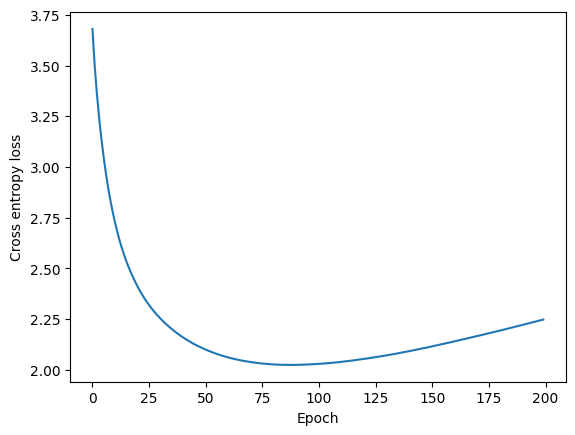

In [ ]:
mlp3_trained_32_L2_2 = train_L2(mlp3s[0], opt3s[0], X_train, train_label, GRADIENT_STEPS_2, lambda_r)

In [ ]:
hidden32_mlp3_L2_acc_2 = evaluate_acc(test_label, mlp3_trained_32_L2_2.forward(X_test))
hidden32_mlp3_L2_acc_2

#Overfitting displayed (known already just shown as extra)

0.3715839375348578

**3.4 - Create a ConvNet**

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout, BatchNormalization, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split



In [ ]:
X_train.shape

(27455, 784)

In [ ]:
#reshape for convolutional net
X_train_conv=X_train.reshape(-1,28,28,1)
X_test_conv=X_test.reshape(-1,28,28,1)

In [ ]:
X_train_conv, X_val_conv, y_train, y_val = train_test_split(
    X_train_conv, y_train, test_size=0.2, random_state=10
)


In [ ]:
hidden_sizes = [32, 64, 128, 256]
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 24
batch_size  = 64
input_shape = (28, 28, 1)
strides     = 1
padding     = 'valid' # valid: no padding, same: for zeros evenly right/left and up/down.
                      # when padding="same" and strides=1, the output has the same size as the input

In [ ]:
#conv Net with fully connected hidden layers of size 32
conv_net_32 = Sequential()

#adding 3 convolution layers
conv_net_32.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape

conv_net_32.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_32.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))

# flatten serves as a connection between the convolution and dense layers
conv_net_32.add(Flatten())

#adding 2 fully connected layers
conv_net_32.add(Dense(hidden_sizes[0], activation='relu'))
conv_net_32.add(Dense(hidden_sizes[0], activation='relu'))
conv_net_32.add(Dense(num_classes, activation='softmax')) # output layer

In [ ]:
conv_net_32.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 32)                991264    
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 24)                7

In [ ]:
conv_net_32.compile(
  'adam',                             # optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model32.hdf5",  # saving the best model
                            monitor='val_accuracy', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='max',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # when using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# fitting the model
history32 = conv_net_32.fit(
  X_train_conv,
  y_train,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_val_conv, y_val), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
344/344 [==============================] - ETA: 0s - loss: 0.6541 - accuracy: 0.8122
Epoch 1: val_accuracy improved from -inf to 0.98926, saving model to mnist_best_model32.hdf5
344/344 [==============================] - 8s 10ms/step - loss: 0.6541 - accuracy: 0.8122 - val_loss: 0.0436 - val_accuracy: 0.9893
Epoch 2/100
 17/344 [>.............................] - ETA: 2s - loss: 0.0306 - accuracy: 0.9899

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


336/344 [============================>.] - ETA: 0s - loss: 0.0566 - accuracy: 0.9836
Epoch 2: val_accuracy improved from 0.98926 to 0.99454, saving model to mnist_best_model32.hdf5
344/344 [==============================] - 3s 7ms/step - loss: 0.0556 - accuracy: 0.9838 - val_loss: 0.0192 - val_accuracy: 0.9945
Epoch 3/100
337/344 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997
Epoch 3: val_accuracy improved from 0.99454 to 1.00000, saving model to mnist_best_model32.hdf5
344/344 [==============================] - 2s 7ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 4.0870e-04 - val_accuracy: 1.0000
Epoch 4/100
339/344 [============================>.] - ETA: 0s - loss: 1.7150e-04 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
344/344 [==============================] - 2s 7ms/step - loss: 1.7066e-04 - accuracy: 1.0000 - val_loss: 1.7277e-04 - val_accuracy: 1.0000
Epoch 5/100
338/344 [============================>.] - ETA: 0s - loss

In [ ]:
conv_net_32.load_weights("mnist_best_model32.hdf5")

loss32, acc32 = conv_net_32.evaluate(X_test_conv, y_test, verbose=2)
print("Hidden Unit Size 32")
print("test accuracy: {:5.2f}%".format(100 * acc32))
print("test loss: {:5.2f}".format(loss32))

225/225 - 1s - loss: 1.5831 - accuracy: 0.8157 - 845ms/epoch - 4ms/step
Hidden Unit Size 32
test accuracy: 81.57%
test loss:  1.58


In [ ]:
#conv Net with fully connected hidden layers of size 64
conv_net_64 = Sequential()

#adding 3 convolution layers
conv_net_64.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # sequential model needs the input shape

conv_net_64.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_64.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))

# flatten serves as a connection between the convolution and dense layers
conv_net_64.add(Flatten())

#adding 2 fully connected layers
conv_net_64.add(Dense(hidden_sizes[1], activation='relu'))
conv_net_64.add(Dense(hidden_sizes[1], activation='relu'))
conv_net_64.add(Dense(num_classes, activation='softmax')) # output layer


In [ ]:
conv_net_64.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 30976)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                1982528   
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 24)               

In [ ]:
conv_net_64.compile(
  'adam',                             # optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model64.hdf5",  # saving the best model
                            monitor='val_accuracy', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='max',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # when using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# Fitting the model
history64 = conv_net_64.fit(
  X_train_conv,
  y_train,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_val_conv, y_val), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
342/344 [============================>.] - ETA: 0s - loss: 0.3388 - accuracy: 0.9004
Epoch 1: val_accuracy improved from -inf to 0.98853, saving model to mnist_best_model64.hdf5
344/344 [==============================] - 5s 9ms/step - loss: 0.3377 - accuracy: 0.9007 - val_loss: 0.0320 - val_accuracy: 0.9885
Epoch 2/100
337/344 [============================>.] - ETA: 0s - loss: 0.0334 - accuracy: 0.9904
Epoch 2: val_accuracy improved from 0.98853 to 0.99053, saving model to mnist_best_model64.hdf5
344/344 [==============================] - 3s 8ms/step - loss: 0.0330 - accuracy: 0.9905 - val_loss: 0.0333 - val_accuracy: 0.9905
Epoch 3/100
337/344 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9981
Epoch 3: val_accuracy improved from 0.99053 to 1.00000, saving model to mnist_best_model64.hdf5
344/344 [==============================] - 3s 8ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 1.8285e-04 - val_accuracy: 1.0000
Epoch 4/100
337/344 [======

In [ ]:
conv_net_64.load_weights("mnist_best_model64.hdf5")

loss64, acc64 = conv_net_64.evaluate(X_test_conv, y_test, verbose=2)
print("Hidden Unit Size 64")
print("test accuracy: {:5.2f}%".format(100 * acc64))
print("test loss: {:5.2f}".format(loss64))

225/225 - 1s - loss: 1.6049 - accuracy: 0.8017 - 598ms/epoch - 3ms/step
Hidden Unit Size 64
test accuracy: 80.17%
test loss:  1.60


In [ ]:
#conv Net with fully connected hidden layers of size 32
conv_net_128 = Sequential()

#adding 3 convolution layers
conv_net_128.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape

conv_net_128.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_128.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))

# flatten serves as a connection between the convolution and dense layers
conv_net_128.add(Flatten())

#adding 2 fully connected layers
conv_net_128.add(Dense(hidden_sizes[2], activation='relu'))
conv_net_128.add(Dense(hidden_sizes[2], activation='relu'))
conv_net_128.add(Dense(num_classes, activation='softmax')) # output layer

In [ ]:
conv_net_128.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 30976)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3965056   
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 24)               

In [ ]:
conv_net_128.compile(
  'adam',                             # Optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # Loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model128.hdf5",  # saving the best model
                            monitor='val_accuracy', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='max',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# fitting the model
history128 = conv_net_128.fit(
  X_train_conv,
  y_train,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_val_conv, y_val), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
340/344 [============================>.] - ETA: 0s - loss: 0.2491 - accuracy: 0.9282
Epoch 1: val_accuracy improved from -inf to 0.99654, saving model to mnist_best_model128.hdf5
344/344 [==============================] - 5s 9ms/step - loss: 0.2472 - accuracy: 0.9288 - val_loss: 0.0161 - val_accuracy: 0.9965
Epoch 2/100
337/344 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9876
Epoch 2: val_accuracy improved from 0.99654 to 0.99873, saving model to mnist_best_model128.hdf5
344/344 [==============================] - 3s 9ms/step - loss: 0.0461 - accuracy: 0.9878 - val_loss: 0.0043 - val_accuracy: 0.9987
Epoch 3/100
337/344 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997
Epoch 3: val_accuracy improved from 0.99873 to 1.00000, saving model to mnist_best_model128.hdf5
344/344 [==============================] - 3s 9ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.4427e-04 - val_accuracy: 1.0000
Epoch 4/100
337/344 [===

In [ ]:
conv_net_128.load_weights("mnist_best_model128.hdf5")

loss128, acc128 = conv_net_128.evaluate(X_test_conv, y_test, verbose=2)
print("Hidden Unit Size 128")
print("test accuracy: {:5.2f}%".format(100 * acc128))
print("test loss: {:5.2f}".format(loss128))

225/225 - 1s - loss: 1.1770 - accuracy: 0.8278 - 576ms/epoch - 3ms/step
Hidden Unit Size 128
test accuracy: 82.78%
test loss:  1.18


In [ ]:
#conv Net with fully connected hidden layers of size 32
conv_net_256 = Sequential()

#adding 3 convolution layers
conv_net_256.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # Sequential model needs the input shape

conv_net_256.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_256.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))

# flatten serves as a connection between the convolution and dense layers
conv_net_256.add(Flatten())

#adding 2 fully connected layers
conv_net_256.add(Dense(hidden_sizes[3], activation='relu'))
conv_net_256.add(Dense(hidden_sizes[3], activation='relu'))
conv_net_256.add(Dense(num_classes, activation='softmax')) # output layer

In [ ]:
conv_net_256.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 30976)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               7930112   
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 24)               

In [ ]:
conv_net_256.compile(
  'adam',                             # optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# Saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_model256.hdf5",  # saving the best model
                            monitor='val_accuracy', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='max',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # when using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
X_val_conv.shape

(5491, 28, 28, 1)

In [ ]:
# fitting the model
history256 = conv_net_256.fit(
  X_train_conv,
  y_train,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_val_conv, y_val), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
338/344 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.9303
Epoch 1: val_accuracy improved from -inf to 0.99654, saving model to mnist_best_model256.hdf5
344/344 [==============================] - 5s 11ms/step - loss: 0.2366 - accuracy: 0.9313 - val_loss: 0.0092 - val_accuracy: 0.9965
Epoch 2/100
343/344 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9865
Epoch 2: val_accuracy did not improve from 0.99654
344/344 [==============================] - 3s 9ms/step - loss: 0.0507 - accuracy: 0.9865 - val_loss: 0.0223 - val_accuracy: 0.9911
Epoch 3/100
343/344 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9944
Epoch 3: val_accuracy did not improve from 0.99654
344/344 [==============================] - 3s 9ms/step - loss: 0.0219 - accuracy: 0.9944 - val_loss: 0.0451 - val_accuracy: 0.9865
Epoch 4/100
343/344 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9975
Epoch 4: val_accuracy 

In [ ]:
conv_net_256.load_weights("mnist_best_model256.hdf5")

loss256, acc256 = conv_net_256.evaluate(X_test_conv, y_test, verbose=2)
print("Hidden Unit Size 256")
print("test accuracy: {:5.2f}%".format(100 * acc256))
print("test loss: {:5.2f}".format(loss256))

225/225 - 1s - loss: 1.4468 - accuracy: 0.8282 - 647ms/epoch - 3ms/step
Hidden Unit Size 256
test accuracy: 82.82%
test loss:  1.45


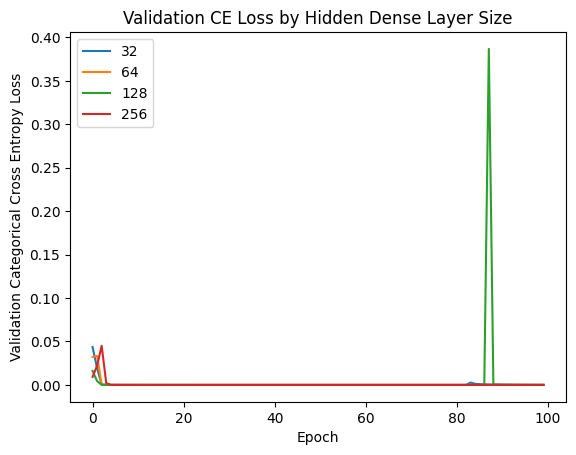

In [ ]:
fig, ax = plt.subplots()


ax.plot(history32.history['val_loss'], label="32")

ax.plot(history64.history['val_loss'], label="64")

ax.plot(history128.history['val_loss'], label="128")

ax.plot(history256.history['val_loss'], label="256")

ax.set_title("Validation CE Loss by Hidden Dense Layer Size")

ax.set_ylabel('Validation Categorical Cross Entropy Loss')

ax.set_xlabel('Epoch')

ax.legend()

plt.show()

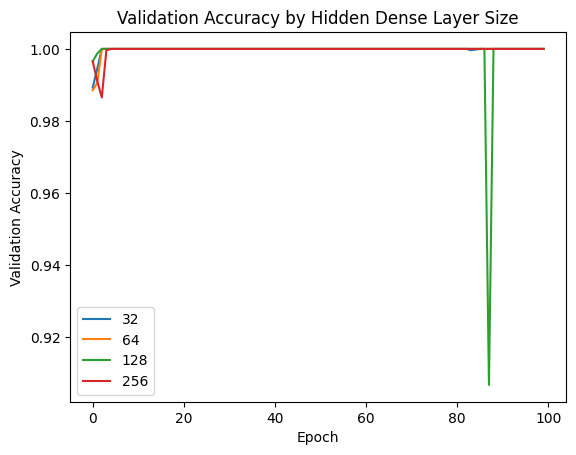

In [ ]:
fig, ax = plt.subplots()

ax.plot(history32.history['val_accuracy'], label="32")

ax.plot(history64.history['val_accuracy'], label="64")

ax.plot(history128.history['val_accuracy'], label="128")

ax.plot(history256.history['val_accuracy'], label="256")

ax.set_title("Validation Accuracy by Hidden Dense Layer Size")

ax.set_ylabel('Validation Accuracy')

ax.set_xlabel('Epoch')

ax.legend()

plt.show()

We will select the model with hidden dense layer size of 64 to perform further experiments on because of its performance and quicker training time than the larger 256 unit model.


# Experimentation with ConvNet in Keras




First, adding max pooling after each convolutional layer

In [ ]:

#conv Net with fully connected hidden layers of size 64
conv_net_pool = Sequential()

#adding 3x convolution layer+max pooling
conv_net_pool.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # sequential model needs the input shape
conv_net_pool.add(MaxPooling2D(pool_size=pool_size))

conv_net_pool.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_pool.add(MaxPooling2D(pool_size=pool_size))

conv_net_pool.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_pool.add(MaxPooling2D(pool_size=pool_size))

# flatten serves as a connection between the convolution and dense layers
conv_net_pool.add(Flatten())

#adding 2 fully connected layers
conv_net_pool.add(Dense(hidden_sizes[1], activation='relu'))
conv_net_pool.add(Dense(hidden_sizes[1], activation='relu'))
conv_net_pool.add(Dense(num_classes, activation='softmax')) # output layer


In [ ]:
conv_net_pool.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)         

In [ ]:
conv_net_pool.compile(
  'adam',                             # optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_modelpool.hdf5",  # saving the best model
                            monitor='val_accuracy', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='max',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # when using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# fitting the model
history_pool = conv_net_pool.fit(
  X_train_conv,
  y_train,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_val_conv, y_val), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
344/344 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.6649
Epoch 1: val_accuracy improved from -inf to 0.94864, saving model to mnist_best_modelpool.hdf5
344/344 [==============================] - 4s 6ms/step - loss: 1.0886 - accuracy: 0.6649 - val_loss: 0.1972 - val_accuracy: 0.9486
Epoch 2/100
336/344 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9795
Epoch 2: val_accuracy improved from 0.94864 to 0.99818, saving model to mnist_best_modelpool.hdf5
344/344 [==============================] - 2s 5ms/step - loss: 0.0808 - accuracy: 0.9800 - val_loss: 0.0193 - val_accuracy: 0.9982
Epoch 3/100
331/344 [===========================>..] - ETA: 0s - loss: 0.0218 - accuracy: 0.9949
Epoch 3: val_accuracy did not improve from 0.99818
344/344 [==============================] - 2s 4ms/step - loss: 0.0219 - accuracy: 0.9948 - val_loss: 0.0303 - val_accuracy: 0.9927
Epoch 4/100
336/344 [============================>.] - ETA: 0s - loss: 0

In [ ]:
conv_net_pool.load_weights("mnist_best_modelpool.hdf5")

loss_pool, acc_pool = conv_net_pool.evaluate(X_test_conv, y_test, verbose=2)
print("Hidden Unit Size 64 with Max Pooling")
print("test accuracy: {:5.2f}%".format(100 * acc_pool))
print("test loss: {:5.2f}".format(loss_pool))

225/225 - 1s - loss: 0.4988 - accuracy: 0.8872 - 674ms/epoch - 3ms/step
Hidden Unit Size 64 with Max Pooling
test accuracy: 88.72%
test loss:  0.50


Adding Batch Normalization

In [ ]:

#conv Net with fully connected hidden layers of size 64
conv_net_bn = Sequential()

#adding Batch Normalization

conv_net_bn.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # sequential model needs the input shape
conv_net_bn.add(MaxPooling2D(pool_size=pool_size))
conv_net_bn.add(BatchNormalization())

conv_net_bn.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_bn.add(MaxPooling2D(pool_size=pool_size))
conv_net_bn.add(BatchNormalization())

conv_net_bn.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_bn.add(MaxPooling2D(pool_size=pool_size))
conv_net_bn.add(BatchNormalization())

# flatten serves as a connection between the convolution and dense layers
conv_net_bn.add(Flatten())

#adding 2 fully connected layers
conv_net_bn.add(Dense(hidden_sizes[1], activation='relu'))
conv_net_bn.add(Dense(hidden_sizes[1], activation='relu'))
conv_net_bn.add(Dense(num_classes, activation='softmax')) # output layer


In [ ]:
conv_net_bn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 13, 13, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                      

In [ ]:
conv_net_bn.compile(
  'adam',                             # optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_modelbn.hdf5",  # saving the best model
                            monitor='val_accuracy', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='max',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # when using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# fitting the model
history_bn = conv_net_bn.fit(
  X_train_conv,
  y_train,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_val_conv, y_val), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
341/344 [============================>.] - ETA: 0s - loss: 0.6040 - accuracy: 0.8493
Epoch 1: val_accuracy improved from -inf to 0.89783, saving model to mnist_best_modelbn.hdf5
344/344 [==============================] - 4s 6ms/step - loss: 0.6003 - accuracy: 0.8502 - val_loss: 0.4290 - val_accuracy: 0.8978
Epoch 2/100
333/344 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9984
Epoch 2: val_accuracy improved from 0.89783 to 1.00000, saving model to mnist_best_modelbn.hdf5
344/344 [==============================] - 2s 5ms/step - loss: 0.0127 - accuracy: 0.9984 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/100
340/344 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
344/344 [==============================] - 2s 5ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 9.1300e-04 - val_accuracy: 1.0000
Epoch 4/100
342/344 [============================>.] - ETA: 0s - loss: 7

In [ ]:
conv_net_bn.load_weights("mnist_best_modelbn.hdf5")

loss_bn, acc_bn = conv_net_bn.evaluate(X_test_conv, y_test, verbose=2)
print("Hidden Unit Size 64 with Max Pooling and Batch Normalization")
print("test accuracy: {:5.2f}%".format(100 * acc_bn))
print("test loss: {:5.2f}".format(loss_bn))

225/225 - 0s - loss: 0.2725 - accuracy: 0.9088 - 465ms/epoch - 2ms/step
Hidden Unit Size 64 with Max Pooling and Batch Normalization
test accuracy: 90.88%
test loss:  0.27


Trying Dropout Layer

In [ ]:
#conv Net with fully connected hidden layers of size 64
conv_net_dropout = Sequential()

#adding 3x convolution layer+batch normalization+max pooling
conv_net_dropout.add(Conv2D(filters = 4 * num_filters,
                 kernel_size = filter_size,
                 strides     = strides,
                 input_shape = input_shape,
                 padding     = padding,
                 activation  = 'relu')) # sequential model needs the input shape
conv_net_dropout.add(BatchNormalization())
conv_net_dropout.add(MaxPooling2D(pool_size=pool_size))

conv_net_dropout.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_dropout.add(BatchNormalization())
conv_net_dropout.add(MaxPooling2D(pool_size=pool_size))

conv_net_dropout.add(Conv2D(filters = 8 * num_filters, kernel_size = (filter_size, filter_size)))
conv_net_dropout.add(BatchNormalization())
conv_net_dropout.add(MaxPooling2D(pool_size=pool_size))

# flatten serves as a connection between the convolution and dense layers
conv_net_dropout.add(Flatten())

#adding 2 fully connected layers
conv_net_dropout.add(Dense(hidden_sizes[1], activation='relu'))
conv_net_dropout.add(Dense(hidden_sizes[1], activation='relu'))

#add dropout layer
conv_net_dropout.add(Dropout(0.5))

conv_net_dropout.add(Dense(num_classes, activation='softmax')) # output layer


In [ ]:
conv_net_dropout.compile(
  'adam',                             # optimizer: Adam for gradient descent-based: https://keras.io/api/optimizers/
  loss='categorical_crossentropy',    # loss function: Categorical for 10 classes: https://keras.io/api/losses/
  metrics=['accuracy'],               # accuracy metric, can choose from keras metrics: https://keras.io/api/metrics/
)

In [ ]:
epochs = 100

# saving the model during training to be used later
checkpoint = ModelCheckpoint("mnist_best_modeldropout.hdf5",  # saving the best model
                            monitor='val_accuracy', verbose=1,
                            save_weights_only = False, # if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).
                            save_best_only=True,       # only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                            mode='max',               # the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min,
                            save_freq = 'epoch')       # when using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches.


In [ ]:
# fitting the model
history_dropout = conv_net_dropout.fit(
  X_train_conv,
  y_train,
  epochs=epochs,                # number of training epochs
  batch_size=batch_size,
  verbose = 1,
  validation_data=(X_val_conv, y_val), # validation data
  callbacks=[checkpoint]      # callback to save the model during trainings
)

Epoch 1/100
336/344 [============================>.] - ETA: 0s - loss: 1.2804 - accuracy: 0.6137
Epoch 1: val_accuracy improved from -inf to 0.85522, saving model to mnist_best_modeldropout.hdf5
344/344 [==============================] - 5s 6ms/step - loss: 1.2595 - accuracy: 0.6203 - val_loss: 0.7264 - val_accuracy: 0.8552
Epoch 2/100
335/344 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9572
Epoch 2: val_accuracy improved from 0.85522 to 0.99964, saving model to mnist_best_modeldropout.hdf5
344/344 [==============================] - 2s 5ms/step - loss: 0.1558 - accuracy: 0.9578 - val_loss: 0.0124 - val_accuracy: 0.9996
Epoch 3/100
342/344 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9832
Epoch 3: val_accuracy improved from 0.99964 to 0.99982, saving model to mnist_best_modeldropout.hdf5
344/344 [==============================] - 2s 5ms/step - loss: 0.0679 - accuracy: 0.9833 - val_loss: 0.0034 - val_accuracy: 0.9998
Epoch 4/100
340/

In [ ]:
conv_net_dropout.load_weights("mnist_best_modeldropout.hdf5")

loss_dropout, acc_dropout = conv_net_dropout.evaluate(X_test_conv, y_test, verbose=2)
print("Hidden Unit Size 64 with Max Pooling, Batch Normalization, and Dropout")
print("test accuracy: {:5.2f}%".format(100 * acc_dropout))
print("test loss: {:5.2f}".format(loss_dropout))

225/225 - 0s - loss: 0.4941 - accuracy: 0.9020 - 491ms/epoch - 2ms/step
Hidden Unit Size 64 with Max Pooling, Batch Normalization, and Dropout
test accuracy: 90.20%
test loss:  0.49


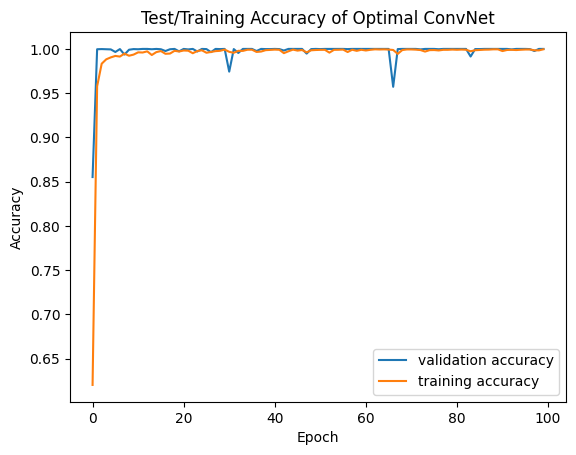

In [ ]:
fig, ax = plt.subplots()


ax.plot(history_dropout.history['val_accuracy'], label="validation accuracy")

ax.plot(history_dropout.history['accuracy'], label="training accuracy")

ax.set_title("Test/Training Accuracy of Optimal ConvNet")

ax.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

ax.legend()

plt.show()

**3.5 - Implement optimal MLP architecture and compare to ConvNet**

In [ ]:
#Adding dropout layer to ML Model 2

In [ ]:

class DropoutLayer(NeuralNetLayer):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training=True):
        if training:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=x.shape) / (1 - self.dropout_rate)
            return x * self.mask
        else:
            return x

    def backward(self, gradient):
        return gradient * self.mask if self.mask is not None else gradient

In [ ]:
mlps_adjusted = [ #Model 2 with added dropout layer
    MLP(
    LinearLayer(i_size, hidden_size),
    ReLULayer(),
    DropoutLayer(dropout_rate=0.2),
    LinearLayer(hidden_size, num_classes),
    SoftmaxOutputLayer()
) for hidden_size in hidden_sizes
]

opts_adjusted = [StochasticGradientDescentOptimizer(mlp, 1e-1) for mlp in mlps_adjusted]

#0.5 dropout rate produced worse accuracy
#need to run 200, maybe 300

  0%|          | 1/200 [00:07<26:09,  7.89s/it]

3.6546994517402362


  1%|          | 2/200 [00:15<25:26,  7.71s/it]

3.590113841246425


  2%|▏         | 3/200 [00:23<25:25,  7.75s/it]

3.5229980435767194


  2%|▏         | 4/200 [00:30<25:16,  7.74s/it]

3.4604722256723237


  2%|▎         | 5/200 [00:38<24:55,  7.67s/it]

3.398264068389864


  3%|▎         | 6/200 [00:46<24:43,  7.65s/it]

3.3342788783562605


  4%|▎         | 7/200 [00:53<24:34,  7.64s/it]

3.2775915041417325


  4%|▍         | 8/200 [01:01<24:28,  7.65s/it]

3.22389722879235


  4%|▍         | 9/200 [01:09<24:18,  7.64s/it]

3.1654928191316225


  5%|▌         | 10/200 [01:16<24:09,  7.63s/it]

3.1172989152111863


  6%|▌         | 11/200 [01:24<23:57,  7.61s/it]

3.0708828377516726


  6%|▌         | 12/200 [01:31<23:47,  7.59s/it]

3.0234255981301694


  6%|▋         | 13/200 [01:39<23:49,  7.64s/it]

2.9805745616354686


  7%|▋         | 14/200 [01:47<23:37,  7.62s/it]

2.9317034896252925


  8%|▊         | 15/200 [01:54<23:27,  7.61s/it]

2.902676893422716


  8%|▊         | 16/200 [02:02<23:20,  7.61s/it]

2.8580720322476574


  8%|▊         | 17/200 [02:09<23:09,  7.59s/it]

2.8320325087686724


  9%|▉         | 18/200 [02:17<23:02,  7.60s/it]

2.79012112129939


 10%|▉         | 19/200 [02:24<22:50,  7.57s/it]

2.762836413310327


 10%|█         | 20/200 [02:32<22:46,  7.59s/it]

2.7352129444018543


 10%|█         | 21/200 [02:40<22:39,  7.60s/it]

2.7081756260251573


 11%|█         | 22/200 [02:47<22:25,  7.56s/it]

2.6779266037456453


 12%|█▏        | 23/200 [02:55<22:16,  7.55s/it]

2.653766786308142


 12%|█▏        | 24/200 [03:02<22:05,  7.53s/it]

2.6268859444075083


 12%|█▎        | 25/200 [03:10<22:11,  7.61s/it]

2.599473012425156


 13%|█▎        | 26/200 [03:18<21:59,  7.58s/it]

2.577427178474905


 14%|█▎        | 27/200 [03:25<21:48,  7.56s/it]

2.5614799424483023


 14%|█▍        | 28/200 [03:33<21:36,  7.54s/it]

2.538845730190943


 14%|█▍        | 29/200 [03:40<21:27,  7.53s/it]

2.5150110933247185


 15%|█▌        | 30/200 [03:48<21:20,  7.53s/it]

2.501685878903955


 16%|█▌        | 31/200 [03:55<21:10,  7.52s/it]

2.482199949207645


 16%|█▌        | 32/200 [04:03<21:10,  7.56s/it]

2.468712936063313


 16%|█▋        | 33/200 [04:10<21:02,  7.56s/it]

2.4472151834453846


 17%|█▋        | 34/200 [04:18<20:50,  7.53s/it]

2.4318343073004325


 18%|█▊        | 35/200 [04:25<20:40,  7.52s/it]

2.415391517966354


 18%|█▊        | 36/200 [04:33<20:29,  7.50s/it]

2.3993696082646343


 18%|█▊        | 37/200 [04:41<20:40,  7.61s/it]

2.3923509499368913


 19%|█▉        | 38/200 [04:48<20:31,  7.60s/it]

2.379482315872279


 20%|█▉        | 39/200 [04:56<20:30,  7.64s/it]

2.3651881197245155


 20%|██        | 40/200 [05:03<20:16,  7.60s/it]

2.352002759494377


 20%|██        | 41/200 [05:11<20:01,  7.56s/it]

2.3373195042751984


 21%|██        | 42/200 [05:18<19:49,  7.53s/it]

2.324249068139278


 22%|██▏       | 43/200 [05:26<19:40,  7.52s/it]

2.3172936555177945


 22%|██▏       | 44/200 [05:34<19:51,  7.64s/it]

2.3043043554870555


 22%|██▎       | 45/200 [05:41<19:40,  7.62s/it]

2.294982462404777


 23%|██▎       | 46/200 [05:49<19:26,  7.57s/it]

2.281892613601037


 24%|██▎       | 47/200 [05:56<19:17,  7.57s/it]

2.274009043057283


 24%|██▍       | 48/200 [06:04<19:09,  7.56s/it]

2.2643584277305644


 24%|██▍       | 49/200 [06:11<19:03,  7.58s/it]

2.254834088688406


 25%|██▌       | 50/200 [06:19<18:56,  7.57s/it]

2.2481710687725975


 26%|██▌       | 51/200 [06:27<18:48,  7.57s/it]

2.234767366370273


 26%|██▌       | 52/200 [06:34<18:40,  7.57s/it]

2.2306991054018477


 26%|██▋       | 53/200 [06:42<18:29,  7.55s/it]

2.223233933990947


 27%|██▋       | 54/200 [06:49<18:22,  7.55s/it]

2.2121887645336074


 28%|██▊       | 55/200 [06:57<18:15,  7.55s/it]

2.205806144649636


 28%|██▊       | 56/200 [07:04<18:07,  7.55s/it]

2.199449784813188


 28%|██▊       | 57/200 [07:12<17:57,  7.53s/it]

2.1923136910866994


 29%|██▉       | 58/200 [07:19<17:43,  7.49s/it]

2.1803386704863725


 30%|██▉       | 59/200 [07:27<17:35,  7.49s/it]

2.177687836992111


 30%|███       | 60/200 [07:34<17:26,  7.47s/it]

2.168075226695131


 30%|███       | 61/200 [07:42<17:26,  7.53s/it]

2.1616032640318257


 31%|███       | 62/200 [07:49<17:20,  7.54s/it]

2.155867170250881


 32%|███▏      | 63/200 [07:57<17:18,  7.58s/it]

2.152263336030415


 32%|███▏      | 64/200 [08:04<17:06,  7.55s/it]

2.1389581508938877


 32%|███▎      | 65/200 [08:12<16:52,  7.50s/it]

2.1367512351045774


 33%|███▎      | 66/200 [08:19<16:44,  7.50s/it]

2.134396396994818


 34%|███▎      | 67/200 [08:27<16:36,  7.49s/it]

2.1267882578543347


 34%|███▍      | 68/200 [08:34<16:34,  7.54s/it]

2.1194531848385556


 34%|███▍      | 69/200 [08:42<16:24,  7.52s/it]

2.1183340203975116


 35%|███▌      | 70/200 [08:49<16:15,  7.50s/it]

2.1076189818702913


 36%|███▌      | 71/200 [08:57<16:08,  7.51s/it]

2.101498776013599


 36%|███▌      | 72/200 [09:04<15:58,  7.49s/it]

2.097858275610254


 36%|███▋      | 73/200 [09:12<16:04,  7.59s/it]

2.0937166079629663


 37%|███▋      | 74/200 [09:20<15:52,  7.56s/it]

2.088464188466336


 38%|███▊      | 75/200 [09:27<15:45,  7.56s/it]

2.08411802959379


 38%|███▊      | 76/200 [09:35<15:35,  7.55s/it]

2.0788405571843502


 38%|███▊      | 77/200 [09:42<15:24,  7.52s/it]

2.0719917986893024


 39%|███▉      | 78/200 [09:50<15:17,  7.52s/it]

2.069214000775231


 40%|███▉      | 79/200 [09:57<15:08,  7.51s/it]

2.0708127799209604


 40%|████      | 80/200 [10:05<15:04,  7.54s/it]

2.061044958889182


 40%|████      | 81/200 [10:12<14:56,  7.54s/it]

2.0544151506534467


 41%|████      | 82/200 [10:20<14:45,  7.50s/it]

2.0507494201987404


 42%|████▏     | 83/200 [10:27<14:35,  7.48s/it]

2.0502675696573003


 42%|████▏     | 84/200 [10:35<14:26,  7.47s/it]

2.044189599645628


 42%|████▎     | 85/200 [10:42<14:21,  7.49s/it]

2.0417354799309106


 43%|████▎     | 86/200 [10:50<14:17,  7.52s/it]

2.0332388587297934


 44%|████▎     | 87/200 [10:57<14:11,  7.53s/it]

2.034415844454548


 44%|████▍     | 88/200 [11:05<14:02,  7.52s/it]

2.0337662752559003


 44%|████▍     | 89/200 [11:12<13:53,  7.50s/it]

2.025375175550863


 45%|████▌     | 90/200 [11:20<13:45,  7.51s/it]

2.021163488386087


 46%|████▌     | 91/200 [11:27<13:35,  7.49s/it]

2.0173865220558644


 46%|████▌     | 92/200 [11:35<13:39,  7.59s/it]

2.017287662074545


 46%|████▋     | 93/200 [11:43<13:30,  7.57s/it]

2.0135944112529294


 47%|████▋     | 94/200 [11:50<13:24,  7.59s/it]

2.0089059479679965


 48%|████▊     | 95/200 [11:58<13:16,  7.59s/it]

2.0044548757463114


 48%|████▊     | 96/200 [12:05<13:04,  7.54s/it]

2.0053956708387877


 48%|████▊     | 97/200 [12:13<12:55,  7.53s/it]

1.998689215322095


 49%|████▉     | 98/200 [12:20<12:47,  7.52s/it]

1.99526531697116


 50%|████▉     | 99/200 [12:28<12:43,  7.56s/it]

1.9938448120864587


 50%|█████     | 100/200 [12:35<12:34,  7.55s/it]

1.989666228535659


 50%|█████     | 101/200 [12:43<12:24,  7.52s/it]

1.991622438341142


 51%|█████     | 102/200 [12:50<12:17,  7.52s/it]

1.984476841226822


 52%|█████▏    | 103/200 [12:58<12:07,  7.50s/it]

1.9806851211398304


 52%|█████▏    | 104/200 [13:05<12:01,  7.52s/it]

1.9781017245719426


 52%|█████▎    | 105/200 [13:13<11:54,  7.52s/it]

1.9731683367021406


 53%|█████▎    | 106/200 [13:21<11:49,  7.55s/it]

1.9771696653098032


 54%|█████▎    | 107/200 [13:28<11:41,  7.54s/it]

1.9694964106974762


 54%|█████▍    | 108/200 [13:36<11:29,  7.50s/it]

1.969813815896418


 55%|█████▍    | 109/200 [13:43<11:23,  7.51s/it]

1.9630873636609292


 55%|█████▌    | 110/200 [13:51<11:16,  7.51s/it]

1.9634310133321096


 56%|█████▌    | 111/200 [13:58<11:16,  7.61s/it]

1.9619925082248275


 56%|█████▌    | 112/200 [14:06<11:06,  7.58s/it]

1.9600110656891276


 56%|█████▋    | 113/200 [14:13<10:54,  7.52s/it]

1.9549551226979038


 57%|█████▋    | 114/200 [14:21<10:47,  7.53s/it]

1.9567850643220726


 57%|█████▊    | 115/200 [14:28<10:37,  7.50s/it]

1.9520776607116985


 58%|█████▊    | 116/200 [14:36<10:33,  7.54s/it]

1.950040081567172


 58%|█████▊    | 117/200 [14:43<10:25,  7.54s/it]

1.949770130808169


 59%|█████▉    | 118/200 [14:51<10:21,  7.58s/it]

1.945158295897388


 60%|█████▉    | 119/200 [14:59<10:12,  7.56s/it]

1.9442279618389928


 60%|██████    | 120/200 [15:06<10:01,  7.52s/it]

1.9432442556461207


 60%|██████    | 121/200 [15:14<09:53,  7.51s/it]

1.9369064180626963


 61%|██████    | 122/200 [15:21<09:44,  7.49s/it]

1.9352823293226873


 62%|██████▏   | 123/200 [15:28<09:37,  7.50s/it]

1.934074359865057


 62%|██████▏   | 124/200 [15:36<09:30,  7.51s/it]

1.937515385584558


 62%|██████▎   | 125/200 [15:43<09:21,  7.48s/it]

1.9333840303146004


 63%|██████▎   | 126/200 [15:51<09:14,  7.50s/it]

1.9274413225084366


 64%|██████▎   | 127/200 [15:58<09:07,  7.50s/it]

1.9264132672522332


 64%|██████▍   | 128/200 [16:06<09:00,  7.51s/it]

1.9236747545392836


 64%|██████▍   | 129/200 [16:14<08:52,  7.50s/it]

1.9253340643897665


 65%|██████▌   | 130/200 [16:21<08:49,  7.57s/it]

1.9203078985766215


 66%|██████▌   | 131/200 [16:29<08:40,  7.54s/it]

1.9225434678878424


 66%|██████▌   | 132/200 [16:36<08:30,  7.50s/it]

1.918716244267811


 66%|██████▋   | 133/200 [16:44<08:21,  7.49s/it]

1.9166302999187341


 67%|██████▋   | 134/200 [16:51<08:12,  7.46s/it]

1.9156145829144167


 68%|██████▊   | 135/200 [16:59<08:08,  7.51s/it]

1.9104937327633804


 68%|██████▊   | 136/200 [17:06<07:59,  7.50s/it]

1.9132491258856161


 68%|██████▊   | 137/200 [17:14<07:52,  7.51s/it]

1.9104169788147043


 69%|██████▉   | 138/200 [17:21<07:45,  7.50s/it]

1.9083149846585161


 70%|██████▉   | 139/200 [17:29<07:37,  7.50s/it]

1.902584414345417


 70%|███████   | 140/200 [17:36<07:30,  7.50s/it]

1.9044572622401428


 70%|███████   | 141/200 [17:44<07:22,  7.50s/it]

1.9018226388114068


 71%|███████   | 142/200 [17:51<07:17,  7.55s/it]

1.901384744631807


 72%|███████▏  | 143/200 [17:59<07:09,  7.54s/it]

1.9021885797645806


 72%|███████▏  | 144/200 [18:06<06:59,  7.50s/it]

1.8968960079170745


 72%|███████▎  | 145/200 [18:14<06:52,  7.49s/it]

1.8949593309238533


 73%|███████▎  | 146/200 [18:21<06:43,  7.48s/it]

1.8950680492321044


 74%|███████▎  | 147/200 [18:29<06:41,  7.58s/it]

1.8908533917283035


 74%|███████▍  | 148/200 [18:36<06:32,  7.55s/it]

1.893352798992518


 74%|███████▍  | 149/200 [18:44<06:27,  7.59s/it]

1.8923693513861517


 75%|███████▌  | 150/200 [18:52<06:17,  7.55s/it]

1.8853966171186172


 76%|███████▌  | 151/200 [18:59<06:09,  7.54s/it]

1.8866459830216749


 76%|███████▌  | 152/200 [19:06<06:00,  7.52s/it]

1.8864759643835978


 76%|███████▋  | 153/200 [19:14<05:51,  7.48s/it]

1.8845980241318936


 77%|███████▋  | 154/200 [19:21<05:45,  7.50s/it]

1.883138775161851


 78%|███████▊  | 155/200 [19:29<05:38,  7.52s/it]

1.8816701790204473


 78%|███████▊  | 156/200 [19:36<05:29,  7.49s/it]

1.8784169190911753


 78%|███████▊  | 157/200 [19:44<05:22,  7.50s/it]

1.8840799940022492


 79%|███████▉  | 158/200 [19:51<05:13,  7.47s/it]

1.8805273001357254


 80%|███████▉  | 159/200 [19:59<05:07,  7.50s/it]

1.8781018141846817


 80%|████████  | 160/200 [20:06<04:59,  7.49s/it]

1.8761402791042974


 80%|████████  | 161/200 [20:14<04:54,  7.55s/it]

1.8739248236818429


 81%|████████  | 162/200 [20:22<04:46,  7.54s/it]

1.8735183501240993


 82%|████████▏ | 163/200 [20:29<04:37,  7.51s/it]

1.87045791210406


 82%|████████▏ | 164/200 [20:37<04:29,  7.50s/it]

1.8729110627671368


 82%|████████▎ | 165/200 [20:44<04:22,  7.50s/it]

1.8713301868709138


 83%|████████▎ | 166/200 [20:52<04:15,  7.52s/it]

1.8695477910026927


 84%|████████▎ | 167/200 [20:59<04:08,  7.52s/it]

1.8698584264339797


 84%|████████▍ | 168/200 [21:07<04:01,  7.54s/it]

1.8676250800913494


 84%|████████▍ | 169/200 [21:14<03:53,  7.53s/it]

1.8662679100995043


 85%|████████▌ | 170/200 [21:22<03:45,  7.50s/it]

1.866391126336486


 86%|████████▌ | 171/200 [21:29<03:37,  7.49s/it]

1.8648695008781735


 86%|████████▌ | 172/200 [21:36<03:29,  7.47s/it]

1.8644066795307017


 86%|████████▋ | 173/200 [21:44<03:22,  7.50s/it]

1.8613003728394684


 87%|████████▋ | 174/200 [21:52<03:15,  7.51s/it]

1.8610556623380898


 88%|████████▊ | 175/200 [21:59<03:07,  7.50s/it]

1.860491666496553


 88%|████████▊ | 176/200 [22:07<02:59,  7.50s/it]

1.8601191029452495


 88%|████████▊ | 177/200 [22:14<02:51,  7.47s/it]

1.8563435244829039


 89%|████████▉ | 178/200 [22:22<02:45,  7.54s/it]

1.8581846676076048


 90%|████████▉ | 179/200 [22:29<02:38,  7.54s/it]

1.8518722928814992


 90%|█████████ | 180/200 [22:37<02:30,  7.54s/it]

1.8569034082986182


 90%|█████████ | 181/200 [22:44<02:22,  7.49s/it]

1.854381930934883


 91%|█████████ | 182/200 [22:52<02:14,  7.48s/it]

1.8497352099201319


 92%|█████████▏| 183/200 [22:59<02:07,  7.47s/it]

1.8533249554263802


 92%|█████████▏| 184/200 [23:06<01:59,  7.45s/it]

1.8538966285816831


 92%|█████████▎| 185/200 [23:14<01:52,  7.53s/it]

1.8510831672533548


 93%|█████████▎| 186/200 [23:22<01:45,  7.51s/it]

1.85098673779519


 94%|█████████▎| 187/200 [23:29<01:37,  7.52s/it]

1.8508886054671192


 94%|█████████▍| 188/200 [23:37<01:29,  7.48s/it]

1.8512464208922812


 94%|█████████▍| 189/200 [23:44<01:21,  7.45s/it]

1.8473125171621108


 95%|█████████▌| 190/200 [23:51<01:14,  7.45s/it]

1.8473687178076905


 96%|█████████▌| 191/200 [23:59<01:07,  7.44s/it]

1.848125465742323


 96%|█████████▌| 192/200 [24:06<00:59,  7.49s/it]

1.8460275786376223


 96%|█████████▋| 193/200 [24:14<00:52,  7.50s/it]

1.8437040152643547


 97%|█████████▋| 194/200 [24:21<00:44,  7.46s/it]

1.8455162865060688


 98%|█████████▊| 195/200 [24:29<00:37,  7.45s/it]

1.8432726204180654


 98%|█████████▊| 196/200 [24:36<00:29,  7.44s/it]

1.8407398339493741


 98%|█████████▊| 197/200 [24:44<00:22,  7.55s/it]

1.843947015504995


 99%|█████████▉| 198/200 [24:52<00:15,  7.56s/it]

1.84272625404518


100%|█████████▉| 199/200 [24:59<00:07,  7.56s/it]

1.8387680859375959


100%|██████████| 200/200 [25:07<00:00,  7.54s/it]

1.8380506390699303
[3.6546994517402362, 3.590113841246425, 3.5229980435767194, 3.4604722256723237, 3.398264068389864, 3.3342788783562605, 3.2775915041417325, 3.22389722879235, 3.1654928191316225, 3.1172989152111863, 3.0708828377516726, 3.0234255981301694, 2.9805745616354686, 2.9317034896252925, 2.902676893422716, 2.8580720322476574, 2.8320325087686724, 2.79012112129939, 2.762836413310327, 2.7352129444018543, 2.7081756260251573, 2.6779266037456453, 2.653766786308142, 2.6268859444075083, 2.599473012425156, 2.577427178474905, 2.5614799424483023, 2.538845730190943, 2.5150110933247185, 2.501685878903955, 2.482199949207645, 2.468712936063313, 2.4472151834453846, 2.4318343073004325, 2.415391517966354, 2.3993696082646343, 2.3923509499368913, 2.379482315872279, 2.3651881197245155, 2.352002759494377, 2.3373195042751984, 2.324249068139278, 2.3172936555177945, 2.3043043554870555, 2.294982462404777, 2.281892613601037, 2.274009043057283, 2.2643584277305644, 2.254834088688406, 2.2481710687725975, 2.2

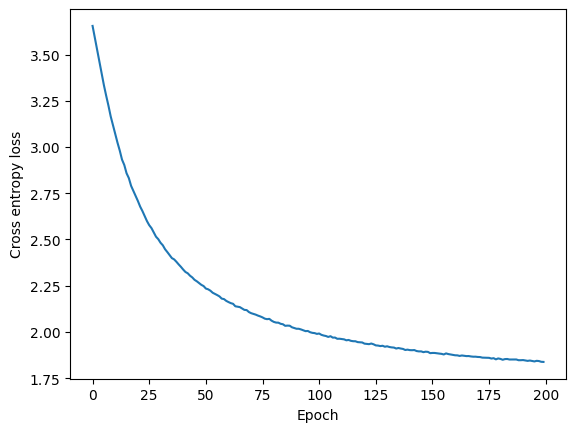

In [ ]:
#using 64
mlp2_64_dropout_trained = train(mlps_adjusted[1], opts_adjusted[1], X_train, train_label, GRADIENT_STEPS_2)

In [ ]:
mlp2_64_dropout_trained_acc = evaluate_acc(test_label, mlp2_64_dropout_trained.forward(X_test))
mlp2_64_dropout_trained_acc

0.4709983268265477